# Surface profile and flow field

When putting a porous biomaterial in a thin liquid film, we observe a rim around the material. This rim looks differently from both the rest of the thin liquid film and the porous material. It seems that in this rim, there is less dye. It also seems that the liquid film thickness does not change monotonically near this rim. A snapshot of this rim is shown below:

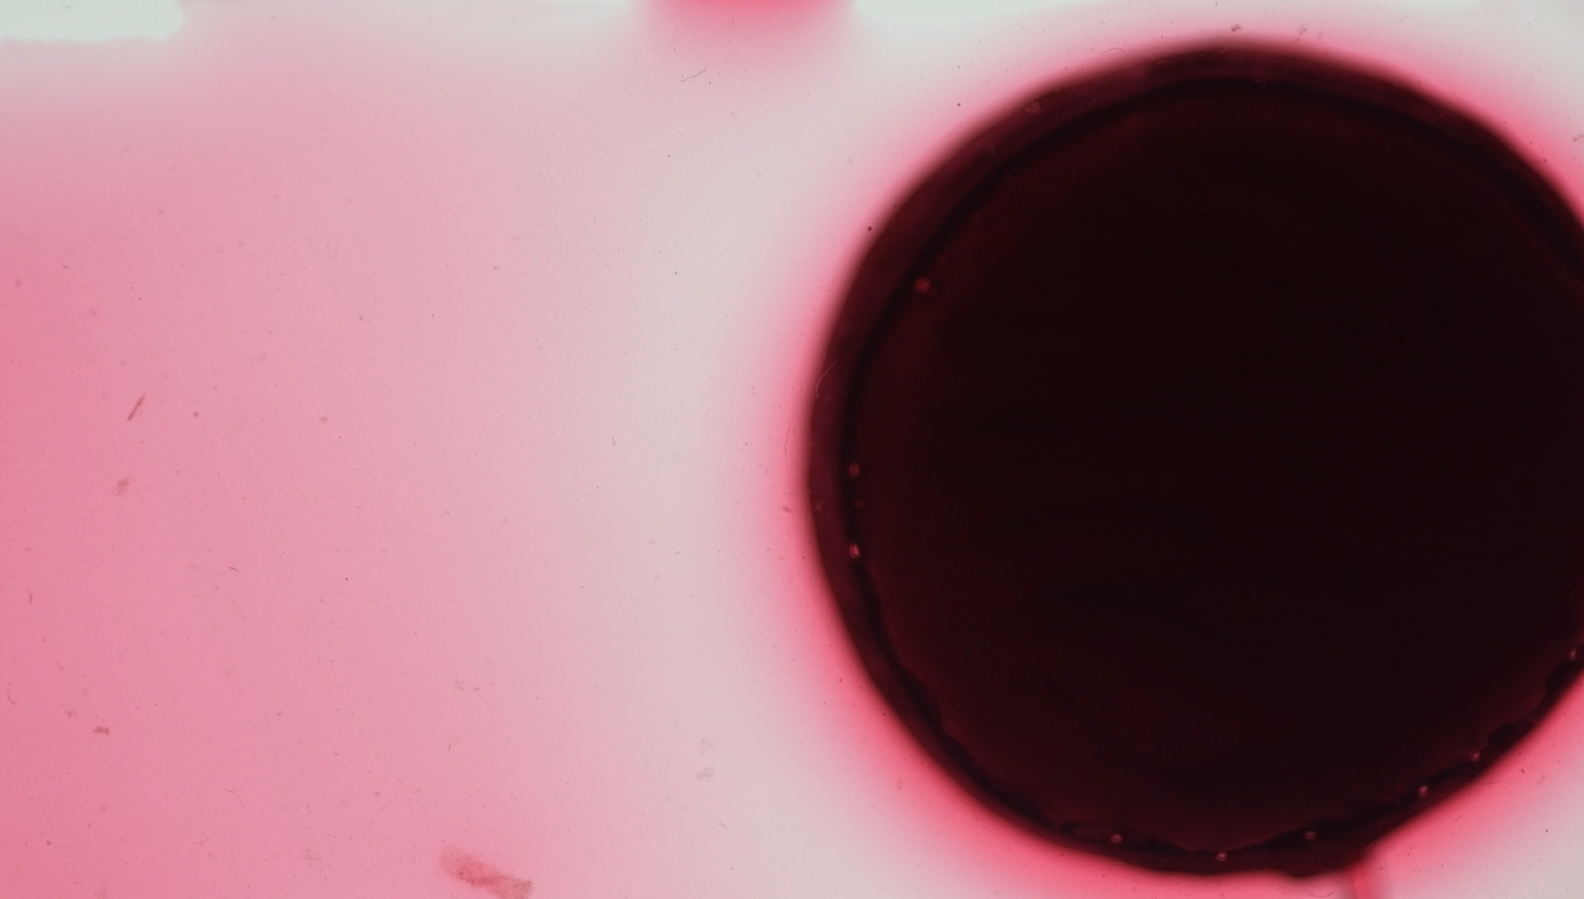

We want to understand the formation mechanism of this rim. Our hypothesis is that there is a dimple in the radial liquid surface profile, which leads to 
- thinner liquid film and in turn less amount of dye;
- curved surface that reflects light differently than flat one.
The two effects makes the rim particularly obvious to our eyes.

To test our hypotheses, I set up an experiment to measure the surface profile of the thin film around the rim. The surface measurement takes advantage of the [Keyence confocal displacement sensor](https://www.keyence.com/products/measure/laser-1d/cl-3000/) mounted on a motorized linear stage. At the same time, we use a Nikon DSLR camera to image the process of the rim formation, in the hope of extracting the flow field associated in this process. The setup is shown in the picture below.

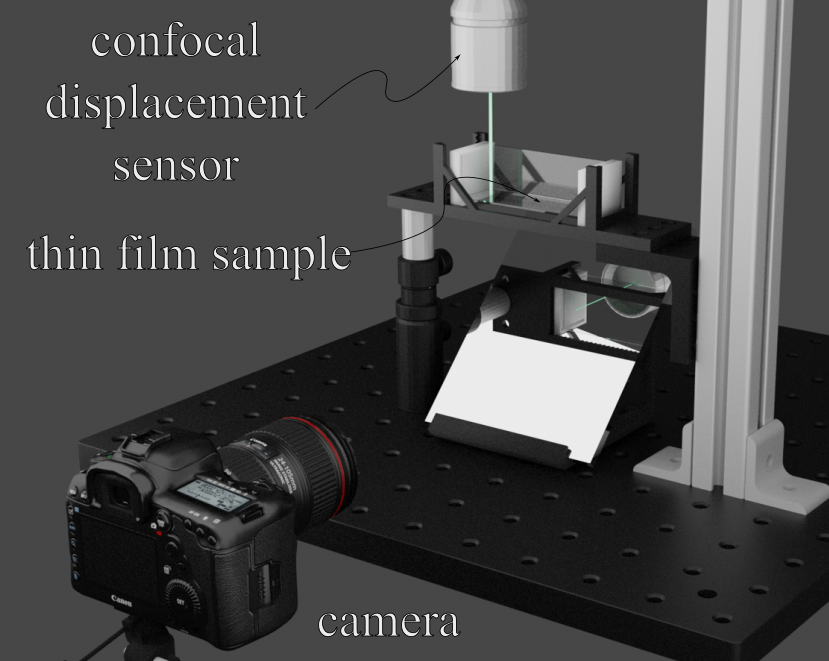

This measurement generates two raw data for each sample scan: 
- a text file of surface height vs. time (.csv);
- a bottom-view video of the scan process (.mov). 

Some postprocessing is required for the raw data:
- convert [surface height vs. time] to [surface height vs. horizontal position x];
- part of the surface height data is out of the liquid film region / out of the measurement range, which needs to be trimmed;
- synchronize the video with the scan, create a new video (like the [demo](https://drive.google.com/open?id=1LuXQMlca6CWQPx2JYWURytDooj1HmHBV&usp=drive_fs));
- measure the flow field using particle tracking velocimetry.

In this notebook, I demonstrate the postprocessing procedures. The expected outputs are:
- surface profile: a table of surface height vs. x, the file should correspond to the raw data file, but the surface height data should be trimmed and converted.
- scan demo: simultaneously display scan images and height results.

## 0 Packages and settings

In [611]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
from myimagelib.myImageLib import bestcolor, readdata
from scipy.signal import medfilt
from skimage import io
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt, argrelextrema, argrelmax, find_peaks
from IPython.display import clear_output
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks


## 1 Surface profile

In this section, we prepare the surface profile table from the raw .csv data.

### 1.1 Load surface height data

Text(0, 0.5, 'Surface height (mm)')

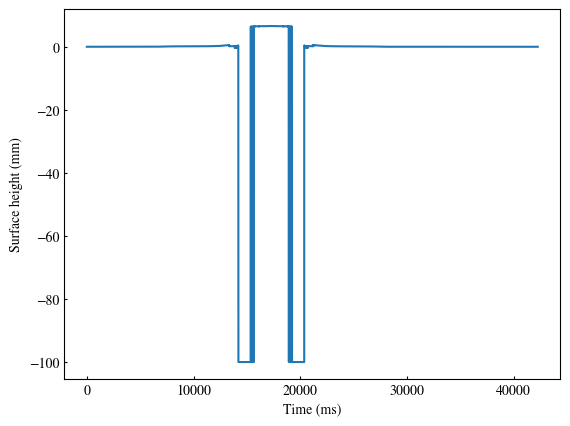

In [6]:
folder = r"F:\WPM\04292024"
filename = "beet_scan_1"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")

The meaningful measurement is usually between 0 and 0.3 mm. The big rise or drop of the data is typically due to the distance being measured is out of range.

### 1.2 Trim the scan data

Trimming the raw scan data in Jupyter notebook is possible but slow because plots in Jupyter notebook does not allow free zooming and panning. Therefore, it is recommanded to use the script `examine_scan.py` view the raw scan data. To do this, navigate to the folder of `examine_scan.py` script, then run

```
python examine_scan.py /path/to/csv
```

If the .csv file exists, this script will open a window showing the scan results. Select the "move tool" which is an arrowed cross, we can zoom and pan the curve with mouse. 


This allows us to locate the "keyframes" of the scans. By keyframes, I mean the start and end point of each scan of the liquid surface. Since the scan runs continuously, it is inevitable that some data are out of the liquid film, so this post processing is neccessary. The attached image illustrates the components of the `keyframes.csv` file. Record the keyframes the `keyframes.csv` file, and then we can trim the raw data.

For example, we run the script and zoom in to see the following scan curve. We first identify the start and end points of the scan. Typically, starting point is where the height value just starts to deviate from 0, and the end point is the highest point of the smooth part. We usually scan back and forth for more time resolved data. In the keyframe recording, we differentiate the forward and backward scans by labels "f" and "b". Then, in each file, we typically have multiple scans of the same surface, we also label an integer on each scan to differentiate them. Lastly, we label the raw data file name to each entry, so we know where to perform the trimming.

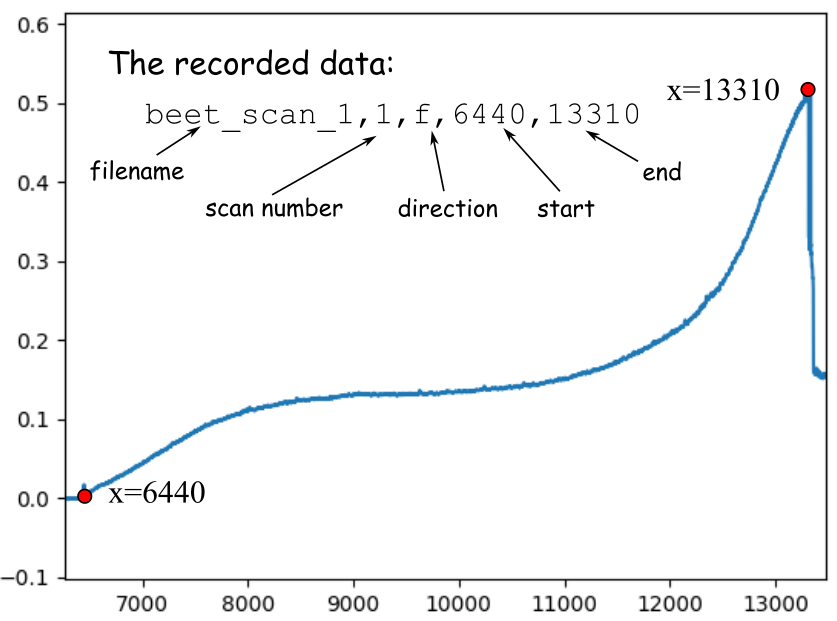


#### 1.2.1 Reformat raw data

So that all the .csv files are just tables of [t, h], where t is consecutive integers and h is the surface height. 

In [ ]:
file_path = r"G:\My Drive\Research projects\WPM\Data\10182024\gw60-1.csv"
# data = pd.read_csv(file_path, skiprows=13, usecols=[3], names=["h"])
data.reset_index(inplace=True, drop=True)
data["t"] = data.index
plt.plot(data.index, data.h)
data[["t", "h"]].to_csv(file_path, index=False)

In [340]:
# process whole folder
folder = r"G:\My Drive\Research projects\WPM\Data\10112024"
l = readdata(folder, "csv")
for num, i in l.iterrows():
    # check if the first row is h, t
    data = pd.read_csv(i.Dir, usecols=[0,1])
    if data.columns[0] != "t":
        data = pd.read_csv(i.Dir, skiprows=12, usecols=[1], names=["h"])
        data.reset_index(inplace=True, drop=True)
        data["t"] = data.index
        data[["t", "h"]].to_csv(i.Dir, index=False)

C:\Users\zl948\AppData\Local\Temp\ipykernel_104728\3079260731.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(i.Dir, usecols=[0,1])
C:\Users\zl948\AppData\Local\Temp\ipykernel_104728\3079260731.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(i.Dir, usecols=[0,1])


#### 1.2.2 Adjust the baseline

Sometimes, the scan data baseline is not at zero. We could adjust this after cropping the data, but it is more handy to shift the raw scan first, because we are also measuring the film thickness from the raw scan. In this section, I develop a code that shifts the baseline. 

In [ ]:
############## Parameters ##############
folder = r"G:\My Drive\Research projects\WPM\Data\10252024"
length = 500 # length of average before the start point
name = "gw80-14"
########################################

keyframes = pd.read_csv(os.path.join(folder, "keyframes.csv"))
file_path = os.path.join(folder, name+".csv")
data = pd.read_csv(file_path)

# extract start points from keyframes.csv
kf = keyframes.loc[(keyframes["direction"] == "f")&(keyframes["name"]==name)]
plt.figure(figsize=(3,3), dpi=300)
ind = kf.start.astype("int")
# take an average of multiple points before the start point
start_height = []
for i in ind:
    start_height.append(data.h.loc[i-length:i].mean())
# plot the baseline
plt.scatter(data.index[ind], start_height, color="red", s=5)
plt.ylim([-0.1, 0.1])

# determine baseline offset
offset = np.mean(start_height)
# subtract offset from the data
data["h"] -= offset

# plot data with offset adjusted
plt.plot(data.index[ind], start_height-offset, color="green")

In [ ]:
data.to_csv(file_path, index=False)

### 1.3 Measure initial thickness

In experiment, the initial thickness is not directly comparable with simulation because there is a squeezing flow when the beet slice and the liquid film are brought into contact. This flow can change the shape/thickness of the film to start with. Therefore, using the thickness of the unperturbed liquid film can be inconsistent. 

Another option is to use the mean height of the first scan. Although it is also not great because some change in the measurable thickness has happened already, but according to our model, mean thickness decays rapidly at the beginning in experiments, suggesting that contact line motion is sort of resolved in time. 

In this section, we do both initial thickness measurement.

#### 1.3.1 Unperturbed film thickness

In this method, we use `examine_scan.py` to find the start and end point of an unperturbed film scan right before each experiment, then manually supply the points to the following code block to compute the mean surface height as the initial thickness.

In [ ]:
df = pd.read_csv(r"G:\My Drive\Research projects\WPM\Data\10252024\gw80-10.csv")
df["h"][78314:81756].mean()

#### 1.3.2 First scan thickness

The best way to get data for this method is to first do the dimple detection and then find the first thickness in the data files.

### 1.4 Convert to surface profile

With this keyframe labeling system, we can process multiple raw data files, and record the keyframes in a separate file, then use the numbers in this file to trim all the data in one run. This keyframe data file, "keyframes.csv", looks like this:

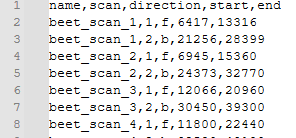

The following code extracts the surface profiles from raw scan data, based on the "keyframes.csv" data we just constructed. The surface profiles are saved as .csv file in the following format:

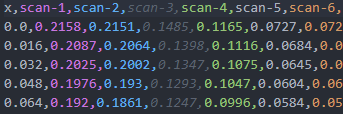

In [335]:
######## set parameters here ##########
data_folder = r"G:\My Drive\Research projects\WPM\Data\10252024" # raw data folder
v = 17.4 # mm/s, I set it constant for now, but later this can be improved by measuring the speed for each specific scan
fps_data = 1000 # the frequency of the Keyence confocal sensor readout, typically 1000
offset = -0.00 # offset to correct the height data
#######################################

save_folder = os.path.join(data_folder, "surface_profile") # folder to save processed data
if os.path.exists(save_folder) == False:
    print("Save folder does not exist, creating ...")
    os.makedirs(save_folder)

keyframes = pd.read_csv(os.path.join(data_folder, "keyframes.csv"))

for name, namegroup in keyframes.groupby("name"): # loop through each file of scans
    print("Processing {0} ...".format(name))
    surface = pd.read_csv(os.path.join(data_folder, "{}.csv".format(name)), usecols=[1])
    surface["h"] = surface["h"] + offset
    for thickness, scans in namegroup.groupby("thickness"): # loop through each initial thickness
        scans_list = []
        t0 = scans.iloc[0]["start"]
        for num, i in scans.iterrows():
            # print("Processing file {0}: scan {1:d}".format(name, i.scan))
            scan = surface[np.round(i.start).astype("int"): np.round(i.end).astype("int")].copy()
            if i.direction == "f":
                scan["x"] = np.flip(np.arange(len(scan))) / fps_data * v
            else:
                scan["x"] = np.arange(len(scan)) / fps_data * v 
            scan.sort_values(by=["x"], inplace=True)
            scans_list.append(scan.set_index("x").rename(columns={"h": "{:.1f}".format(((i.start+i.end)/2 - t0)/fps_data)}))
        print("Writing {0}_{1}.csv".format(name, thickness))
        pd.concat(scans_list, axis=1).dropna().to_csv(os.path.join(save_folder, "{0}_{1:.3f}.csv".format(name, thickness)))

Processing gw80-1 ...
Writing gw80-1_0.26.csv
Writing gw80-1_0.366.csv
Processing gw80-10 ...
Writing gw80-10_0.251.csv
Writing gw80-10_0.305.csv
Processing gw80-11 ...
Writing gw80-11_0.375.csv
Processing gw80-12 ...
Writing gw80-12_0.347.csv
Processing gw80-13 ...
Writing gw80-13_0.415.csv
Processing gw80-15 ...
Writing gw80-15_0.27.csv
Writing gw80-15_0.37.csv
Processing gw80-2 ...
Writing gw80-2_0.48.csv
Processing gw80-3 ...
Writing gw80-3_0.429.csv
Processing gw80-4 ...
Writing gw80-4_0.311.csv
Processing gw80-5 ...
Writing gw80-5_0.367.csv
Writing gw80-5_0.37.csv
Processing gw80-6 ...
Writing gw80-6_0.232.csv
Writing gw80-6_0.471.csv
Processing gw80-7 ...
Writing gw80-7_0.444.csv
Processing gw80-8 ...
Writing gw80-8_0.303.csv


### 1.5 Surface extrapolation

The motion of contact line on the beet wall turns out to be crucial for the dimple formation. Yet, in our scan data, contact line is not resolved due to the steep slope. A possible fix is to extrapolate the surface scan to the beet wall to get the contact line position.

In this section, we will test the idea of extrapolation. We will also use mass conservation to examine the data quality (how much mass is lost during this process).

C:\Users\zl948\AppData\Local\Temp\ipykernel_104728\231396708.py:10: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)


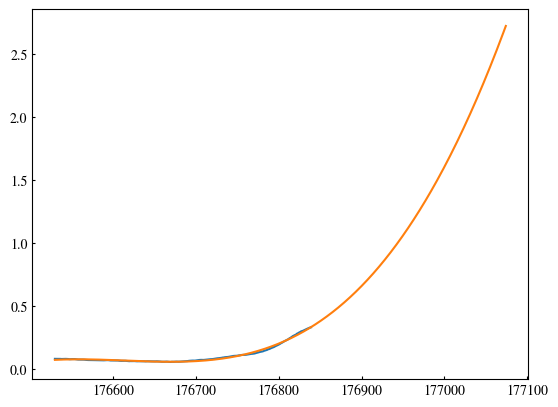

In [365]:
data = pd.read_csv(r"G:\My Drive\Research projects\WPM\Data\10182024\gw60-3.csv")
start = 175986
end = 177075
tip = 176840
mid = (start+end)//2
x = np.arange(mid, tip)
y = data.h[mid:tip].values
# extrapolate
degree = 4
coefficients = np.polyfit(x, y, degree)
polynomial = np.poly1d(coefficients)

x_ext = np.arange(mid, end)
y_ext = polynomial(x_ext)
plt.plot(x, y)
plt.plot(x_ext, y_ext)
# plt.ylim([-0.5, 1])

#### 1.5.1 Determine "tip" position

This method requires us to know the "tip" position in the surface scan. In most cases, the tip is the local maximum in each segment. Here, we implement an automatic tip detection. Sometimes, noise can lead to wrong tip detection. We will manually fix those. 

In [633]:
kf_pre = pd.read_csv(r"C:\Users\zl948\Downloads\keyframes - 10252024.csv")

In [634]:
dist = 300 # distance from wall to look for the tip
for name in kf_pre.name.unique():
    df = pd.read_csv(rf"G:\My Drive\Research projects\WPM\Data\10252024\{name}.csv")
    for num, i in kf_pre.loc[kf_pre.name==name].iterrows():
        if i.direction == "f":
            start = int(i.end) - dist
            end = int(i.end) 
            x = np.arange(start, end)
            y = df.h[start:end].values
            # find cutoff, where y < -0.1
            try:
                end = np.where(y < -0.1)[0][0]
            except:
                end = dist
            # crop x, y
            y = y[:end]
            # find local maxima    
            inds = find_peaks(y, prominence=0.05)
            # if multiple peaks are found, take the last one
            if len(inds[0]) > 1:
                ind = inds[0].max()
            elif len(inds[0]) == 1:
                ind = inds[0][0]
            else:
                ind = np.nan
        else:
            start = int(i.start)
            end = start + dist
            x = np.arange(start, end)
            y = df.h[start:end].values
            yflip = np.flip(y)
            # find cutoff
            try:
                cutoff = np.where(yflip < -0.1)[0][0]
            except:
                cutoff = 0
            crop = end - start - cutoff
            x = x[crop:]
            y = y[crop:]
            # find local maxima
            inds = find_peaks(y, prominence=0.05)
            # if multiple peaks are found, take the first one
            if len(inds[0]) > 1:
                ind = inds[0].min() + crop
            elif len(inds[0]) == 1:
                ind = inds[0][0] + crop
            else:
                ind = np.nan
        tip = start + ind 
        kf_pre.at[num, "tip"] = tip

In [637]:
kf_pre.to_csv(r"C:\Users\zl948\Downloads\keyframes - 10252024.csv", index=False)

(-0.1, 0.7)

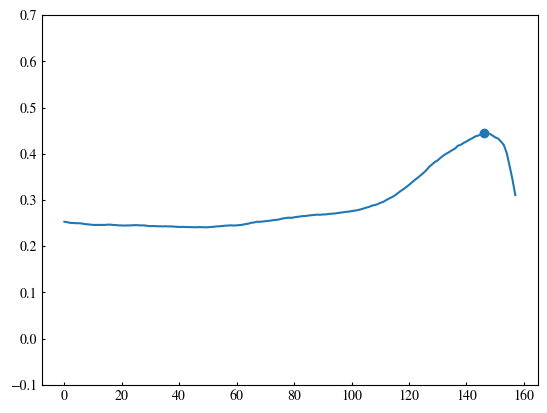

In [636]:
plt.plot(y)
plt.scatter(ind, y[ind])
plt.ylim([-0.1, 0.7])

### 1.5 Plot the surface profiles

#### 1.5.1 Generate surface profile preview

With the organized surface profiles, we can plot them easily. The most informative way of plotting the surface profiles I found is to plot all the repeated scans in one axis. This way we can observe the temporal evolution of the film. 

**Generate preview .jpg for a folder**

In [336]:
folder = r"G:\My Drive\Research projects\WPM\Data\10252024\surface_profile"
l = readdata(folder, "csv")
for num, i in l.iterrows():
    df = pd.read_csv(i.Dir).set_index("x")
    count = 0
    fig, ax = plt.subplots(figsize=(4.5,2.5), dpi=300)
    cmap = plt.get_cmap("viridis")
    tmax = float(df.columns[-1])
    for kw in df:
        if count % 2 == 0:
            ax.plot(df.index, df[kw], color=cmap(float(kw)/tmax), lw=1)
        count += 1

    ax.set_xlim([0, df.index[-1]])
    ax.set_ylim([0, df.max().max()])
    # generate a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=tmax))
    plt.colorbar(sm, ax=ax, label="Time (s)")
    ax.set_xlabel("Distance, $x$ (mm)")
    ax.set_ylabel("Surface height, $h$ (mm)")
    plt.tight_layout()
    fig.savefig(os.path.join(folder, i.Name+".jpg"))
    plt.close(fig)

**Make a single preview**

Text(0, 0.5, 'Surface height, $h$ (mm)')

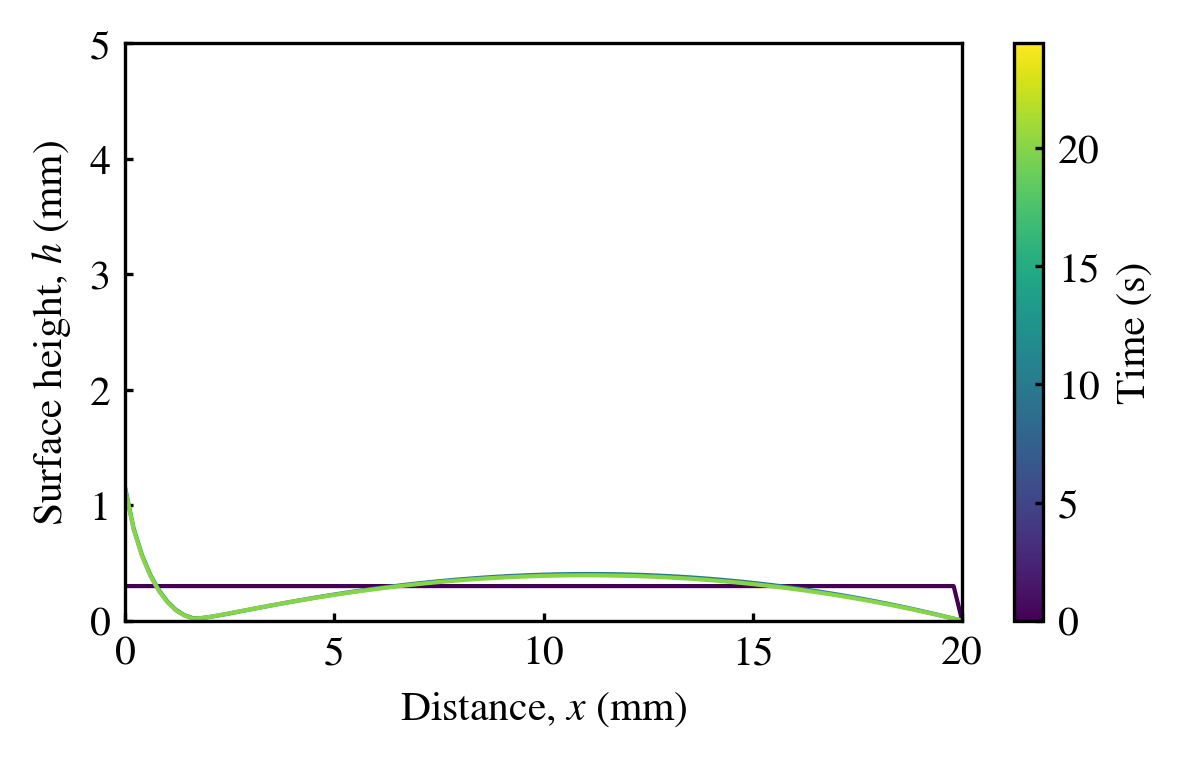

In [97]:
df = pd.read_csv(r"C:\Users\zl948\Documents\WPM_simulation\test.csv").set_index("x")
count = 0
fig, ax = plt.subplots(figsize=(4.5,2.5), dpi=300)
cmap = plt.get_cmap("viridis")
tmax = float(df.columns[-1])
al = []
h0 = []
for kw in df:
    h = df[kw].values
    x = df.index.values
    al.append(compute_contact_angle_0(h, x))
    h0.append(h[0])
    if count % 100 == 0:
        ax.plot(df.index, df[kw], color=cmap(float(kw)/tmax), lw=1)
    count += 1

ax.set_xlim([0, df.index[-1]])
ax.set_ylim([0, 5])
# generate a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=tmax))
plt.colorbar(sm, ax=ax, label="Time (s)")
ax.set_xlabel("Distance, $x$ (mm)")
ax.set_ylabel("Surface height, $h$ (mm)")

In [34]:
def compute_contact_angle_0(h, x):
    """
    Calculate the contact angle based on the film thickness profile
    """
    dh = h[1] - h[0]
    dx = x[1] - x[0]

    if dh == 0:
        return np.pi / 2
    else:
        angle = - np.arctan(dx / dh)
        if angle < 0:
            angle += np.pi
        return angle

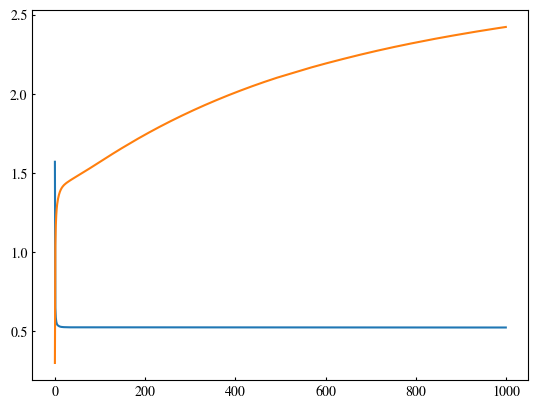

In [51]:
plt.plot(al)
plt.plot(h0)

In [43]:
al

[1.5707963267948966,
 0.5034005129664507,
 0.40089339769737287,
 0.35014284733357837,
 0.317705261995161,
 0.2950708037341412,
 0.27816053816640707,
 0.26478304085762355,
 0.2536897241002136,
 0.24420928369657674,
 0.23589928464807025,
 0.2286262450611515,
 0.22209702981148133,
 0.2162836687040757,
 0.21107424434792932,
 0.20632442038539608,
 0.20203306888600758,
 0.1981154012501316,
 0.19450024907280525,
 0.19115801054319959,
 0.1880936392176993,
 0.1852520431079058,
 0.1826022341092044,
 0.18011858871963268,
 0.1777780861535682,
 0.17559145274050392,
 0.17353563170617806,
 0.17158818569826337,
 0.16973542168528416,
 0.16796475729880886,
 0.16628928244322821,
 0.16470746880383544,
 0.16319906582162502,
 0.1617572981883882,
 0.16037585312110028,
 0.15905310920090476,
 0.15779281563906686,
 0.15658936592954786,
 0.15544063861742205,
 0.15434465000197517,
 0.15328770509470502,
 0.15224011922086578,
 0.15123376145216566,
 0.15026729381287374,
 0.149339454181109,
 0.1484490517575784,
 0.14

**Make an animation** (interpolate for smoother animation)

C:\Users\zl948\AppData\Local\Temp\ipykernel_31544\4278843695.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


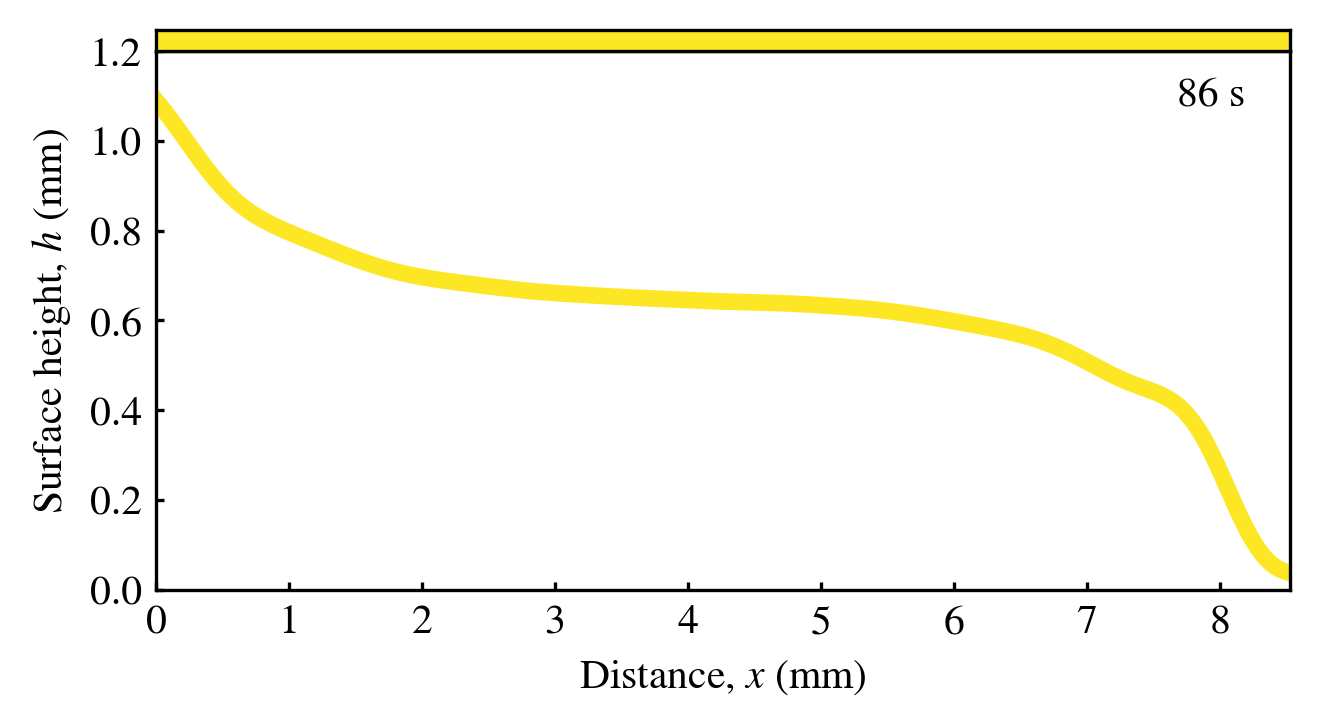

In [26]:
df_raw = pd.read_csv(r"F:\WPM\08212024\surface_profile\beetjuice_2_0.8.csv").set_index("x")
df_raw = df_raw[df_raw.columns[1::2]]
x = df_raw.index
t = df_raw.columns.astype(float)
new_t = np.linspace(t.min(), t.max(), 400)
df = np.zeros((df_raw.shape[0], len(new_t)))
for i in range(df_raw.shape[0]):
    f = interp1d(df_raw.columns.astype(float), df_raw.iloc[i].values, kind="cubic")
    df[i] = f(new_t)


cmap = plt.get_cmap("viridis")
for i in range(1, df.shape[1]):
    fig, ax = plt.subplots(figsize=(4.5,2.5), dpi=300)
    signal = np.array([df_raw.index, df[:, i]])
    filtered = butterworth_filter(signal, 1)
    ax.plot(filtered[0], filtered[1]+0.02, color=cmap(i/len(new_t)), lw=4)
    ax.set_xlim([0, x[-1]])
    ax.set_ylim([0, 1.2])
    ax.annotate(f'{int(new_t[i]):d} s', (.9,.9), xycoords="axes fraction")
    ax.set_xlabel("Distance, $x$ (mm)")
    ax.set_ylabel("Surface height, $h$ (mm)")
    # inset time bar
    inset_ax = inset_axes(ax, width="100%", height="100%", loc='upper right',
                      bbox_to_anchor=(0.0, 1, 1.0, 0.04),
                      bbox_transform=ax.transAxes, borderpad=0)
    # Plot the time bar in the inset axis
    inset_ax.plot(new_t[:i], np.ones(i), color=cmap(i/len(new_t)), lw=5)
    inset_ax.set_xlim(new_t[0], new_t[-1])
    inset_ax.set_ylim(0.7, 1.3)
    
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    
    # inset_ax.axis('off')  # Hide the axis     
    plt.tight_layout()
    plt.pause(0.01)
    fig.savefig(r"F:\WPM\08212024\surface_evolution_demo\beetjuice_2_0.8\{:04d}.jpg".format(i))
    clear_output(wait=True)
    plt.close(fig)


# generate a colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=tmax))
# plt.colorbar(sm, ax=ax, label="Time (s)")


**Curvature preview with smoothing**

Text(0, 0.5, 'Surface height, $h$ (mm)')

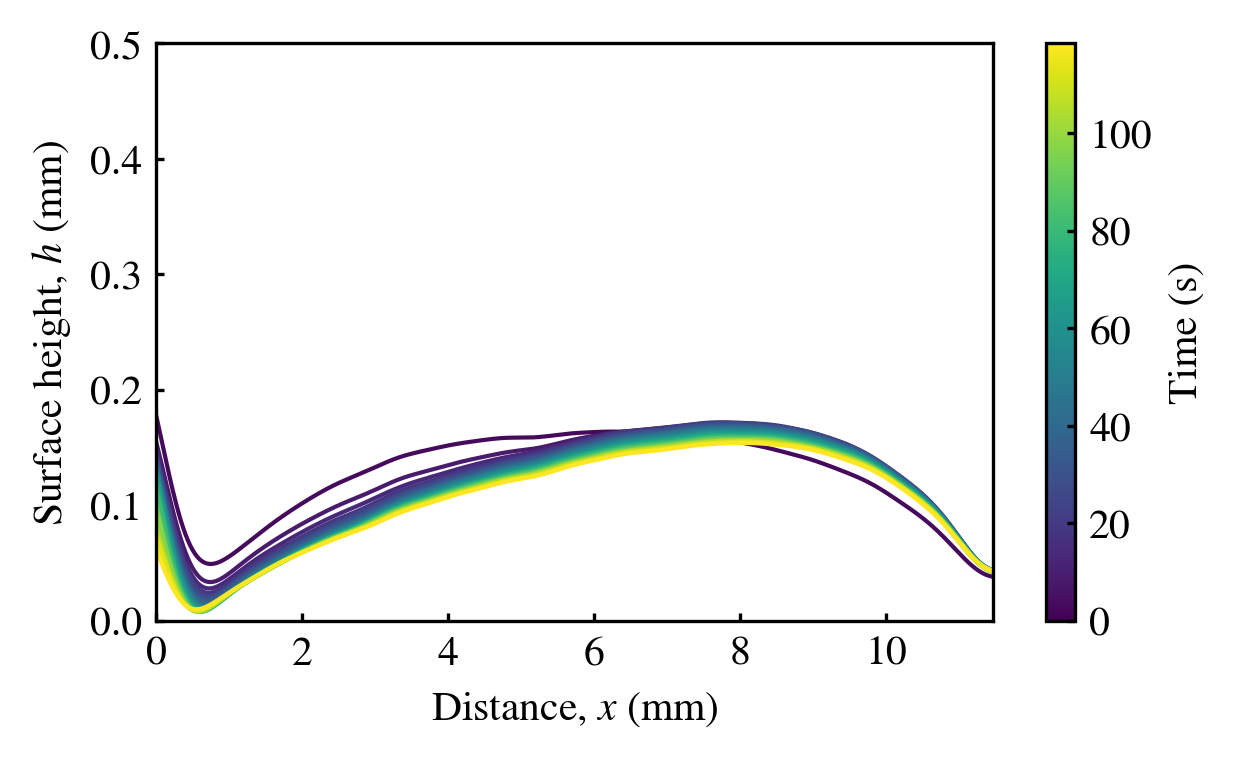

In [101]:
df = pd.read_csv(r"F:\WPM\08212024\surface_profile\beetjuice_1_0.116.csv").set_index("x")
count = 0
fig, ax = plt.subplots(figsize=(4.5,2.5), dpi=300)
cmap = plt.get_cmap("viridis")
tmax = float(df.columns[-1])
for kw in df:
    if count % 2 == 1:
        signal = np.array([df.index, df[kw]])
        cutoff = 1
        filtered = butterworth_filter(signal, cutoff)
        ax.plot(filtered[0], filtered[1]+0.02, color=cmap(float(kw)/tmax), lw=1)
    count += 1

ax.set_xlim([0, df.index[-1]])
ax.set_ylim([0, 0.5])
# generate a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=tmax))
plt.colorbar(sm, ax=ax, label="Time (s)")
ax.set_xlabel("Distance, $x$ (mm)")
ax.set_ylabel("Surface height, $h$ (mm)")

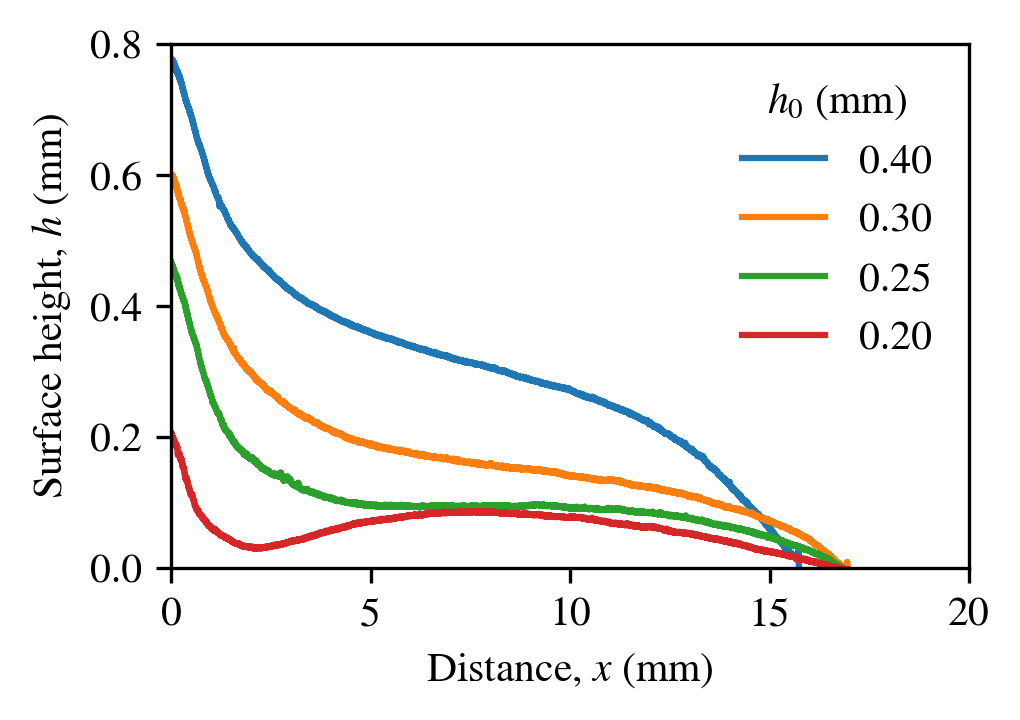

In [6]:
folder = r"E:\WPM\04292024\surface_profile"
files = ["beet_scan4_1_0.csv", "beet_scan4_2_0.csv", "beet_scan4_3_0.csv", "beet_scan4_4_0.csv"]
thicknesses = [0.40, 0.30, 0.25, 0.20]
fig, ax = plt.subplots(figsize=(3.5,2.5), dpi=300)
for f, tn in zip(files, thicknesses):
    df = pd.read_csv(os.path.join(folder, f)).set_index("x")
    ax.plot(df.index, df.iloc[:,1], label=f"{tn:.2f}")
ax.legend(frameon=False, title="$h_0$ (mm)")
ax.set_xlabel("Distance, $x$ (mm)")
ax.set_ylabel("Surface height, $h$ (mm)")
ax.set_xlim([0, 20])
ax.set_ylim([0, 0.8])
plt.tight_layout()
fig.savefig(os.path.join(folder, "beet_scan4.pdf"))


#### 1.5.2 Montage grid for simulation overview

Processing E:\WPM\Simulation\Scan_free_params\kappa_1.0e-06_Pi0_0.0_theta_s_70.0.csv ...
Processing E:\WPM\Simulation\Scan_free_params\kappa_1.0e-06_Pi0_-8.9_theta_s_70.0.csv ...
Processing E:\WPM\Simulation\Scan_free_params\kappa_1.0e-06_Pi0_-17.8_theta_s_70.0.csv ...
Processing E:\WPM\Simulation\Scan_free_params\kappa_5.6e-07_Pi0_0.0_theta_s_70.0.csv ...
Processing E:\WPM\Simulation\Scan_free_params\kappa_5.6e-07_Pi0_-8.9_theta_s_70.0.csv ...
Processing E:\WPM\Simulation\Scan_free_params\kappa_5.6e-07_Pi0_-17.8_theta_s_70.0.csv ...
Processing E:\WPM\Simulation\Scan_free_params\kappa_1.2e-07_Pi0_0.0_theta_s_70.0.csv ...
Processing E:\WPM\Simulation\Scan_free_params\kappa_1.2e-07_Pi0_-8.9_theta_s_70.0.csv ...
Processing E:\WPM\Simulation\Scan_free_params\kappa_1.2e-07_Pi0_-17.8_theta_s_70.0.csv ...


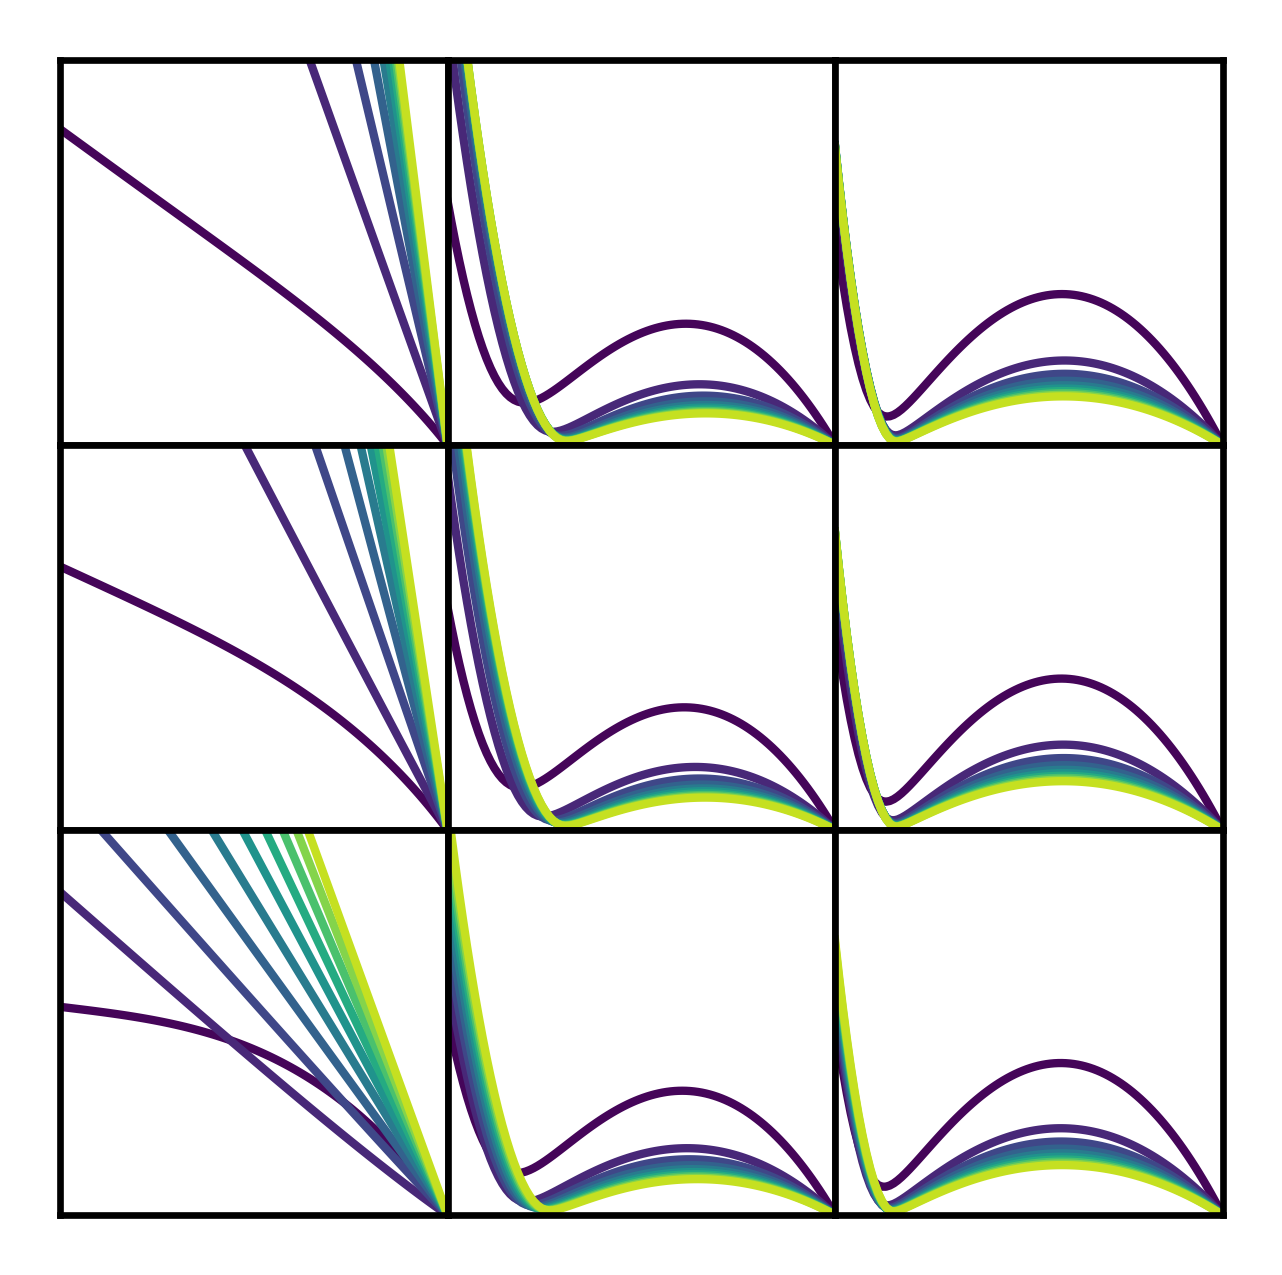

In [355]:
# generate montage of images
fig, ax = plt.subplots(3, 3, figsize=(2.5,2.5), dpi=600, gridspec_kw={"wspace":0.0, "hspace":0.0})
kappa_list = np.linspace(1e-6, 1e-8, 10)
Pi0_list = np.linspace(0, -20, 10)
theta_s_list = np.linspace(0, 90, 10)
theta_s = 70
folder = r"E:\WPM\Simulation\Scan_free_params"
for i, kappa in enumerate(kappa_list[::4]):
    for j, Pi0 in enumerate(Pi0_list[::4]):
        filename = os.path.join(folder, f'kappa_{kappa:.1e}_Pi0_{Pi0:.1f}_theta_s_{theta_s:.1f}.csv')
        print(f"Processing {filename} ...")
        df = pd.read_csv(filename).set_index("x")
        cmap = plt.get_cmap("viridis")
        tmax = float(df.columns[-1])
        for kw in df:
            if count % 100 == 0:
                ax[i][j].plot(df.index, df[kw], color=cmap(float(kw)/tmax), lw=1)
            count += 1
        ax[i][j].set_xlim([0, df.index[-1]])
        ax[i][j].set_ylim([0, .4])
        # remove ticks and labels
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

**Generate animation**

In [4]:
# animation
h0_list = [0.15e-3, 0.2e-3, 0.25e-3]
mu_list = np.logspace(np.log10(1e-3), np.log10(1e-1), 5)
folder = r"G:\My Drive\Research projects\WPM\Data\Simulation\h0_viscosity"
save_folder = r"F:\WPM\Simulation\animation"
tmax = 100
cmap = plt.get_cmap("viridis")  
# read all the dataframes
all_df = {}
for i, h0 in enumerate(h0_list):
    for j, mu in enumerate(mu_list):
        filename = os.path.join(folder, f'mu_{mu:.2e}_h0_{h0:.2e}.csv')
        print(f"Processing {filename} ...")
        df = pd.read_csv(filename).set_index("x")
        all_df[(i,j)] = df
for k in range(1000):
    fig, ax = plt.subplots(3, 5, figsize=(7.5,4.5), dpi=300, gridspec_kw={"wspace":0.0, "hspace":0.0})
    print(f"frame {k:d} ...")
    for i, h0 in enumerate(h0_list):
        for j, mu in enumerate(mu_list):
            df = all_df[(i,j)]
            try:
                ax[i][j].plot(df.index, df[df.columns[k]], color=cmap(float(df.columns[k])/tmax), lw=1)
            except:
                ax[i][j].plot(df.index, df[df.columns[-1]], color=cmap(float(df.columns[-1])/tmax), lw=1)
            ax[i][j].set_xlim([0, df.index[-1]])
            ax[i][j].set_ylim([0, .4])
            # remove ticks and labels
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
    ax[0][-1].annotate(f"{float(df.columns[k]):.1f} s", (0.95,0.95), xycoords="axes fraction", ha="right", va="top")
    plt.tight_layout()
    fig.savefig(os.path.join(save_folder, f"{k:04d}.jpg"))
    plt.close(fig)
    # break

Processing G:\My Drive\Research projects\WPM\Data\Simulation\h0_viscosity\mu_1.00e-03_h0_1.50e-04.csv ...
Processing G:\My Drive\Research projects\WPM\Data\Simulation\h0_viscosity\mu_3.16e-03_h0_1.50e-04.csv ...
Processing G:\My Drive\Research projects\WPM\Data\Simulation\h0_viscosity\mu_1.00e-02_h0_1.50e-04.csv ...
Processing G:\My Drive\Research projects\WPM\Data\Simulation\h0_viscosity\mu_3.16e-02_h0_1.50e-04.csv ...
Processing G:\My Drive\Research projects\WPM\Data\Simulation\h0_viscosity\mu_1.00e-01_h0_1.50e-04.csv ...
Processing G:\My Drive\Research projects\WPM\Data\Simulation\h0_viscosity\mu_1.00e-03_h0_2.00e-04.csv ...
Processing G:\My Drive\Research projects\WPM\Data\Simulation\h0_viscosity\mu_3.16e-03_h0_2.00e-04.csv ...
Processing G:\My Drive\Research projects\WPM\Data\Simulation\h0_viscosity\mu_1.00e-02_h0_2.00e-04.csv ...
Processing G:\My Drive\Research projects\WPM\Data\Simulation\h0_viscosity\mu_3.16e-02_h0_2.00e-04.csv ...
Processing G:\My Drive\Research projects\WPM\D

## 2 Display surface scan and video simultaneously

Making a video out of the surface height data and play together with the bottom-view video help to check the surface height data validity, and also help in understanding the surface height data. In this section, we use the processed surface profile data and the bottom view video to generate the simultaneous display, as shown below:

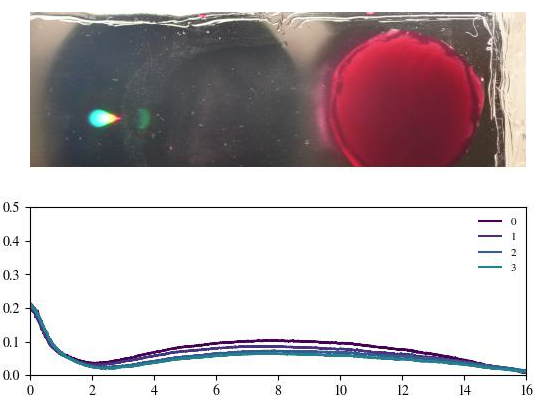

### 2.1 Synchronize raw scan data and video

Open video in MPC and find the first and last moments when laser touches the liquid film. For example, for the file 04292024/beet_scan4_3.MOV, first moment is 00:20.887 and last moment is 02:39.425. In the raw scan data, these two times corresponds to the beginning of the first scan and then end of the last scan, which can be read from the keyframes.csv file: 11797 and 151029. 

In a typical experiment, I start imaging first and then the scan data recording. So we can use linear extrapolation to get the time in the video that corresponds to the starting point of the scan data. 

In [89]:
####### set parameters here ########
v_1 = 10.741
v_2 = 605.665
s_1 = 4357
s_2 = 599354.65
####################################
v_0 = v_1 - s_1 * (v_2 - v_1) / (s_2 - s_1)
print("Scan data recording starts at {:.3f} s in the video.".format(v_0))

Scan data recording starts at 6.385 s in the video.


In [5]:
v_0 = 6.1

### 2.2 Generate images

Use the v_0 calculated in the previous section to register surface scan data and the video. Generate synchronized images. 

frame 10989
frame 10990
frame 10991
frame 10992
frame 10993
frame 10994
frame 10995
frame 10996
frame 10997
frame 10998
frame 10999
frame 11000
frame 11001
frame 11002
frame 11003
frame 11004
frame 11005
frame 11006
frame 11007
frame 11008
frame 11009
frame 11010
frame 11011
frame 11012
frame 11013
frame 11014
frame 11015
frame 11016
frame 11017
frame 11018
frame 11019
frame 11020
frame 11021
frame 11022
frame 11023
frame 11024
frame 11025
frame 11026
frame 11027
frame 11028
frame 11029
frame 11030
frame 11031
frame 11032
frame 11033
frame 11034
frame 11035
frame 11036
frame 11037
frame 11038
frame 11039
frame 11040
frame 11041
frame 11042
frame 11043
frame 11044
frame 11045
frame 11046
frame 11047
frame 11048
frame 11049
frame 11050
frame 11051
frame 11052
frame 11053
frame 11054
frame 11055
frame 11056
frame 11057
frame 11058
frame 11059
frame 11060
frame 11061
frame 11062
frame 11063
frame 11064
frame 11065
frame 11066
frame 11067
frame 11068
frame 11069
frame 11070
frame 11071
fram

KeyError: 44

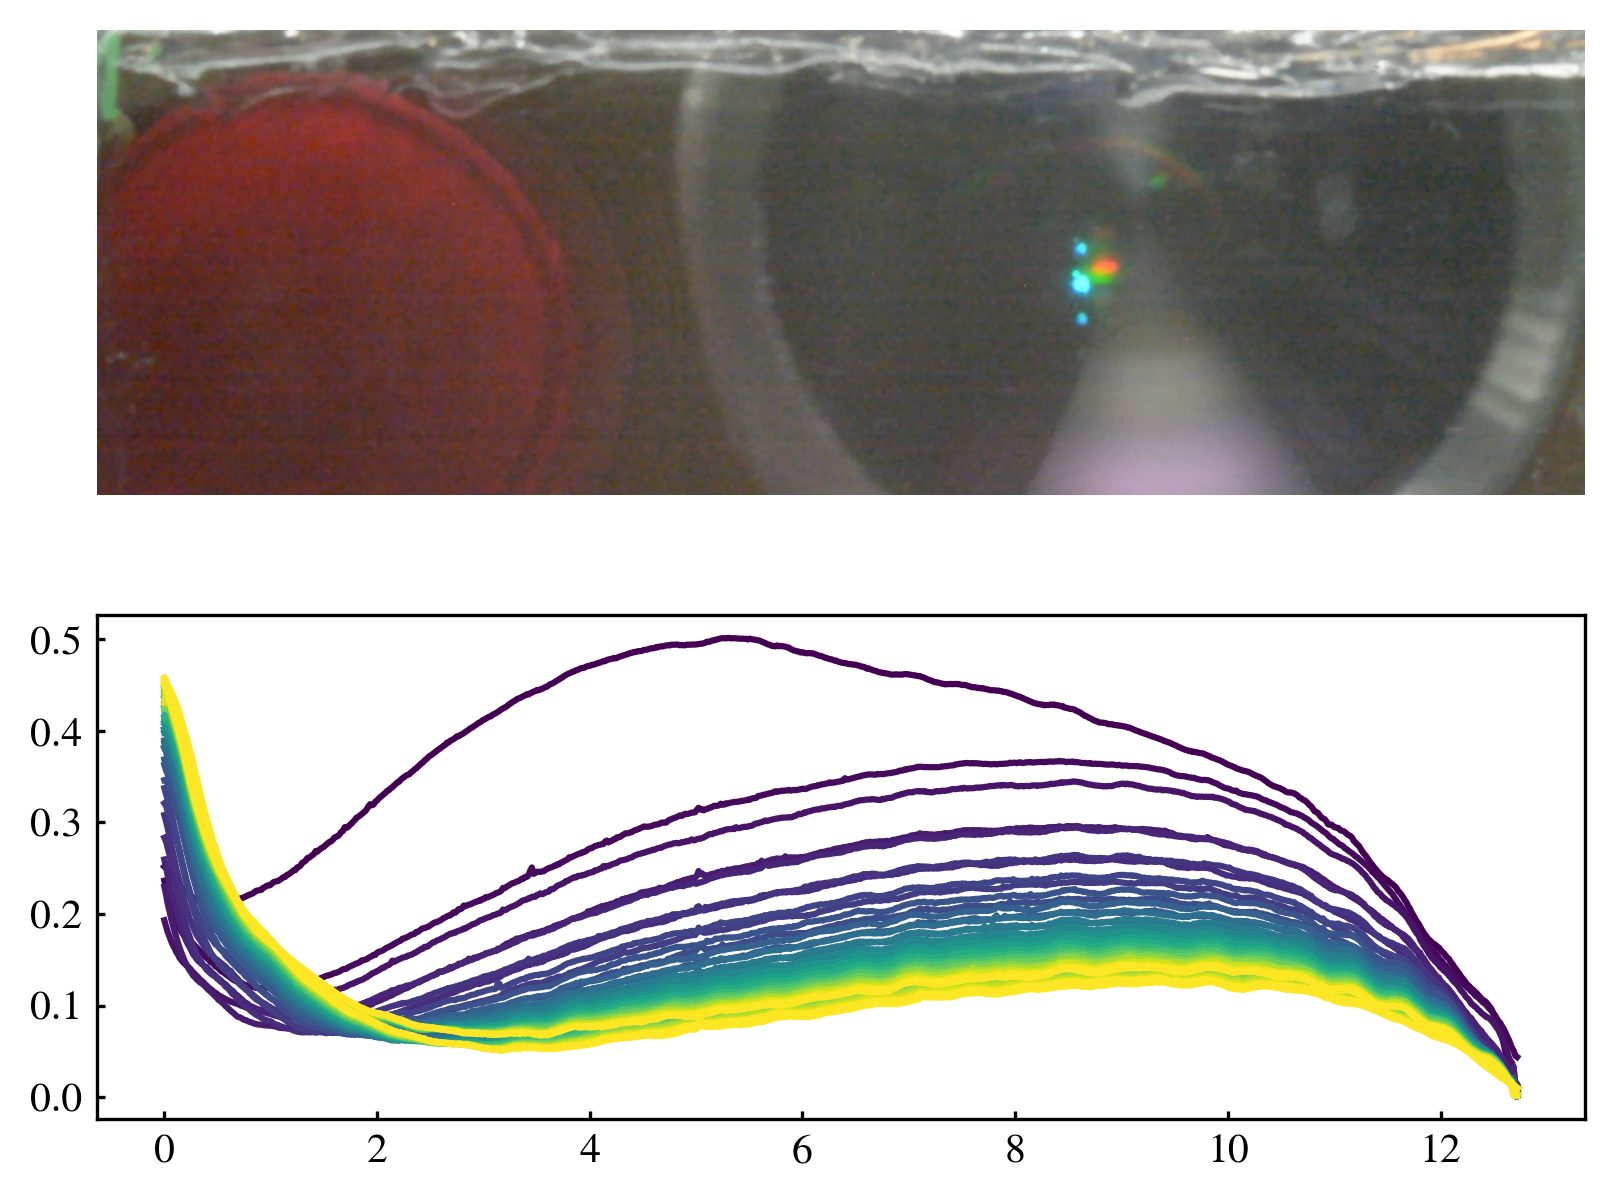

In [8]:
####### set parameters here ###########
data_folder = r"F:\WPM\08212024"
file_name = "beetjuice_3"
interval = 1 # save image every certain frames
fps_data = 1000 # the frequency of the Keyence confocal sensor readout, typically 1000
fps = 30 # video frame rate
start_frame = int(366.3*fps) # the frame number where the scan data starts
end_frame = int(480.242*fps) # the frame number where the scan data ends
#######################################

cap = cv2.VideoCapture(os.path.join(data_folder, file_name + ".MOV"))
data = pd.read_csv(os.path.join(data_folder, "surface_profile", file_name + "_0.305.csv"))
keyframes = pd.read_csv(os.path.join(data_folder, "keyframes.csv"))
keyframes = keyframes.loc[(keyframes["name"]==file_name)&(keyframes["thickness"]==0.305)].reset_index()

save_folder = os.path.join(data_folder, "scan_demo", file_name)
if os.path.exists(save_folder) == False:
    print("Save folder does not exist, creating ...")
    os.makedirs(save_folder)

cmap = plt.get_cmap("viridis", 40)
datalen = len(data)
i = start_frame
j = 0

# set video to start frame
cap.set(cv2.CAP_PROP_POS_FRAMES, i)
while True:
    ret, frame = cap.read() 
    print(f"frame {i:d}")
    # break the loop if no image can be read any more
    if ret == False:
        break 
    # generate image at interval
    if i % interval != 0:
        continue
    # convert imagae to RGB to use matplotlib.imshow
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(ncols=1, nrows=2, dpi=300)
    # ax[0].imshow(frame[200:800, :])
    ax[0].imshow(np.fliplr(frame[200:800, :]))
    ax[0].axis("off")
    step = int((i / fps - v_0) * fps_data)

    # plot all the past full curves
    for k in range(j):
        ax[1].plot(data.x, data[data.columns[k+1]], color=cmap(k), label=k)

    # plot the partial curve
    fraction = (step - keyframes.at[j, "start"]) / (keyframes.at[j, "end"] - keyframes.at[j, "start"])
    if fraction > 0:
        if keyframes.at[j, "direction"] == "f":
            ax[1].plot(data.loc[int(datalen*(1-fraction)):, "x"], data.loc[int(datalen*(1-fraction)):, data.columns[j+1]], color=cmap(j), label=j)
        else:
            ax[1].plot(data.loc[:int(datalen*fraction), "x"], data.loc[:int(datalen*fraction), data.columns[j+1]], color=cmap(j), label=j)
        # plt.legend(fontsize=8, frameon=False)

    # set axis limits and save plots
    ax[1].set_xlim([0, 13])
    ax[1].set_ylim([0, 0.5])
    ax[1].set_xlabel("Distance, $x$ (mm)")
    ax[1].set_ylabel("Surface height, $h$ (mm)")
    plt.savefig(os.path.join(save_folder, "{:04d}.jpg".format(i)))
    plt.close()

    # if the step in scan data is out of the thin film regime, switch to the next one
    if step >= keyframes.at[j, "end"]:
        j += 1
    
    # check end frame
    i += 1
    if i > end_frame:
        break
    # if j >= 8:
    #     break
    # break

## 3 Flow field

Use Tracker to track a few particles manually.

### 3.1 Velocity over time at certain points

Assume that in the proxy of the beet, the flow velocity is independent of position and is only a function of time. Note that this cannot be true, because we know the film is not uniform in thickness. If velocity is constant everywhere, fluid continuity cannot be satisfied. However, the flow rate change here is more drastic in time than in space, 

In [ ]:
flow = pd.read_csv(r"E:\WPM\04292024\flow_field_hand_track\beet_scan4_4_particle.txt", skiprows=2, sep=",").set_index("t")
flow.head()

x      y  x.1  y.1  x.2  y.2  x.3  y.3  Unnamed: 9
t                                                            
5.339  6.049  0.356  NaN  NaN  NaN  NaN  NaN  NaN         NaN
5.372    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN         NaN
5.405    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN         NaN
5.439    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN         NaN
5.472    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN         NaN

In [ ]:
vkey_list = []
for key in flow:
    if "x" in key:
        vkey = key.replace("x", "v")
        vkey_list.append(vkey)
        flow[vkey] = np.nan
        flow.loc[flow[key].dropna().index, vkey] = (flow[key].dropna().diff()) / (flow[key].dropna().index.diff().values)

In [ ]:
v_mean = flow[vkey_list].mean(axis=1).dropna()

Text(0, 0.5, 'Flow velocity, v (mm/s)')

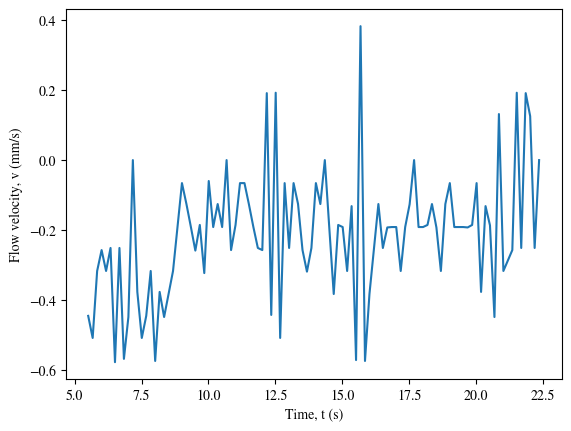

In [ ]:
plt.plot(v_mean)
plt.xlabel("Time, t (s)")
plt.ylabel("Flow velocity, v (mm/s)")

In [ ]:
v_mean.abs().to_frame("Velocity").to_csv(r"E:\WPM\04292024\flow_field_hand_track\beet_scan4_4_flow-time.csv")

Plot the velocity over time for the four scans.

In [2]:
folder = r"E:\WPM\04292024\flow_field_hand_track"
df_list = []
for i in range(4):
    df = pd.read_csv(os.path.join(folder, "beet_scan4_{:d}_flow-time.csv".format(i+1))).rename(columns={"Velocity": "v{:d}".format(i)})
    df["t"] -= df["t"].min()
    df_list.append(df.sort_values("t").set_index("t"))
dfall = pd.concat(df_list, names=["v1", "v2", "v3", "v4"], axis=1)

In [3]:
df.sort_values(by="t")

t        v3
0    0.000  0.445783
1    0.167  0.508982
2    0.334  0.317365
3    0.501  0.257485
4    0.668  0.317365
..     ...       ...
94  16.183  0.251497
95  16.350  0.191617
96  16.517  0.125749
97  16.684  0.251497
98  16.851  0.000000

[99 rows x 2 columns]

<Axes: >

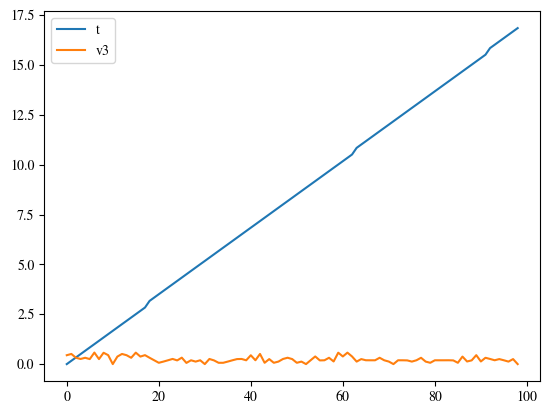

In [4]:
df.sort_values(by="t").plot()

(0.0, 6.0)

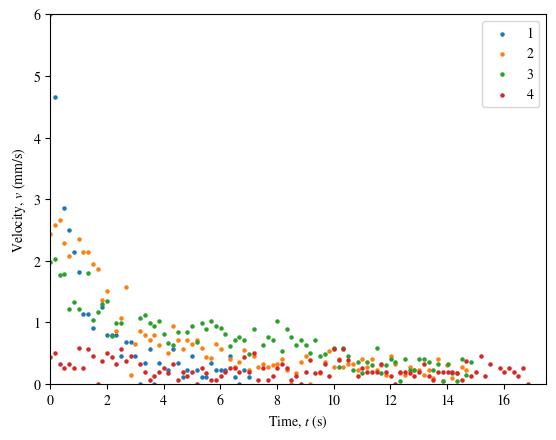

In [ ]:
for key in dfall:
    plt.scatter(dfall.index, dfall[key], s=5)
plt.legend([1,2,3,4])
plt.xlabel("Time, $t$ (s)")
plt.ylabel("Velocity, $v$ (mm/s)")
plt.xlim([0,17.5])
plt.ylim([0,6])

(0.0, 3.0)

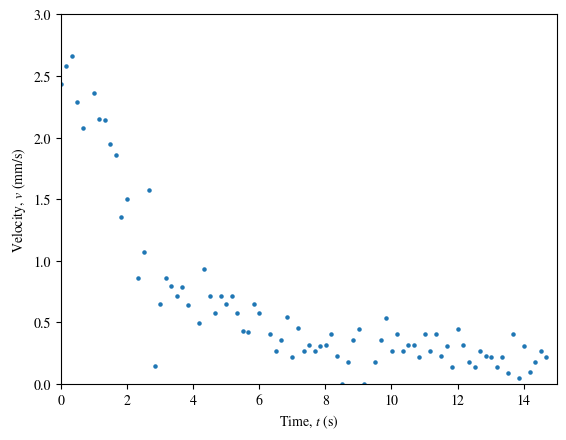

In [9]:
plt.scatter(dfall.index, dfall["v1"], s=5)
plt.xlabel("Time, $t$ (s)")
plt.ylabel("Velocity, $v$ (mm/s)")
plt.xlim([0, 15])
plt.ylim([0, 3])

In [55]:
v1_sm+std

0
t               
0.000        NaN
0.167        NaN
0.333        NaN
0.500        NaN
0.667   2.311723
...          ...
14.014  0.461144
14.181  0.254626
14.347  0.330157
14.514  0.381036
14.681  0.304737

[84 rows x 1 columns]

In [61]:
v1_sm.values.shape

(84, 1)

(0.0, 3.0)

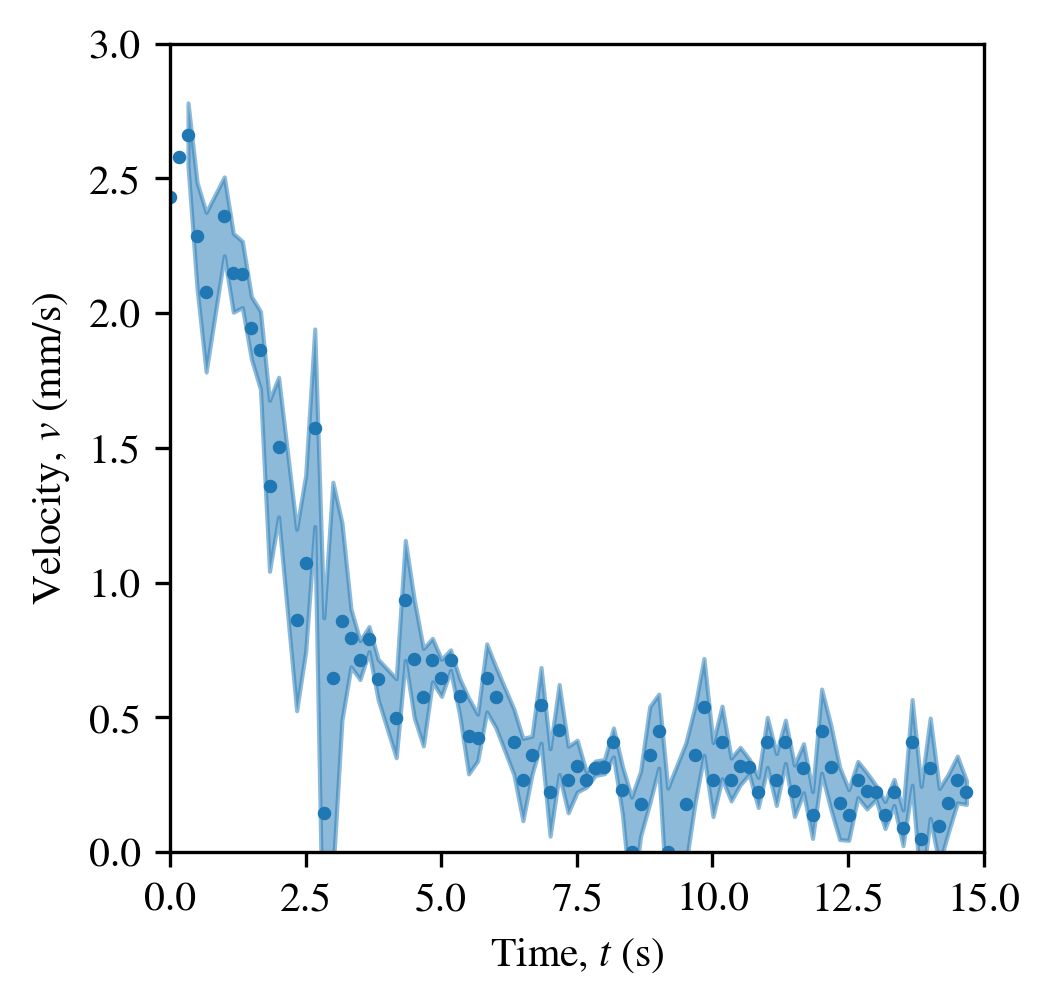

In [74]:
plt.figure(figsize=(3.5, 3.5), dpi=300)
v1 = dfall["v1"].dropna().sort_index()
v = v1.values
t = v1.index
v_sm = medfilt(v, 1)
v1_sm = pd.DataFrame(data=v_sm, index=t)
std = v1_sm.rolling(window=3).std()
plt.scatter(v1_sm.index, v1_sm, s=5)
plt.fill_between(v1_sm.index, np.array(v1_sm-std).squeeze(), np.array(v1_sm+std).squeeze(), color=bestcolor(0), alpha=0.5)
plt.xlabel("Time, $t$ (s)")
plt.ylabel("Velocity, $v$ (mm/s)")
plt.xlim([0, 15])
plt.ylim([0, 3])

### 3.2 Spatial variation

## 4 Surface profile analysis

With the more time-resolved surface profile measurements, we gain better understanding of the dimple formation. To obtain more quantitative understanding, we want to analyze the surface profiles by extracting characteristic quantities at various time. Specifically, we are going to look at how film thickness and curvature change over time. 

The resulting data will be saved in a subfolder "dimple_detection", where .csv files of the same name as the surface profile data file will be created. In there, we are going to have a datasheet comprising dimple location, dimple height, apex location, apex height, dimple curvature, apex curvature, and mean surface height. 

### 4.1 Experimental data

The code in this section is designed for experimental data. There are several distinctions between experimental and simulation data. As a result, we need to develope different code to process them, although the outcome data share a common structure. The distinctions are
- only half of the surface scans is useful, due to the asymmetry between forward and backward scans. Therefore, when looping over the scans, we always use the subset `scans[1::2]`;
- experimental data is much noisier than the simulation data, so smoothing is necessary before looking for local minima and maxima;
- there could be detection errors close to the beginning and the end of the scans, primarily due to the large slope of the liquid surface. These errors can result in unphysical peaks and valleys which confuses our code. To solve that, we need to exclude certain range near both ends. 

The code in the following block will consider all these special considerations for the experimental data, and extract datasheets that characterize the surface profile evolution.

In [337]:
### set parameters here ##############################
folder = r"G:\My Drive\Research projects\WPM\Data\10252024\surface_profile"
exclude = 30
######################################################

dimple_folder = os.path.join(folder, "dimple_detection")
if os.path.exists(dimple_folder) == False:
    print("Dimple folder does not exist, creating ...")
    os.makedirs(dimple_folder)
l = readdata(folder, "csv")

# loop through each surface profile data
for num, i in l.iterrows():
    # read the surface profile data
    df = pd.read_csv(i.Dir).set_index("x")
    # initialize lists to store minima and maxima
    t_list = []
    minima_list = []
    maxima_list = []
    minima_index_list = []
    maxima_index_list = []
    curvature_minima = []
    curvature_maxima = []
    mean_surface_height_list = []

    # infer the max time from the column names, for coloring the curves
    tmax = float(df.columns[-1])
    cmap = plt.get_cmap("viridis")
    
    j = 0
    
    for kw in df.columns[1::2]:
        # infer time
        t = float(kw)

        # read surface profile data for smoothing purpose
        x, y = df.index, df[kw].values

        # smooth the curve with a Butterworth low-pass filter
        order = 4
        cutoff_frequency = 0.03  # Normalized cutoff frequency (0 to 0.5)
        b, a = butter(order, cutoff_frequency, btype='low', analog=False)

        # Apply the filter to the data
        y_filtered = filtfilt(b, a, y)

        # compute the second derivative
        dy = np.gradient(y_filtered, x)
        d2y = np.gradient(dy, x)

        # Find local minima in the filtered data, exclude the first last points
        minima_indices = argrelextrema(y_filtered[exclude:-exclude], np.less)
        maxima_indices = argrelextrema(y_filtered[exclude:-exclude], np.greater)

        # record the data
        t_list.append(t)
        # it could be the case that there is no minima or maxima. In such cases, we record np.nan in the place.
        if len(minima_indices[0]) > 0:
            minima_index = int(minima_indices[0][0]+exclude)
            minima_index_list.append(minima_index)
            minima_list.append(y[minima_index])
            curvature_minima.append(d2y[minima_index])
        else:
            minima_list.append(np.nan)
            minima_index_list.append(np.nan)
            curvature_minima.append(np.nan)
        if len(maxima_indices[0]) > 0:   
            maxima_index = int(maxima_indices[0][0]+exclude)
            maxima_index_list.append(maxima_index)   
            maxima_list.append(y[maxima_index])
            curvature_maxima.append(d2y[maxima_index])
        else:
            maxima_list.append(np.nan)
            maxima_index_list.append(np.nan)
            curvature_maxima.append(np.nan)
        mean_surface_height_list.append(y.mean())

    # generate a report for each dimple detection
    fig, ax = plt.subplots(2, 2, figsize=(7,6), dpi=300)

    # plot the surface profile
    # down sample the data for plotting
    for kw in df.columns[1::2]:
        # read surface profile data for smoothing purpose
        x, y = df.index, df[kw].values

        # smooth the curve with a Butterworth low-pass filter
        order = 4
        cutoff_frequency = 0.03  # Normalized cutoff frequency (0 to 0.5)
        b, a = butter(order, cutoff_frequency, btype='low', analog=False)

        # Apply the filter to the data
        y_filtered = filtfilt(b, a, y)

        ax[0][0].plot(x, y, color=cmap(float(kw)/tmax), lw=1, alpha=.5)
        ax[0][0].plot(x, y_filtered, color=cmap(float(kw)/tmax), lw=2)

    ax[0][0].set_xlim([0, df.index[-1]])
    ax[0][0].set_ylim([0, df.max().max()])
    ax[0][0].set_xlabel("Distance, $x$ (mm)")
    ax[0][0].set_ylabel("Surface height, $h$ (mm)")

    # label the minima and maxima points on the surface profile
    for minima_index, minima in zip(minima_index_list[1::2], minima_list[1::2]):
        if np.isnan(minima_index):
            continue
        ax[0][0].scatter(df.index[minima_index], minima, color="blue", s=5, zorder=10)
    for maxima_index, maxima in zip(maxima_index_list[1::2], maxima_list[1::2]):
        if np.isnan(maxima_index):
            continue
        ax[0][0].scatter(df.index[maxima_index], maxima, color="red", s=5, zorder=10)
    
    # plot minima and maxima
    ax[0][1].plot(t_list, minima_list, color="blue", lw=2)
    ax[0][1].plot(t_list, maxima_list, color="red", lw=2)
    ax[0][1].set_xlim([0, tmax])
    ax[0][1].set_ylim([0, df.max().max()])
    ax[0][1].set_xlabel("Time, $t$ (s)")
    ax[0][1].set_ylabel("Surface height, $h$ (mm)")

    # plot mean surface height vs. time
    ax[1][0].plot(t_list, mean_surface_height_list, color="black", lw=2)
    ax[1][0].set_xlim([0, tmax])
    ax[1][0].set_ylim([0, df.max().max()])
    ax[1][0].set_xlabel("Time, $t$ (s)")
    ax[1][0].set_ylabel("Mean surface height, $h_{mean}$ (mm)")

    # plot curvatures at minima and maxima
    ax[1][1].plot(t_list, curvature_minima, color="blue", lw=2)
    ax[1][1].plot(t_list, curvature_maxima, color="red", lw=1)
    ax[1][1].set_xlim([0, tmax])
    ax[1][1].set_ylim([-0.1, 0.1])
    ax[1][1].set_xlabel("Time, $t$ (s)")
    ax[1][1].set_ylabel("Curvature, $\kappa$ (mm$^{-1}$)")

    # save dimple data to file
    dimple = pd.DataFrame(data={"t": t_list, 
                                "minima": minima_list, 
                                "maxima": maxima_list, 
                                "minima_index": minima_index_list, 
                                "maxima_index": maxima_index_list,
                                "curvature_minima": curvature_minima,
                                "curvature_maxima": curvature_maxima,
                                "mean_surface_height": mean_surface_height_list})
    dimple.to_csv(os.path.join(dimple_folder, i.Name+".csv"), index=False)
    plt.tight_layout()
    fig.savefig(os.path.join(dimple_folder, i.Name+".jpg"), bbox_inches="tight")
    plt.close(fig)

Dimple folder does not exist, creating ...


**Plot film thickness and dimple curvature**

In [115]:
data = pd.read_csv(r"F:\WPM\08212024\surface_profile\dimple_detection\beetjuice_2_0.8.csv")
# data = data[::2]

(0.0, 120.0)

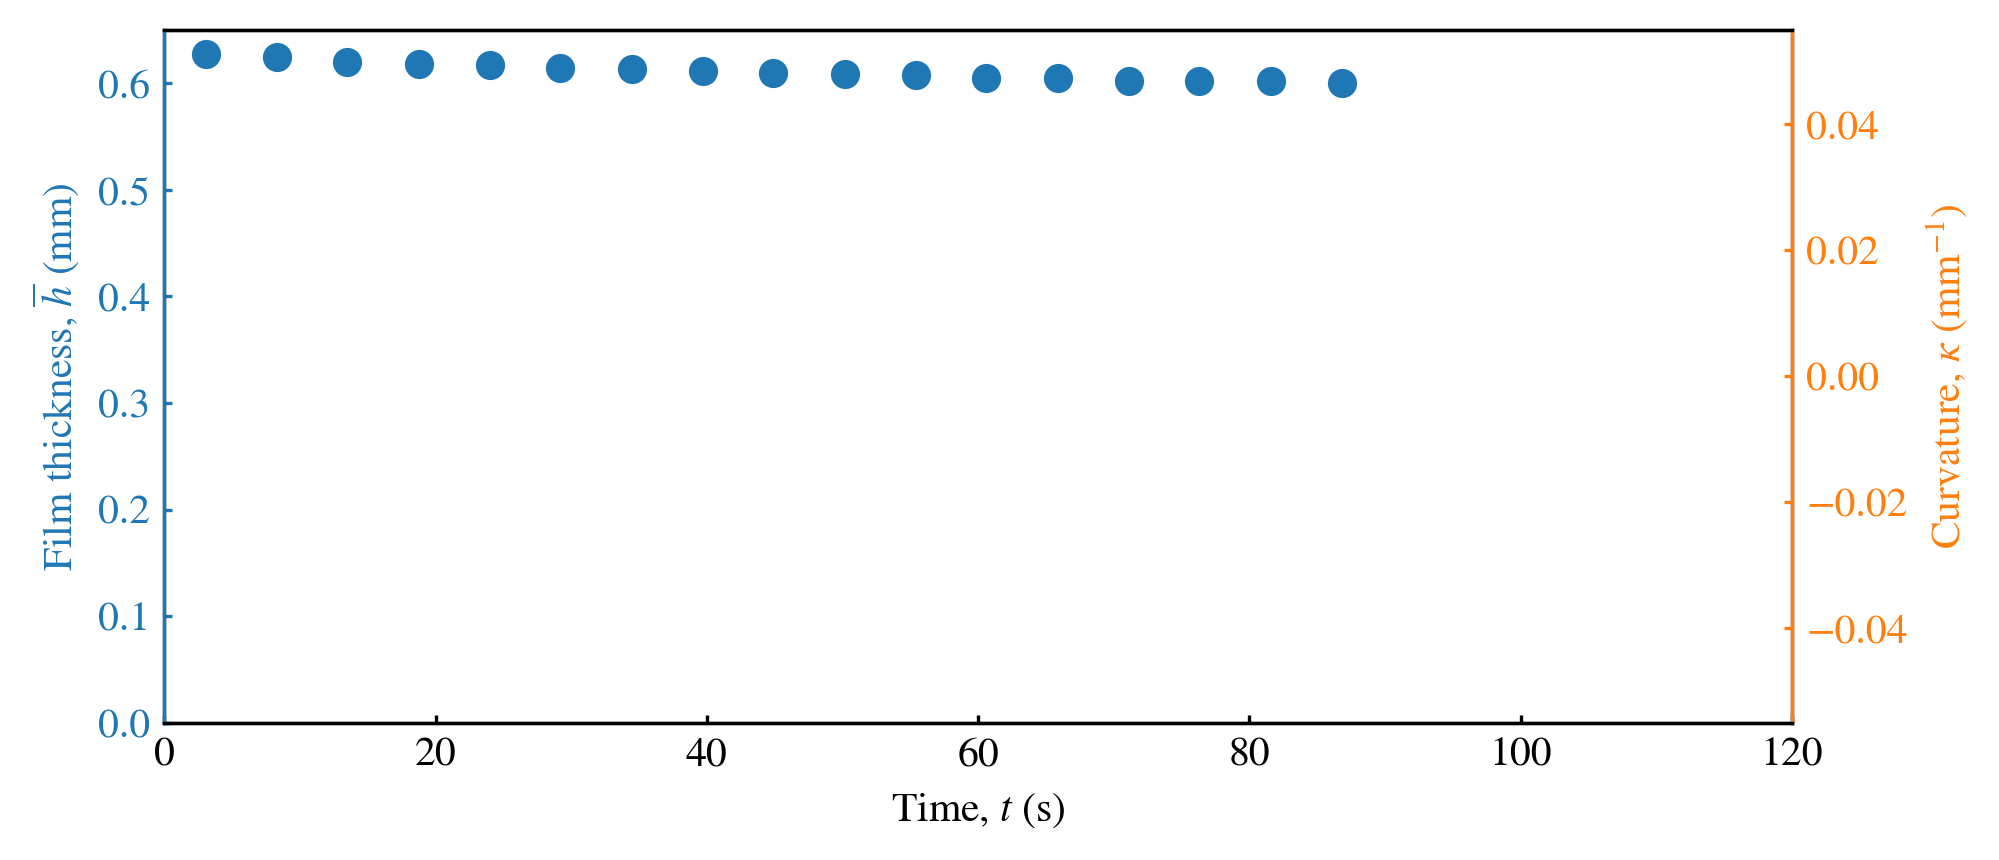

In [119]:
# do a yy plot with surface height and curvature_minima
fig, ax = plt.subplots(figsize=(7, 3), dpi=300)
ax.plot(data["t"], data["mean_surface_height"], color=bestcolor(0), ls="", marker="o")

ax.yaxis.set_tick_params(color=bestcolor(0), labelcolor=bestcolor(0))
ax.set_xlabel("Time, $t$ (s)")
ax.set_ylabel("Film thickness, $\overline{h}$ (mm)", color=bestcolor(0))
ax.set_ylim([0, 0.65])

ax1 = ax.twinx()
ax1.spines['left'].set_color(bestcolor(0))
ax1.spines['right'].set_color(bestcolor(1))
ax1.yaxis.set_tick_params(color=bestcolor(1), labelcolor=bestcolor(1))
ax1.plot(data["t"], data["curvature_minima"], color=bestcolor(1), ls="", marker="o")
ax1.set_ylabel("Curvature, $\kappa$ (mm$^{-1}$)", color=bestcolor(1))
ax1.set_xlim([0, 120])
# ax1.set_ylim([0, 0.5])


### 4.2 Simulation data

The processing of simulation data is essentially the same as the experimental data. However, due to the simulation data being much smoother, some preprocessing can be skipped, including the smoothing, the excluding near ends, and the skipping sampling.

In [117]:
### set parameters here ##############################
folder = r"G:\My Drive\Research projects\WPM\Data\Simulation\meniscus_suction"
######################################################

dimple_folder = os.path.join(folder, "dimple_detection")
if os.path.exists(dimple_folder) == False:
    print("Dimple folder does not exist, creating ...")
    os.makedirs(dimple_folder)
l = readdata(folder, "csv")

# loop through each surface profile data
for num, i in l.iterrows():
    # read the surface profile data
    df = pd.read_csv(i.Dir).set_index("x")
    # initialize lists to store minima and maxima
    t_list = []
    minima_list = []
    maxima_list = []
    minima_index_list = []
    maxima_index_list = []
    curvature_minima = []
    curvature_maxima = []
    mean_surface_height_list = []

    # infer the max time from the column names, for coloring the curves
    tmax = float(df.columns[-1])
    cmap = plt.get_cmap("viridis")
    
    j = 0
    
    for kw in df:
        # infer time
        t = float(kw)

        # read surface profile data for smoothing purpose
        x, y = df.index, df[kw].values


        # compute the second derivative
        dy = np.gradient(y, x)
        d2y = np.gradient(dy, x)

        # Find local minima in the filtered data, exclude the first last points
        minima_indices = argrelextrema(y, np.less)
        maxima_indices = argrelextrema(y, np.greater)

        # record the data
        t_list.append(t)
        # it could be the case that there is no minima or maxima. In such cases, we record np.nan in the place.
        if len(minima_indices[0]) > 0:
            minima_index = int(minima_indices[0][0])
            minima_index_list.append(minima_index)
            minima_list.append(y[minima_index])
            curvature_minima.append(d2y[minima_index])
        else:
            minima_list.append(np.nan)
            minima_index_list.append(np.nan)
            curvature_minima.append(np.nan)
        if len(maxima_indices[0]) > 0:   
            maxima_index = int(maxima_indices[0][0])
            maxima_index_list.append(maxima_index)   
            maxima_list.append(y[maxima_index])
            curvature_maxima.append(d2y[maxima_index])
        else:
            maxima_list.append(np.nan)
            maxima_index_list.append(np.nan)
            curvature_maxima.append(np.nan)
        mean_surface_height_list.append(y.mean())

    # generate a report for each dimple detection
    fig, ax = plt.subplots(2, 2, figsize=(7,6), dpi=300)

    # plot the surface profile
    # down sample the data for plotting
    down_sample = 50
    for kw in df.columns[25::down_sample]:
        # read surface profile data for smoothing purpose
        x, y = df.index, df[kw].values

        ax[0][0].plot(x, y, color=cmap(float(kw)/tmax), lw=2)

    ax[0][0].set_xlim([0, df.index[-1]])
    ax[0][0].set_ylim([0, df.max().max()])
    ax[0][0].set_xlabel("Distance, $x$ (mm)")
    ax[0][0].set_ylabel("Surface height, $h$ (mm)")

    # label the minima and maxima points on the surface profile
    for minima_index, minima in zip(minima_index_list[25::down_sample], minima_list[25::down_sample]):
        if np.isnan(minima_index):
            continue
        ax[0][0].scatter(df.index[minima_index], minima, color="blue", s=5, zorder=10)
    for maxima_index, maxima in zip(maxima_index_list[25::down_sample], maxima_list[25::down_sample]):
        if np.isnan(maxima_index):
            continue
        ax[0][0].scatter(df.index[maxima_index], maxima, color="red", s=5, zorder=10)
    
    # plot minima and maxima
    ax[0][1].plot(t_list, minima_list, color="blue", lw=2)
    ax[0][1].plot(t_list, maxima_list, color="red", lw=2)
    ax[0][1].set_xlim([0, tmax])
    ax[0][1].set_ylim([0, df.max().max()])
    ax[0][1].set_xlabel("Time, $t$ (s)")
    ax[0][1].set_ylabel("Surface height, $h$ (mm)")

    # plot mean surface height vs. time
    ax[1][0].plot(t_list, mean_surface_height_list, color="black", lw=2)
    ax[1][0].set_xlim([0, tmax])
    ax[1][0].set_ylim([0, df.max().max()])
    ax[1][0].set_xlabel("Time, $t$ (s)")
    ax[1][0].set_ylabel("Mean surface height, $h_{mean}$ (mm)")

    # plot curvatures at minima and maxima
    ax[1][1].plot(t_list, curvature_minima, color="blue", lw=2)
    ax[1][1].plot(t_list, curvature_maxima, color="red", lw=1)
    ax[1][1].set_xlim([0, tmax])
    ax[1][1].set_ylim([-0.1, 0.1])
    ax[1][1].set_xlabel("Time, $t$ (s)")
    ax[1][1].set_ylabel("Curvature, $\kappa$ (mm$^{-1}$)")

    # save dimple data to file
    dimple = pd.DataFrame(data={"t": t_list, 
                                "minima": minima_list, 
                                "maxima": maxima_list, 
                                "minima_index": minima_index_list, 
                                "maxima_index": maxima_index_list,
                                "curvature_minima": curvature_minima,
                                "curvature_maxima": curvature_maxima,
                                "mean_surface_height": mean_surface_height_list})
    dimple.to_csv(os.path.join(dimple_folder, i.Name+".csv"), index=False)
    plt.tight_layout()
    fig.savefig(os.path.join(dimple_folder, i.Name+".jpg"), bbox_inches="tight")
    plt.close(fig)

Dimple folder does not exist, creating ...


C:\Users\zl948\AppData\Local\Temp\ipykernel_104728\3956691187.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[0][1].set_xlim([0, tmax])
C:\Users\zl948\AppData\Local\Temp\ipykernel_104728\3956691187.py:107: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[1][0].set_xlim([0, tmax])
C:\Users\zl948\AppData\Local\Temp\ipykernel_104728\3956691187.py:115: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[1][1].set_xlim([0, tmax])
C:\Users\zl948\AppData\Local\Temp\ipykernel_104728\3956691187.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[0][1].set_xlim([0, tmax])
C:\Users\zl948\AppData\Local\Temp\ipykernel_104728\3956691187.py:107: UserWarning: Attempting to set identical low and high xlims ma

### 4.3 Dimple lifetime

#### 4.3.1 Height ratio definition

Ideally, we want to use the time it takes for the dimple detection result to transition from numbers to nan, to evaluate dimple lifetime. However, we observe from the data that such transition is rare. Instead, most local minima exist through out the 100-second measurement, despite that these local minima are almost a flat line. This makes using the existence of local minima as the indicator of dimple a bad idea. 

A closer look at the data suggests that we can use the height ratio between maxima and minima as the indicator of dimple (or more precisely, the appearance of visual fringe). The reason is that to observe the fringe, it requires sufficient contrast in the dimple region as opposed to the rest of the film. 

In this section, we measure this ratio and decide a threshold, which will be used to characterize the lifetime of dimple.

**Plot the height ratio over time**

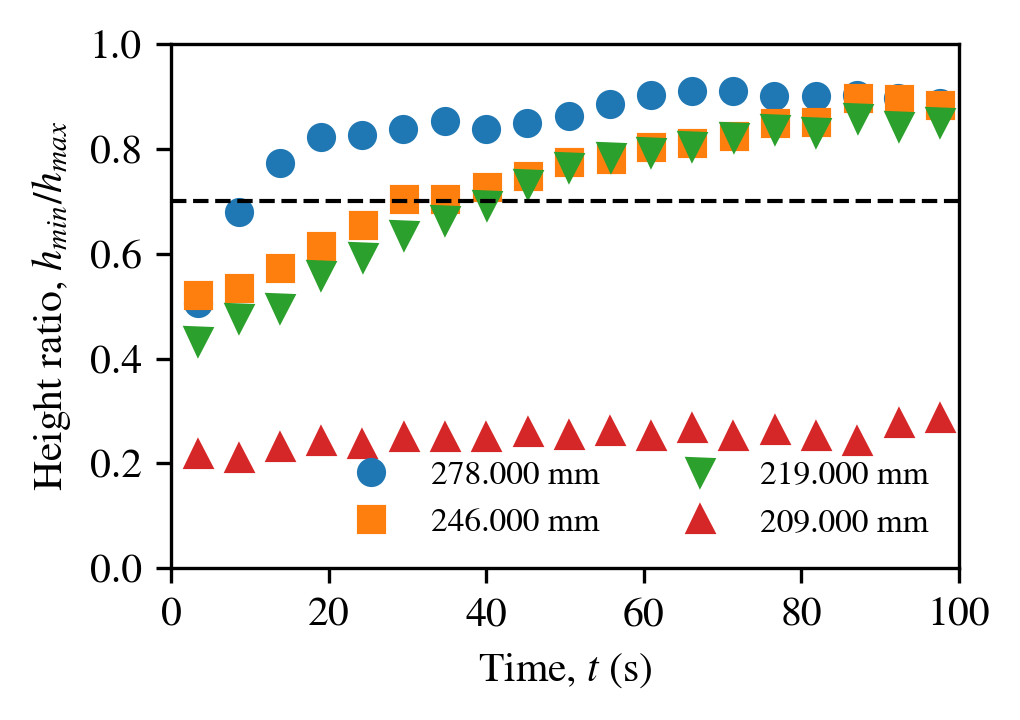

In [65]:
# read dimple data
# initial thickness for 0808 / 3-2 3-3 3-4 3-5
initial_thickness = [0.278, 0.246, 0.219, 0.209]
dimple_folder = r"E:\WPM\08082024\dimple_detection"
l = ["beet_juice_3_2.csv", "beet_juice_3_3.csv", "beet_juice_3_4.csv", "beet_juice_3_5.csv"]
markers = ["o", "s", "v", "^"]
fig, ax = plt.subplots(figsize=(3.5,2.5), dpi=300)
cmap = plt.get_cmap("tab10")
for i in range(len(initial_thickness)):
    dimple = pd.read_csv(os.path.join(dimple_folder, l[i]))
    ax.plot(dimple["t"], dimple["minima"] / dimple["maxima"], ls="", marker=markers[i],
    color=cmap(i), label="{:.3f} mm".format(initial_thickness[i]*1e3))
ax.legend(frameon=False, fontsize=8, loc="lower right", ncol=2)
ax.set_xlabel("Time, $t$ (s)")
ax.set_ylabel("Height ratio, $h_{min}/h_{max}$")
ax.set_xlim([0, 100])
ax.set_ylim([0, 1])
# plot a line at y = 0.7
ax.axhline(0.7, color="black", ls="--", lw=1)
# tight layout
plt.tight_layout()



**Define dimple time by threshold height ratio**

In [66]:
# find the time when the height ratio is 0.7
t_list = []
for i in range(len(initial_thickness)):
    dimple = pd.read_csv(os.path.join(dimple_folder, l[i]))
    # handle the case when dimple["maxima"] > 0.7 is never satisfied
    ts = dimple.loc[dimple["minima"] / dimple["maxima"] > 0.7, "t"]
    if len(ts) != 0:
        t = ts.iloc[0]
    else:
        t = 100
    t_list.append(t)
    print("Initial thickness {:.3f} mm: dimple time {:.3f} s".format(initial_thickness[i]*1e3, t))

Initial thickness 278.000 mm: dimple time 13.800 s
Initial thickness 246.000 mm: dimple time 29.600 s
Initial thickness 219.000 mm: dimple time 45.300 s
Initial thickness 209.000 mm: dimple time 100.000 s


**Simulation dimple time batch process**

In [118]:
folder = r"G:\My Drive\Research projects\WPM\Data\Simulation\meniscus_suction\dimple_detection"
l = readdata(folder, "csv")
dimple_time_list = []
for num, i in l.iterrows():
    # analyze file name
    fields = i.Name.split("_")
    tmp = {}
    for j in range(0, len(fields), 2):
        tmp[fields[j]] = fields[j+1]
    # read dimple data
    dimple = pd.read_csv(i.Dir)
    # compute dimple time
    # Step 1. Look for dimple, where minima / maxima < 0.5
    ts = dimple.loc[dimple["minima"] / dimple["maxima"] <= 0.5, "t"]
    if len(ts) != 0:
        t = ts.iloc[-1]
    else:
        t = np.nan
    dimple_time_list.append(tmp | {"t": t})

dimple_time = pd.DataFrame(dimple_time_list)
dimple_time.to_csv(os.path.join(folder, "dimple_time.csv"), index=False)

**Plot dimple lifetime as a function of initial thickness**

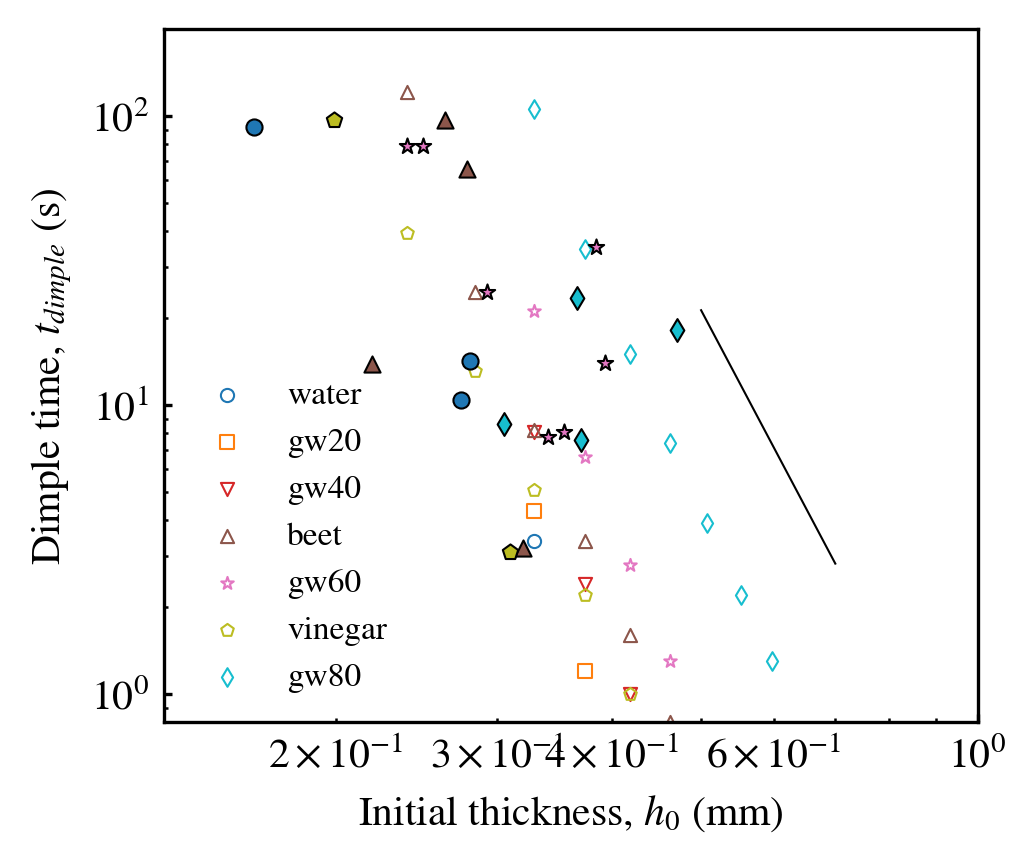

In [343]:
from matplotlib.ticker import ScalarFormatter
dimple_time = pd.read_csv(r"G:\My Drive\Research projects\WPM\Data\dimple_time_height_simulation.csv")
# filter out the data where dimple time is not accurately detected
dimple_time = dimple_time.loc[(dimple_time["t"] < 200)&(dimple_time["t"] > 0.1)]
dimple_time = dimple_time.loc[dimple_time["h0"] > 0.2e-3]
dimple_time.sort_values("mu", inplace=True)
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)

liquids = dimple_time["liquid"].unique()
cmap = plt.get_cmap("tab10", len(liquids))
cmapi = [cmap(i) for i in range(len(liquids))]
markers = ["o", "s", "v", "^", "*", "p", "d"]
cm_map = {}
for liquid, color, marker in zip(liquids, cmapi, markers):
    cm_map[liquid] = (color, marker)
for liquid in liquids:
    g = dimple_time.loc[dimple_time["liquid"] == liquid]
    color, marker = cm_map[liquid]
    ax.scatter(g["h0"]*1e3, g["t"], s=10, lw=.5, marker=marker, facecolor=(0,0,0,0), edgecolor=color, label=f"{liquid}")
ax.loglog()

ax.set_xlabel("Initial thickness, $h_0$ (mm)")
ax.set_ylabel("Dimple time, $t_{dimple}$ (s)")

ax.set_xlim([0.13, 1])
ax.set_ylim([.8, 200])
ax.legend(frameon=False, fontsize=8, loc="lower left")

# experimental data
dimple_exp = pd.read_csv(r"G:\My Drive\Research projects\WPM\Data\dimple_time_height.csv")
dimple_exp = dimple_exp.loc[dimple_exp["t"] < 100]
liquids = dimple_exp["liquid"].unique()
for liquid in liquids:
    g = dimple_exp.loc[dimple_exp["liquid"] == liquid]
    color, marker = cm_map[liquid]
    ax.scatter(g["h0"], g["t"], s=15, lw=.5, marker=marker, facecolor=color, edgecolor="black", label=f"{liquid}")

# Draw a line to eye-ball the power law
x = np.linspace(0.5, 0.7, 100)
y = x**-6 / 3
plt.plot(x, y, color="black", ls="-", lw=.5)
# savefig
#plt.tight_layout()
#fig.savefig(r"E:\WPM\Simulation\Scan_initial_thickness\dimple_detection\dimple_time.pdf")

**Experiment dimple time batch process**

In [338]:
folder = r"G:\My Drive\Research projects\WPM\Data\10252024\surface_profile\dimple_detection"
name_list, h_list, t_list = [], [], []
l = readdata(folder, "csv")
for num, i in l.iterrows():
    # thickness is read from file name after the last _
    fields = i.Name.split("_")
    name, thickness = "_".join(fields[:-2]), fields[-1]
    # print the file name
    print(name, thickness)
    # read dimple data
    dimple = pd.read_csv(i.Dir)
    # compute dimple time
    # handle the case when dimple["maxima"] > 0.7 is never satisfied
    ts = dimple.loc[dimple["minima"] / dimple["maxima"] <= 0.5, "t"]
    if len(ts) != 0:
        t = ts.iloc[-1]
    else:
        t = np.nan
    name_list.append(name)
    h_list.append(thickness)
    t_list.append(t)
    
dimple_time = pd.DataFrame(data={"name": name_list, "h0": h_list, "t": t_list})
dimple_time.to_csv(os.path.join(folder, "dimple_time.csv"), index=False)

 0.251
 0.305
 0.375
 0.347
 0.415
 0.270
 0.370
 0.260
 0.366
 0.480
 0.429
 0.311
 0.367
 0.370
 0.232
 0.471
 0.444
 0.303


**Dimple time vs. initial thickness, compare with simulation**

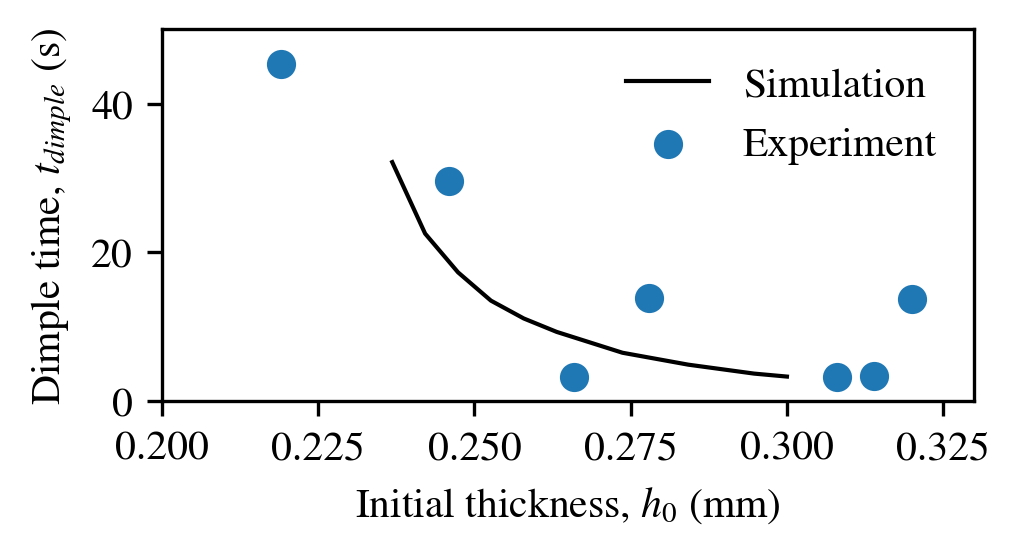

In [56]:
# simplify the plot, show only experiment with beet juice and the simulation with Pi0 = -40 and A_p = 4e-4
fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300)
markers = ["o", "s", "v", "^", "*"]
cmap = plt.get_cmap("viridis")
ga = dimple_time.loc[(dimple_time["Pi0"] == -40) & (dimple_time["area"] == 4e-4)]
ax.plot(ga["h0"]*1e3, ga["t"], color="black", lw=1, label="Simulation")

# experimental data
dimple_exp = pd.read_csv(r"E:\WPM\08082024\dimple_detection\dimple_time.csv").dropna()
ax.scatter(dimple_exp["h0"], dimple_exp["t"], marker="o", label="Experiment")

ax.set_xlabel("Initial thickness, $h_0$ (mm)")
ax.set_ylabel("Dimple time, $t_{dimple}$ (s)")
ax.set_xlim([0.2, 0.330])
ax.set_ylim([0, 50])
ax.legend(frameon=False)

plt.tight_layout()
fig.savefig(r"G:\My Drive\Pictures\dimple_time_sim.pdf")

**Dimple time vs. initial thickness, compare different fluids**

#### 4.3.2 Curvature definition

Although the height ratio method of measuring dimple lifetime correlates closely with the visual fringe, it is not the best representation of the dimple because when the film is thick, dimple can exist when the height ratio is close to 1. To eliminate the influence of film thickness, we here use the curvature difference as the indicator of dimple. 


**Determine dimple time**

In [149]:
# look for dimple time, defined as the time point where curvature difference drops below 0.05 mm^{-1}
dimple_folder = r"G:My Drive\Research projects\WPM\Data\08082024\surface_profile\dimple_detection"
l1 = readdata(dimple_folder, "csv")
dimple_folder = r"G:My Drive\Research projects\WPM\Data\08212024\surface_profile\dimple_detection"
l2 = readdata(dimple_folder, "csv")

dt_list = []
filename_list = []
for num, i in pd.concat([l1, l2]).iterrows():
    dimple = pd.read_csv(i.Dir)
    # find the first time where dimple.curvature_difference drops below 0.05
    dimple_time = dimple.loc[dimple["curvature_minima"] < 0.05, "t"]
    filename_list.append(i.Name)
    if len(dimple_time) > 0:
        dt_list.append(dimple_time.iloc[0])
    else:
        dt_list.append(np.nan)

In [150]:
h0_list = []
liquid_list = []
for filename in filename_list:
    if filename.startswith("beet"):
        h0_list.append(float(filename.split("_")[-1]))
        liquid_list.append("beet")
    elif filename.startswith("vinegar"):
        h0_list.append(float(filename.split("_")[-1]))
        liquid_list.append("vinegar")
    else:
        h0_list.append(float(filename.split("_")[-1]))
        liquid_list.append("water")

In [151]:
dimple_time_df = pd.DataFrame(data={"filename": filename_list, "h0": h0_list, "liquid": liquid_list, "dimple_time": dt_list})

In [153]:
dimple_time_df.to_csv(r"G:My Drive\Research projects\WPM\Data\dimple_time_curvature.csv", index=False)

(0.0, 100.0)

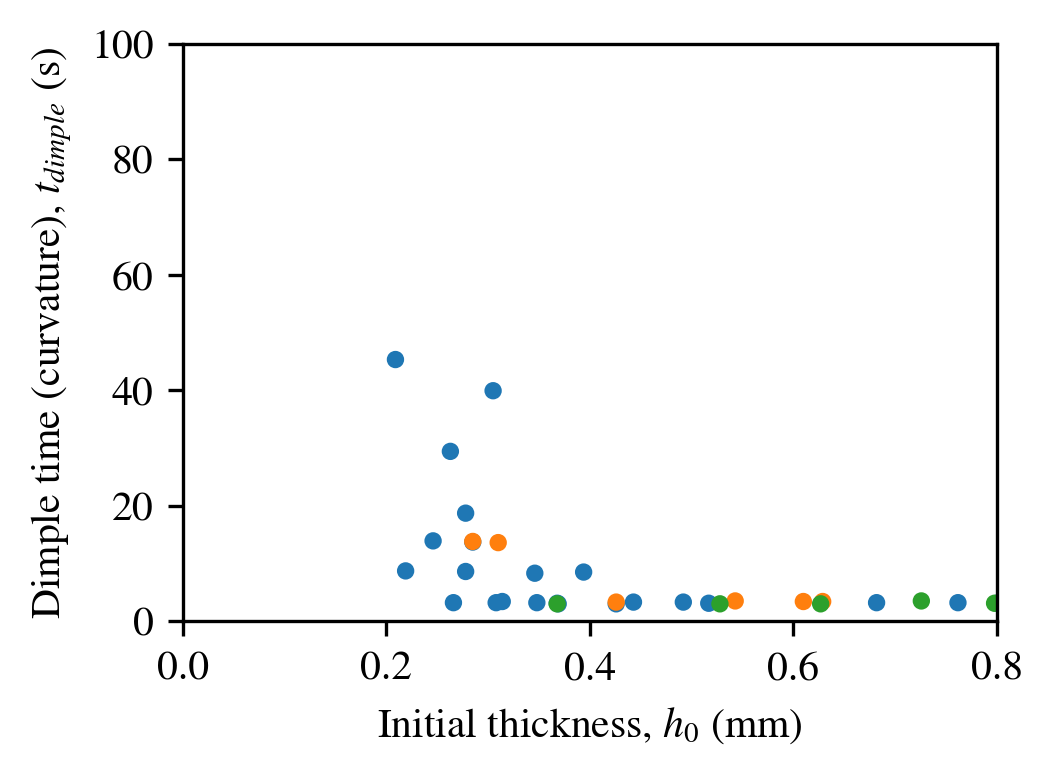

In [152]:
fig, ax = plt.subplots(figsize=(3.5,2.5), dpi=300)
ax.scatter(dimple_time_df["h0"], dimple_time_df["dimple_time"], c=dimple_time_df["liquid"].apply(lambda x: bestcolor(["beet", "vinegar", "water"].index(x))), s=10)
ax.set_xlabel("Initial thickness, $h_0$ (mm)")
ax.set_ylabel("Dimple time (curvature), $t_{dimple}$ (s)")
ax.set_xlim([0, 0.8])
ax.set_ylim([0, 100])

**Plot $\mu$, $\sigma$ simulation**

In [117]:
folder = r"C:\Users\liuzy\Documents\WPM_Simulation\mu_sigma\dimple_detection"
l = readdata(folder, "csv")
dt_list = []
filename_list = []
for num, i in l.iterrows():
    dimple = pd.read_csv(i.Dir)
    # find the first time where dimple.curvature_difference drops below 0.05
    dimple_time = dimple.loc[dimple["curvature_difference"] < 0.05, "t"]
    filename_list.append(i.Name)
    if len(dimple_time) > 0:
        dt_list.append(dimple_time.iloc[0])
    else:
        dt_list.append(np.nan)

In [121]:
mu_list = []
sigma_list = []
h0_list = []
liquid_list = []
for filename in filename_list:
    mu = float(filename.split("_")[1])
    sigma = float(filename.split("_")[3])
    h0 = float(filename.split("_")[5])
    mu_list.append(mu)
    sigma_list.append(sigma)
    h0_list.append(h0)
    if mu == 0.01:
        liquid_list.append("beet")
    elif mu == 0.015:
        liquid_list.append("vinegar")
    else:
        liquid_list.append("water")

In [122]:
dimple_time_simulation_df = pd.DataFrame(data={"filename": filename_list, "mu": mu_list, "sigma": sigma_list, "h0": h0_list, "liquid": liquid_list, "dimple_time": dt_list})
dimple_time_simulation_df.to_csv(os.path.join(r"G:\My Drive\Research projects\WPM\Data", "dimple_time_curvature_simulation.csv"), index=False)

Plot simulation and experiment together.

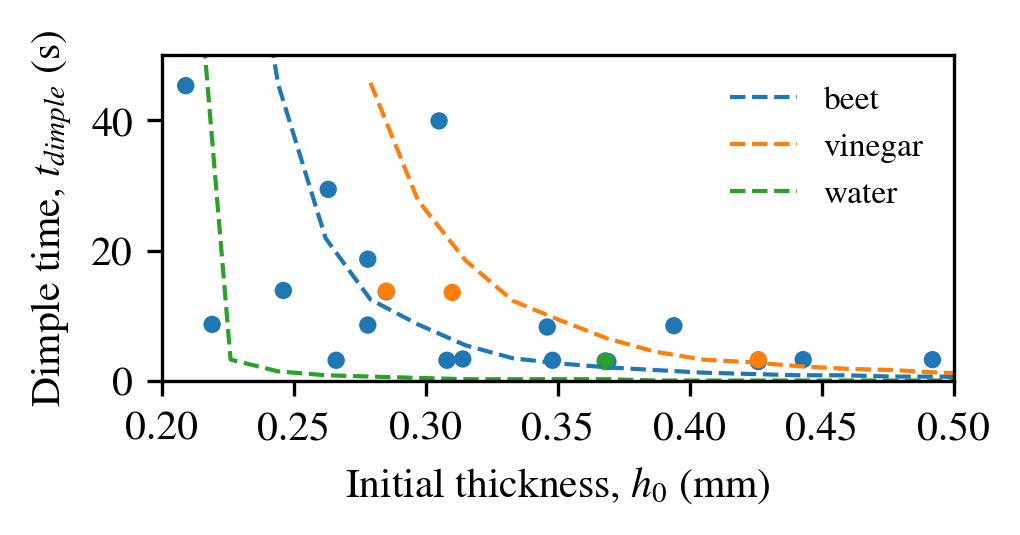

In [303]:
exp = pd.read_csv(r"G:\My Drive\Research projects\WPM\Data\dimple_time_curvature.csv")
sim = pd.read_csv(r"G:\My Drive\Research projects\WPM\Data\dimple_time_curvature_simulation.csv")
fig, ax = plt.subplots(figsize=(3.5,1.8), dpi=300)
ax.scatter(exp["h0"], exp["dimple_time"], c=exp["liquid"].apply(lambda x: bestcolor(["beet", "vinegar", "water"].index(x))), s=10)
colors = {"beet": bestcolor(0), "vinegar": bestcolor(1), "water": bestcolor(2)}
for liquid, gp in sim.groupby("liquid"):
    ax.plot(gp["h0"]*1e3, gp["dimple_time"], color=colors[liquid],label=liquid, ls="--", lw=1)
ax.set_xlabel("Initial thickness, $h_0$ (mm)")
ax.set_ylabel("Dimple time, $t_{dimple}$ (s)")
ax.set_xlim([0.2, 0.5])
ax.set_ylim([0, 50])
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()
fig.savefig(r"G:\My Drive\Pictures\dimple_time_curvature.pdf")
# ax.loglog()

### 4.4 Compare surface tension and viscous drag

In the paper, it is desired that we show the effect of surface tension and viscosity. Ideally, I want to show dimple time, as in the previous figure, as the function of initial thickness. A nice thing about this plot is that both quantities, $t_{dimple}$ and $h_0$, are the most relevant in the fringe observation.

Then we can rescale the initial thickness with surface tension and viscosity, so dimple time collapses. However, a challenge is that the dimple time is arbitrarily defined, and the experimental measurement of dimple time has a very low temporal resolution. As a result, many experiments give 0 or inf dimple time, which would not contribute a data point in the plot. 

As a plan B, we can check the balance between the surface tension pressure and the viscous stress to verify our hypothesis. We start by plotting dimple curvature against dimple height, based on the argument that the height at the dimple is the characteristic length scale that determines the drag. 

[]

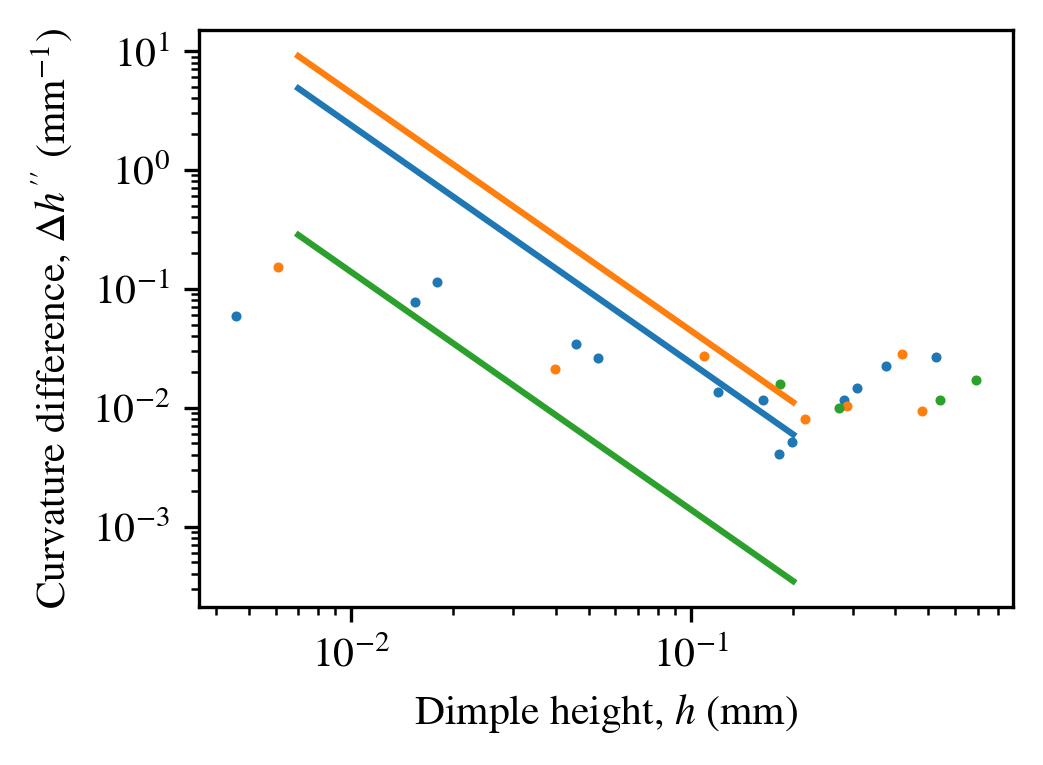

In [368]:
# plot curvature difference vs dimple height
folders = [r"G:My Drive\Research projects\WPM\Data\08212024\surface_profile\dimple_detection"]
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
for folder in folders:
    l = readdata(folder, "csv")
    for num, i in l.iterrows():
        dimple = pd.read_csv(i.Dir).dropna()
        try:
            h = dimple.minima.iloc[-1]
            dc = dimple.curvature_minima.iloc[-1]
        except:
            continue
        if i.Name.startswith("beet"):
            ax.scatter(h, dc, color=bestcolor(0), s=2, label=i.Name)
        elif i.Name.startswith("vinegar"):
            ax.scatter(h, dc, color=bestcolor(1), s=2, label=i.Name)
        else:
            ax.scatter(h, dc, color=bestcolor(2), s=2, label=i.Name)
        # plt.scatter(h, dc, label=i.Name)
# ax.set_xlim([0, 0.3])
ax.set_xlabel("Dimple height, $h$ (mm)")
ax.set_ylabel("Curvature difference, $\Delta h''$ (mm$^{-1}$)")

mu = 0.01
muw = 0.001
muv = 0.012
sigma = 0.042
sigmaw = 0.072
sigmav = 0.027
U = 1e-4
L = 0.01
h = np.linspace(0.007, 0.2, 100) * 1e-3
hppb = mu * U * L / sigma / h**2
hppv = muv * U * L / sigmav / h**2
hppw = muw * U * L / sigmaw / h**2
ax.plot(h*1e3, hppb*1e-3)
ax.plot(h*1e3, hppv*1e-3)
ax.plot(h*1e3, hppw*1e-3)
# ax.set_xlim([0, 0.1])
ax.loglog()
        

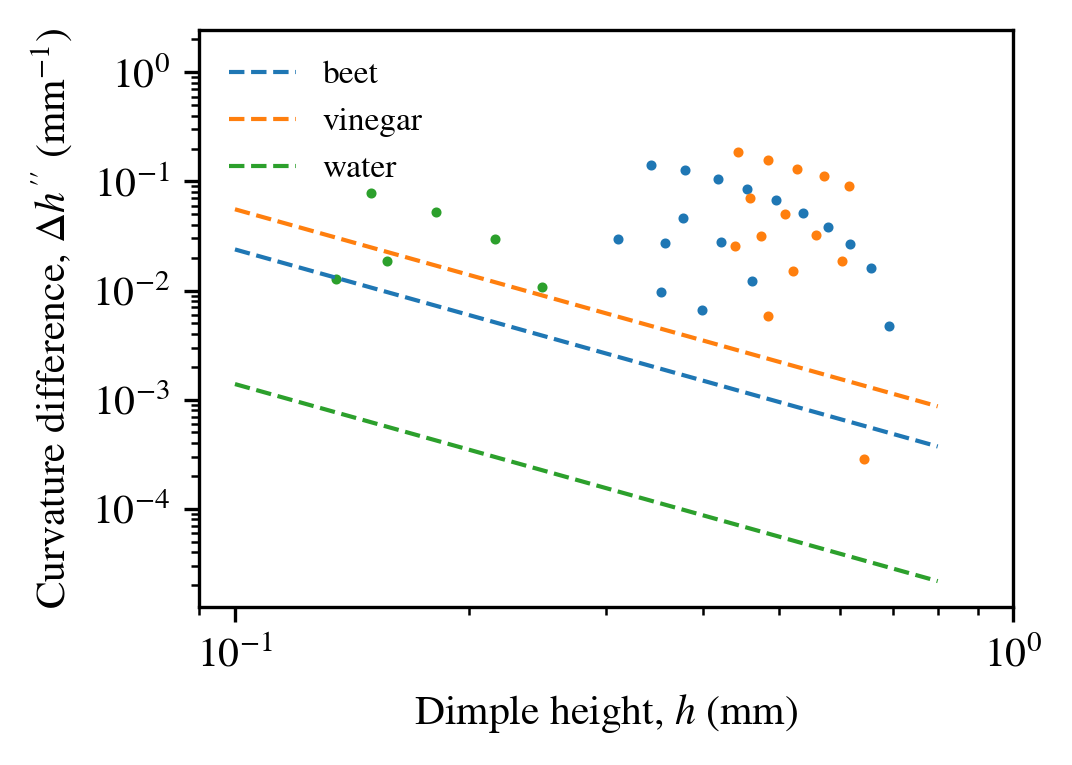

In [367]:
# dimple height and curvature in simulation
folder = r"E:\WPM\Simulation\mu_sigma\dimple_detection"
l = readdata(folder, "csv")
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
for num, i in l.iterrows():
    dimple = pd.read_csv(i.Dir).dropna()
    try:
        h = dimple.minima.iloc[-1]
        dc = dimple.curvature_minima.iloc[-1]
    except:
        continue
    mu = float(i.Name.split("_")[1])
    if mu == 0.01:
        ax.scatter(h, dc, color=bestcolor(0), s=2)
    elif mu == 0.015:
        ax.scatter(h, dc, color=bestcolor(1), s=2)
    else:
        ax.scatter(h, dc, color=bestcolor(2), s=2)
ax.set_xlabel("Dimple height, $h$ (mm)")
ax.set_ylabel("Curvature difference, $\Delta h''$ (mm$^{-1}$)")

mu = 0.01
muw = 0.001
muv = 0.015
sigma = 0.042
sigmaw = 0.072
sigmav = 0.027
U = 1e-4
L = 0.01
h = np.linspace(0.1, 0.8, 100) * 1e-3
hppb = mu * U * L / sigma / h**2 
hppv = muv * U * L / sigmav / h**2 
hppw = muw * U * L / sigmaw / h**2 
ax.plot(h*1e3, hppb*1e-3, lw=1, ls="--", label="beet")
ax.plot(h*1e3, hppv*1e-3, lw=1, ls="--", label="vinegar")
ax.plot(h*1e3, hppw*1e-3, lw=1, ls="--", label="water")
ax.loglog()
ax.set_xlim([.09, 1])
ax.legend(frameon=False, fontsize=8)

### 4.5 Curvature as a function of mean surface height

The resistance of flow may be a result from the whole film, instead of the thinnest region. In this section, we try to plot the curvature of dimple as a function of the mean film height of the liquid. 

In [114]:
# compute mean surface height and save in the dimple_detection folder
folder = r"E:\WPM\Simulation\detail_Pi0_area_small_h0"
dimple_folder = os.path.join(folder, "dimple_detection")
l = readdata(folder, "csv")
for num, i in l.iterrows():
    df = pd.read_csv(i.Dir).set_index("x").iloc[:, 1::2]
    dimple = pd.read_csv(os.path.join(dimple_folder, i.Name+".csv")).set_index("t")
    mean_surface_height = df.mean(axis=0)
    dimple["mean_surface_height"] = mean_surface_height.values
    dimple.to_csv(os.path.join(dimple_folder, i.Name+".csv"))

(0.0, 62500.0)

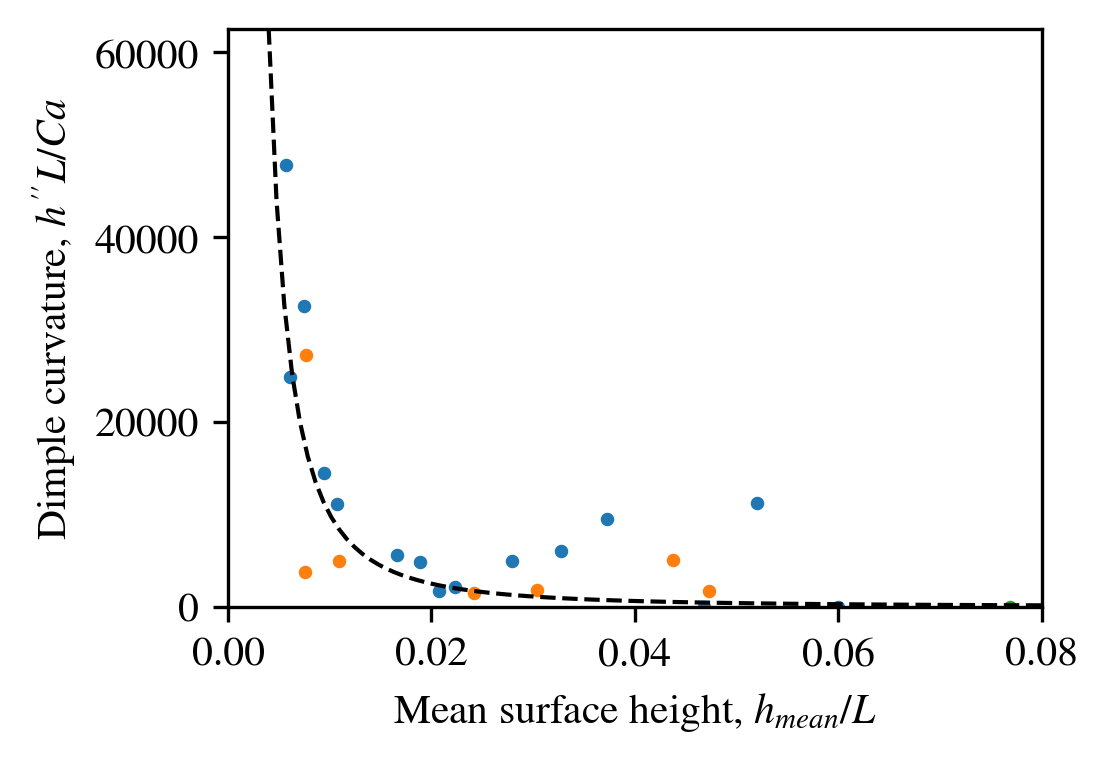

In [366]:
# plot mean surface height vs. curvature
folder = r"G:My Drive\Research projects\WPM\Data\08212024\surface_profile\dimple_detection"
l = readdata(folder, "csv")

L = 0.01
tau = 100
U = L / tau

fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
for num, i in l.iterrows():
    dimple = pd.read_csv(i.Dir)
    if i.Name.startswith("beet"):
        mu = 0.01
        sigma = 0.042
        Ca = mu * U / sigma
        ax.scatter(dimple["mean_surface_height"].iloc[-1]*1e-3/L, dimple["curvature_minima"].iloc[-1]*L*1e3/Ca, color=bestcolor(0), s=5, label=i.Name)
    elif i.Name.startswith("vinegar"):
        mu = 0.015
        sigma = 0.027
        Ca = mu * U / sigma
        ax.scatter(dimple["mean_surface_height"].iloc[-1]*1e-3/L, dimple["curvature_minima"].iloc[-1]*L*1e3/Ca, color=bestcolor(1), s=5, label=i.Name)
    else:
        mu = 0.001
        sigma = 0.072
        Ca = mu * U / sigma
        ax.scatter(dimple["mean_surface_height"].iloc[-1]*1e-3/L, dimple["curvature_minima"].iloc[-1]*L*1e3/Ca, color=bestcolor(2), s=5, label=i.Name)
ax.set_xlabel("Mean surface height, $h_{mean}/L$")
ax.set_ylabel("Dimple curvature, $h''L/Ca$")
# ax.loglog()
x = np.linspace(0.04, 0.8, 100) * 1e-3 / L

y = x**-2
ax.plot(x, y, color="black", ls="--", lw=1)
# ax.legend(["beet", "vinegar", "water"], frameon=False, fontsize=8)
ax.set_xlim([0, x.max()])
ax.set_ylim([0, y.max()])

Here, I plot the dimensionless dimple curvature against dimensionless mean surface height. In the small height limit, these two values correlates well. At larger height, the curvature is higher than expected. I have a feeling that these higher values arise from the noise, but we have to check carefully before claiming.

We can make the same plot for the simulation data.

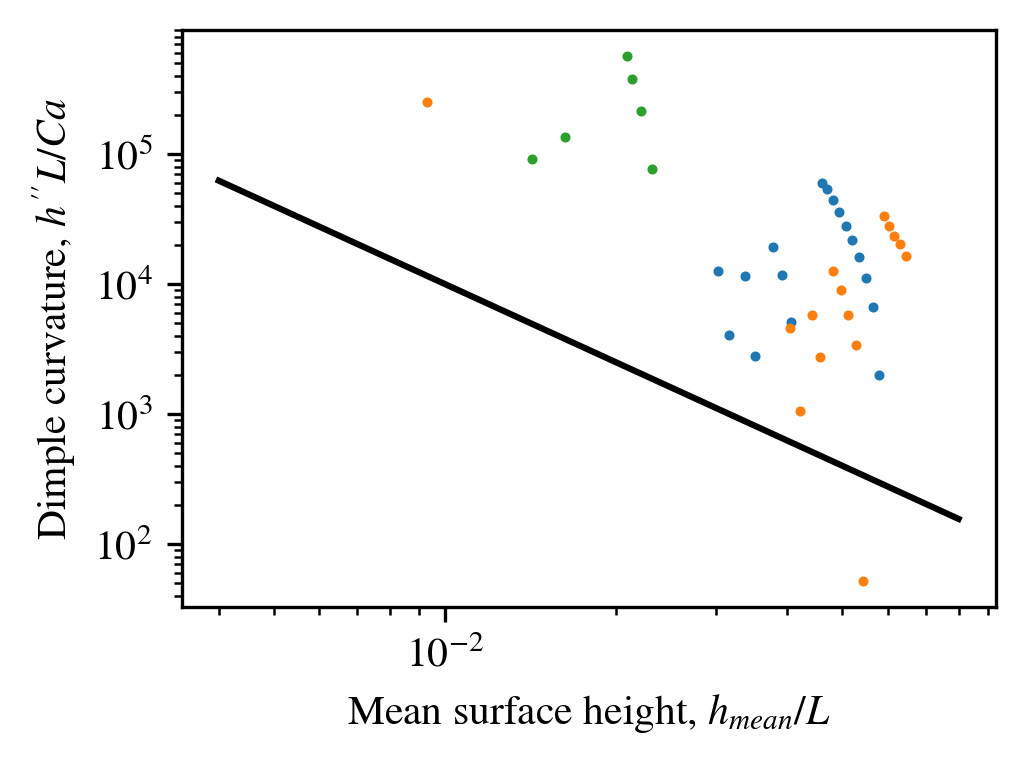

In [345]:
# plot mean surface height vs. curvature
folder = r"E:\WPM\Simulation\mu_sigma\dimple_detection"
l = readdata(folder, "csv")

L = 0.01
tau = 100
U = L / tau

fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
for num, i in l.iterrows():
    dimple = pd.read_csv(i.Dir).dropna()
    if len(dimple) == 0:
        continue
    mu = float(i.Name.split("_")[1])
    sigma = float(i.Name.split("_")[3])
    Ca = mu * U / sigma
    if mu == 0.01: # beet juice
        ax.scatter(dimple["mean_surface_height"].iloc[-1]*1e-3/L, dimple["curvature_minima"].iloc[-1]*L*1e3/Ca, color=bestcolor(0), s=2, label=i.Name)
    elif mu == 0.015: # vinegar
        ax.scatter(dimple["mean_surface_height"].iloc[-1]*1e-3/L, dimple["curvature_minima"].iloc[-1]*L*1e3/Ca, color=bestcolor(1), s=2, label=i.Name)
    else: # water
        ax.scatter(dimple["mean_surface_height"].iloc[-1]*1e-3/L, dimple["curvature_minima"].iloc[-1]*L*1e3/Ca, color=bestcolor(2), s=2, label=i.Name)
ax.set_xlabel("Mean surface height, $h_{mean}/L$")
ax.set_ylabel("Dimple curvature, $h''L/Ca$")
ax.loglog()
# x = np.linspace(0.04, 0.8, 100) * 1e-3 / L

y = x**-2
ax.plot(x, y, color="black")

## 5 Simulation vs. experiment -- detailed comparison

### 5.0 A constraint on the free parameters

Let's look at total height loss of the film $h_p$ as a function of initial thickness $h_0$.

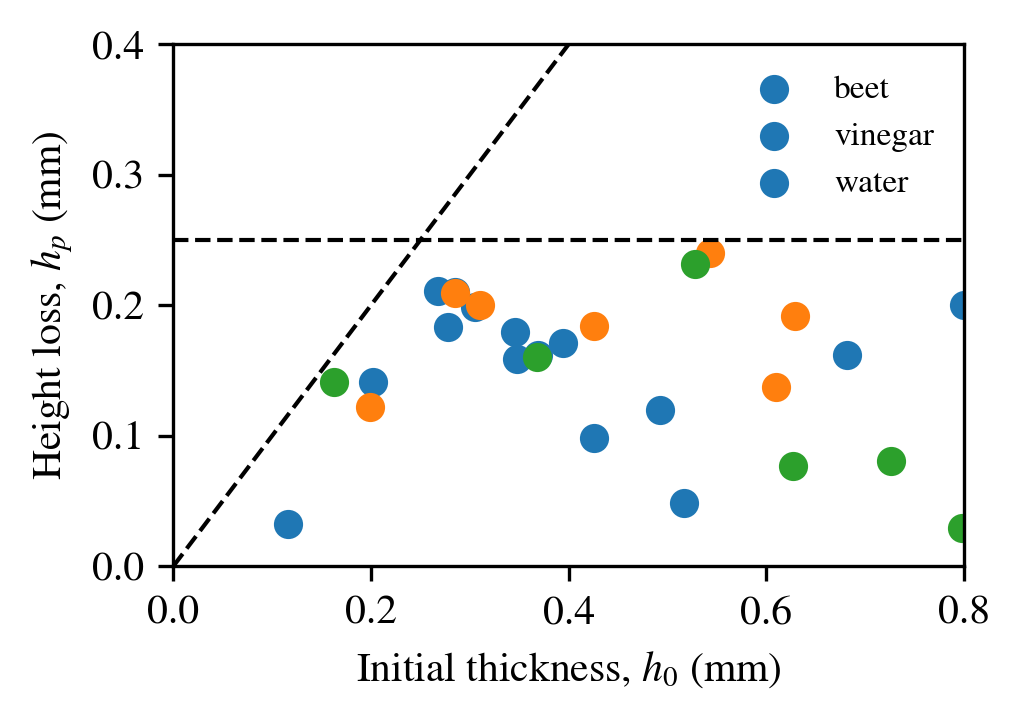

In [ ]:
folder = r"E:\WPM\08212024\surface_profile\dimple_detection"
l = readdata(folder, "csv")

fig, ax = plt.subplots(figsize=(3.5,2.5), dpi=300)
for num, i in l.iterrows():
    dimple = pd.read_csv(i.Dir)
    h0 = float(i.Name.split("_")[-1])
    hp = h0 - dimple["mean_surface_height"].iloc[-1]
    trial = i.Name.split("_")[1]
    if i.Name.startswith("beet"):
        ax.scatter(h0, hp, color=bestcolor(0))
        # plt.annotate(trial, (h0, hp), fontsize=8)
    elif i.Name.startswith("vinegar"):
        ax.scatter(h0, hp, color=bestcolor(1))
    else:
        ax.scatter(h0, hp, color=bestcolor(2))
ax.set_xlabel("Initial thickness, $h_0$ (mm)")
ax.set_ylabel("Height loss, $h_p$ (mm)")
ax.set_xlim([0, 0.8])
ax.set_ylim([0, 0.4])
ax.plot([0, 0.4], [0, 0.4], color="black", ls="--", lw=1)
ax.plot([0, 0.8], [0.25, 0.25], color="black", ls="--", lw=1)
ax.legend(["beet", "vinegar", "water"], frameon=False, fontsize=8)
plt.tight_layout()
fig.savefig(r"G:\My Drive\Pictures\height_loss.pdf")


### 5.1 Surface profile 

Let's first plot the surface profile evolution for an experiment where $h_0=0.285$ mm and a simulation where $h_0=0.279$ mm.

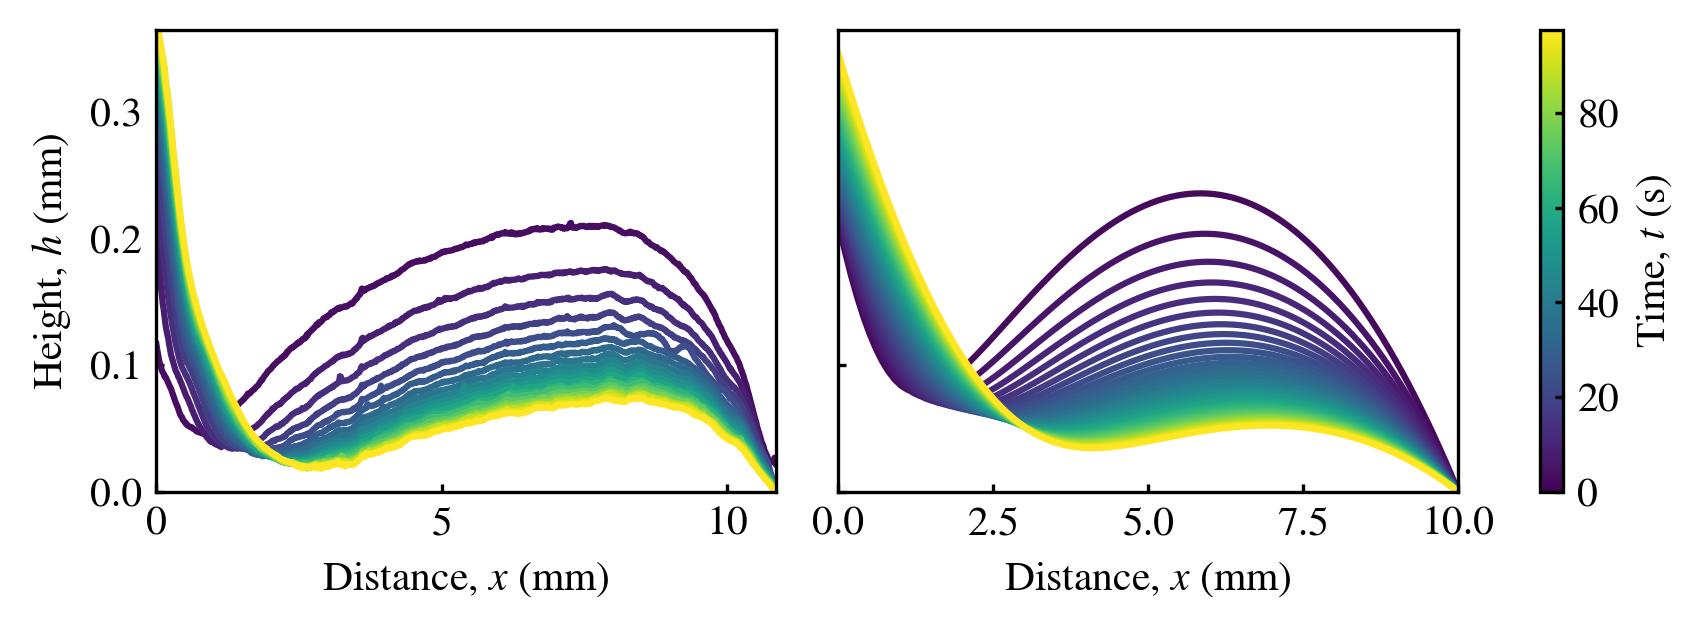

In [21]:
folder = r"G:\My Drive\Research projects\WPM\Data\08082024\surface_profile"
df = pd.read_csv(os.path.join(folder, "beet_juice_3_0.209.csv")).set_index("x")
df = df.iloc[:, 1::2]
cmap = plt.get_cmap("viridis")
tmax = float(df.columns[-1])
fig, ax = plt.subplots(ncols=2, figsize=(7,2), dpi=300, sharey=True, gridspec_kw={"wspace": .1})
for kw in df:
    x, y = df.index, df[kw].values
    ax[0].plot(x, y, color=cmap(float(kw)/tmax))
ax[0].set_xlabel("Distance, $x$ (mm)")
ax[0].set_ylabel("Height, $h$ (mm)")
ax[0].set_xlim([0, x.max()])
ax[0].set_ylim([0, df.max().max()])

folder_sim = r"G:\My Drive\Research projects\WPM\Data\Simulation\detail_Pi0_area_small_h0"
df_sim = pd.read_csv(os.path.join(folder_sim,"area_1.25e-03_Pi0_-1.20e+01_h0_2.09e-04.csv")).set_index("x")
df_sim = df_sim.iloc[:, 25::25]
cmap = plt.get_cmap("viridis")
tmax = float(df_sim.columns[-1])
for kw in df_sim:
    x, y = df_sim.index, df_sim[kw].values
    ax[1].plot(x, y, color=cmap(float(kw)/tmax))
ax[1].set_xlabel("Distance, $x$ (mm)")
# ax[1].set_ylabel("Height, $h$ (mm)")
ax[1].set_xlim([0, x.max()])
ax[1].set_ylim([0, df.max().max()])

# generate a colorbar to ax[1]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=tmax))
plt.colorbar(sm, ax=ax, label="Time, $t$ (s)")

# plt.tight_layout()
# fig.savefig(r"G:\My Drive\Pictures\beet_juice_simulation_surface_profile.svg")

### 5.2 Mean surface height 

We run a separate simulation where $h_0=0.285$ mm, and examine free parameters $\Pi_0$ and $A_p$. An additional constraint $-\Pi_0 A_p = \rho g V_p = 0.021\; \mathrm{kg\;m/s^2}$ is applied. More detail about this test can be found in [a separate note](../Notes/2024-08-27-determine-free-parameter-with-dimple-curvature-and-surface-height.md). 

We first look at the evolution of mean surface height and compare with experimental data. 

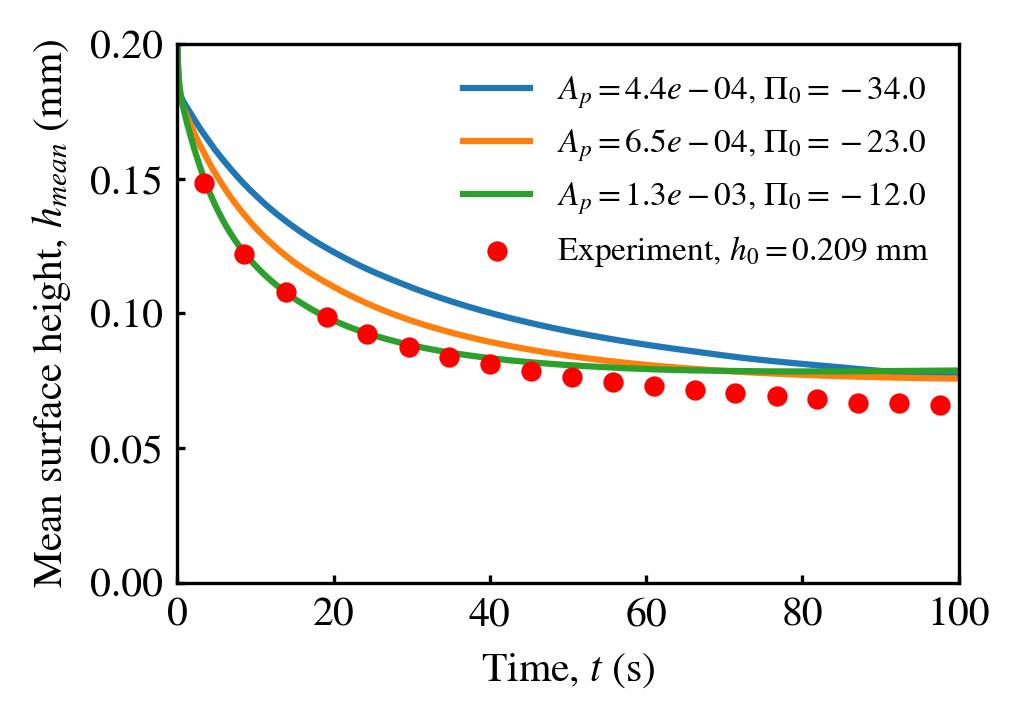

In [11]:
folder = r"G:\My Drive\Research projects\WPM\Data\08082024\surface_profile\dimple_detection"
dimple = pd.read_csv(os.path.join(folder, "beet_juice_3_0.209.csv")).set_index("t")
folder_sim = r"G:\My Drive\Research projects\WPM\Data\Simulation\detail_Pi0_area_small_h0\dimple_detection"
l = readdata(folder_sim, "csv")

fig, ax = plt.subplots(figsize=(3.5,2.5), dpi=300)
h_list = []
for num, i in l.loc[[8,9,0]].iterrows():
    dimple_sim = pd.read_csv(i.Dir).set_index("t")
    # get area and Pi0 from i.Name
    area = float(i.Name.split("_")[1])
    Pi0 = float(i.Name.split("_")[3])
    ax.plot(dimple_sim.index, dimple_sim["mean_surface_height"], label=f"$A_p={area:.1e}$, $\Pi_0={Pi0:.1f}$")
# prepend t=0 point to dimple
dimple = dimple.loc[dimple.index < 100]
ax.scatter(dimple.index, dimple["mean_surface_height"], s=15, c="red", label="Experiment, $h_0=0.209$ mm", zorder=10)
# ax.plot(dimple_sim.index, dimple_sim["mean_surface_height"], label="Simulation")
ax.set_xlabel("Time, $t$ (s)")
ax.set_ylabel("Mean surface height, $h_{mean}$ (mm)")
ax.legend(frameon=False, fontsize=8)
ax.set_xlim([0, 100])
ax.set_ylim([0, 0.2])
plt.tight_layout()
# fig.savefig(r"G:\My Drive\Pictures\compare_mean_surface_profile.pdf")

### 5.3 Dimple curvature

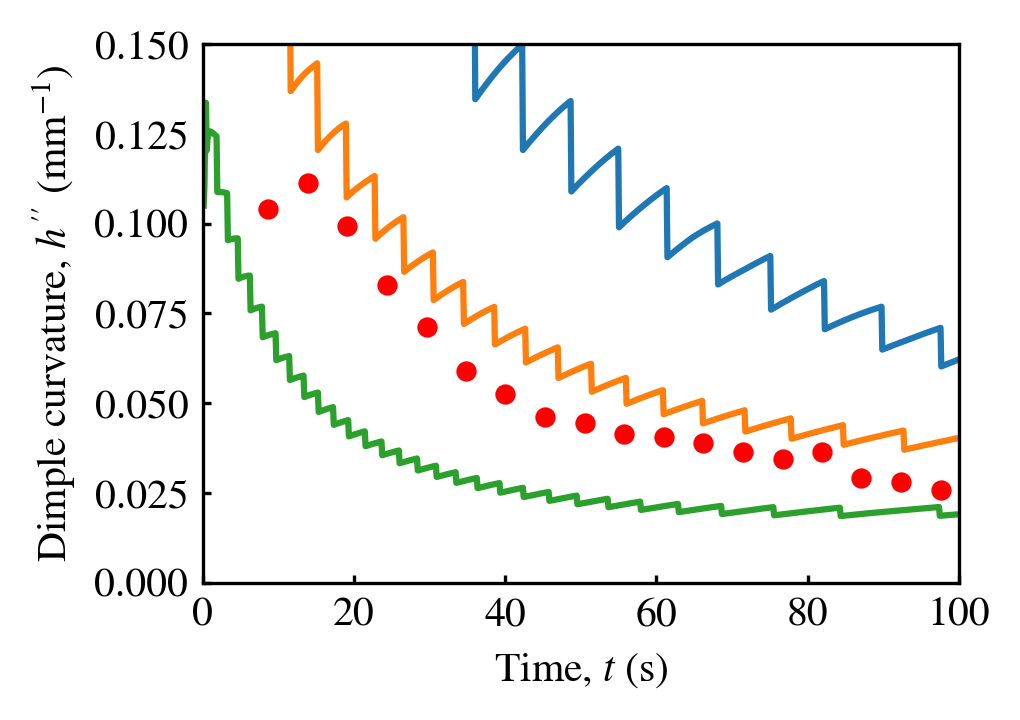

In [12]:
folder = r"G:\My Drive\Research projects\WPM\Data\08082024\surface_profile\dimple_detection"
dimple = pd.read_csv(os.path.join(folder, "beet_juice_3_0.209.csv")).set_index("t")
folder_sim = r"G:\My Drive\Research projects\WPM\Data\Simulation\detail_Pi0_area_small_h0\dimple_detection"
l = readdata(folder_sim, "csv")

fig, ax = plt.subplots(figsize=(3.5,2.5), dpi=300)
h_list = []
for num, i in l.loc[[8,9,0]].iterrows():
    dimple_sim = pd.read_csv(i.Dir).set_index("t")
    # get area and Pi0 from i.Name
    area = float(i.Name.split("_")[1])
    Pi0 = float(i.Name.split("_")[3])
    ax.plot(dimple_sim.index, dimple_sim["curvature_minima"], label=f"$A_p={area:.1e}$, $\Pi_0={Pi0:.1f}$")
# prepend t=0 point to dimple
dimple = dimple.loc[dimple.index < 100]
ax.scatter(dimple.index, dimple["curvature_minima"], s=15, c="red", label="Experiment, $h_0=0.209$ mm", zorder=10)
# ax.plot(dimple_sim.index, dimple_sim["mean_surface_height"], label="Simulation")
ax.set_xlabel("Time, $t$ (s)")
ax.set_ylabel("Dimple curvature, $h''$ (mm$^{-1}$)")
# ax.legend(frameon=False, fontsize=8)
ax.set_xlim([0, 100])
ax.set_ylim([0, 0.15])
plt.tight_layout()
fig.savefig(r"G:\My Drive\Pictures\beet_juice_simulation_curvature.pdf")

## Appendix A. Load video

In [ ]:
cap = cv2.VideoCapture(r"E:\WPM\04292024\beet_scan_1.MOV")
while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # by default opencv reads images as BGR, here we convert to RGB to be compatible with matplotlib
    break

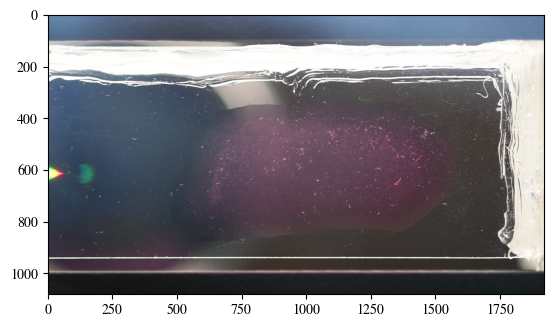

In [ ]:
plt.imshow(frame)

## Appendix B. Verify scanner speed

Since the scanner moves almost at a constant speed, a frame-by-frame tracking is an overkill. Instead, we can use two key frames at the beginning and the end of each scan, and infer the framewise location of the scanner, or the focus of the scanner. 

The key frame xy location is obtained from ImageJ and the frame number is obtained from MPC player (get time and convert to frame number).

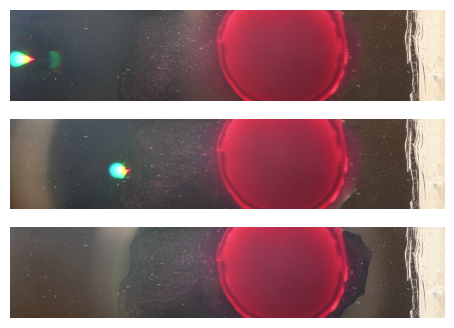

In [16]:
# eye tracking 942@(1,614), 2099@(921,614)
# draw 10 pictures with dot indicator on raw image
cap = cv2.VideoCapture(r"E:\WPM\04292024\beet_scan_1.MOV")
i = 0
fps = 30
num_draw = 3
show = np.linspace(12.879*fps, 28.428*fps, endpoint=True, num=num_draw).astype("int")
x = np.linspace(1, 921, endpoint=True, num=num_draw)
y = np.ones(x.shape) * 614
count = 0
# initialize figure
fig, ax = plt.subplots(ncols=1, nrows=num_draw, figsize=(1980/300, 400*num_draw/300), dpi=100)
while True:
    ret, frame = cap.read()  
    if ret == False:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    i += 1
    if i in show:
        ax[count].imshow(frame[400:800, :])
        # ax[count].scatter(x[count], y[count]-400, s=10, facecolor=(0,0,0,0), edgecolor="red", linewidths=2)
        ax[count].axis("off")
        count += 1

The scanner can be approximated as moving at a constant speed.

## Appendix C. Improve the setup

### C1. Faster scanner

To obtain more time resolved surface profile data, we use a step-motor-powered linear stage (from an old 3D printer) to replace the old thread linear stage. The new linear stage moves much faster, but also generates much more vibration which can make the surface measurement noisier. In this section, we plot the test measurement data and evaluate the effect of the vibration.  

(0.0, 145000.0)

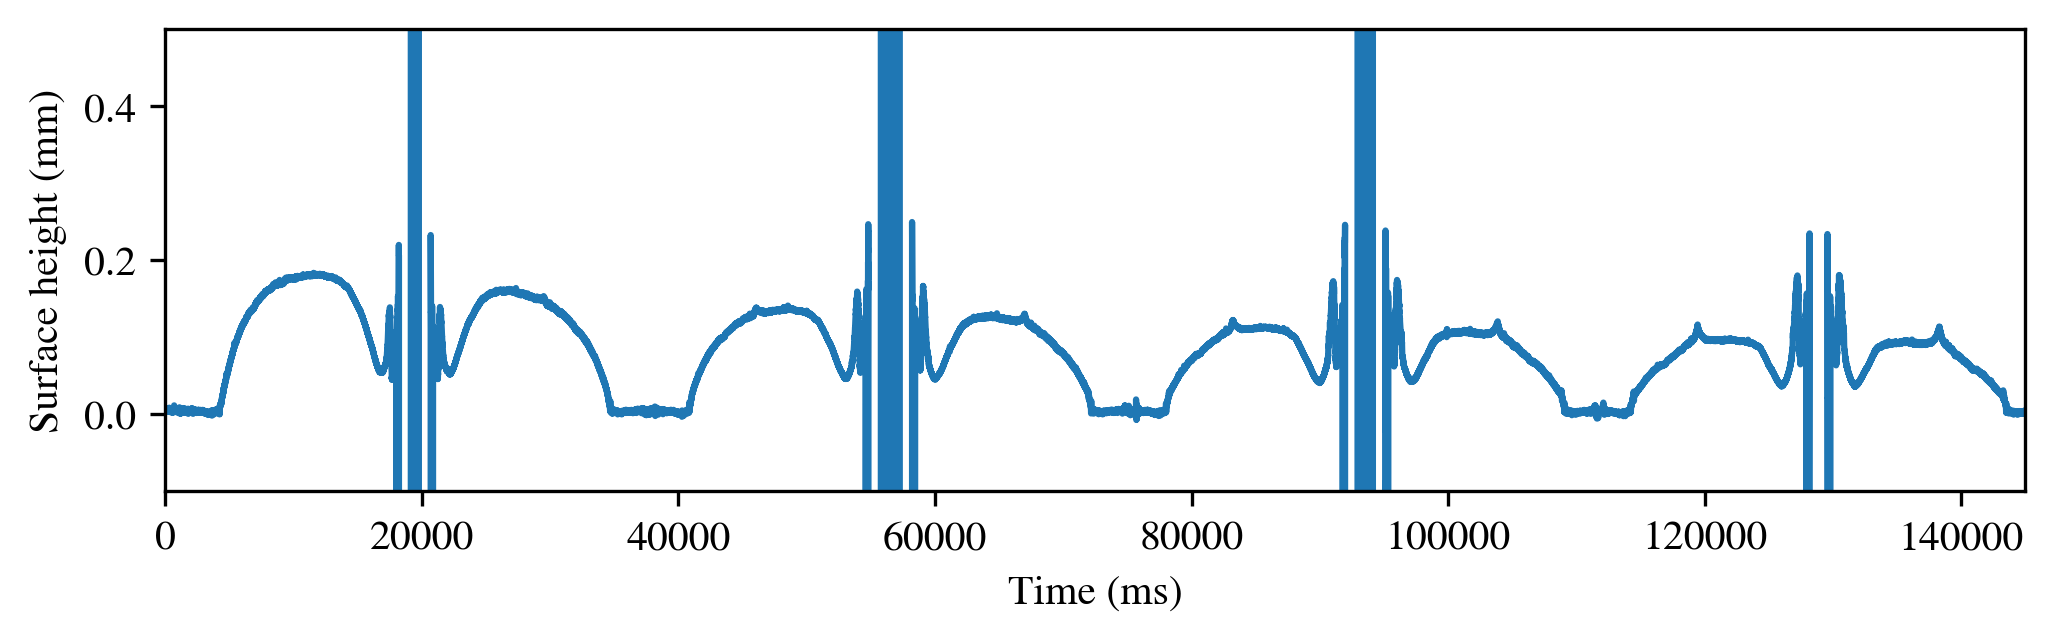

In [105]:
folder = r"E:\WPM\05012024"
filename = "beet_circle_full_sample1_4"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.figure(figsize=(8, 2), dpi=300)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")
plt.ylim([-0.1, 0.5])
plt.xlim([0, 145000])

(-0.1, 0.5)

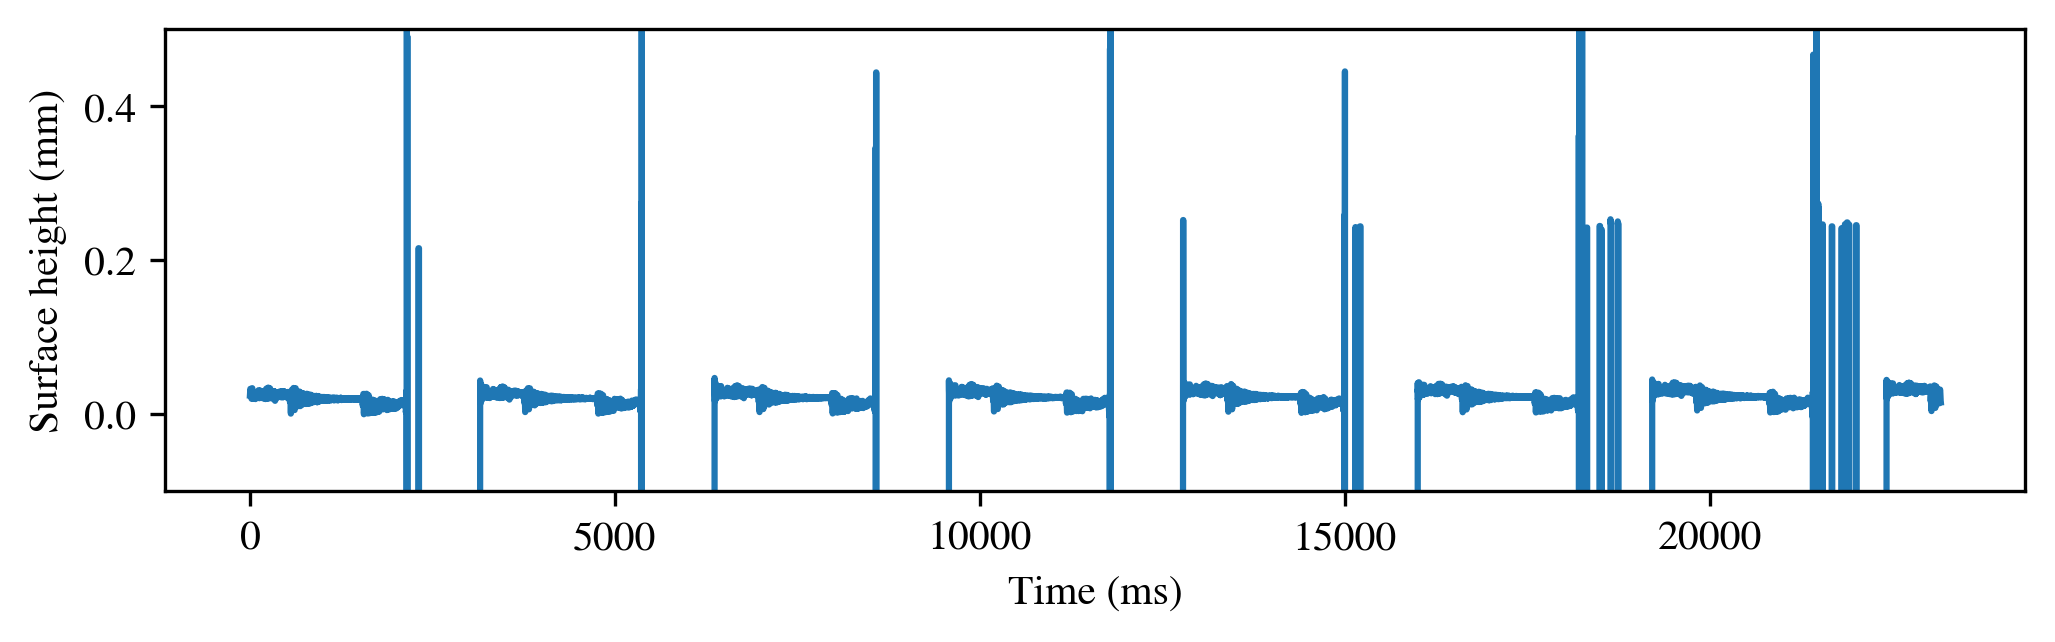

In [94]:
folder = r"E:\WPM\06062024"
filename = "stage_scan_flat_surface"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.figure(figsize=(8, 2), dpi=300)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")
plt.ylim([-0.1, 0.5])
# plt.xlim([0, 25000])

(0.0, 15000.0)

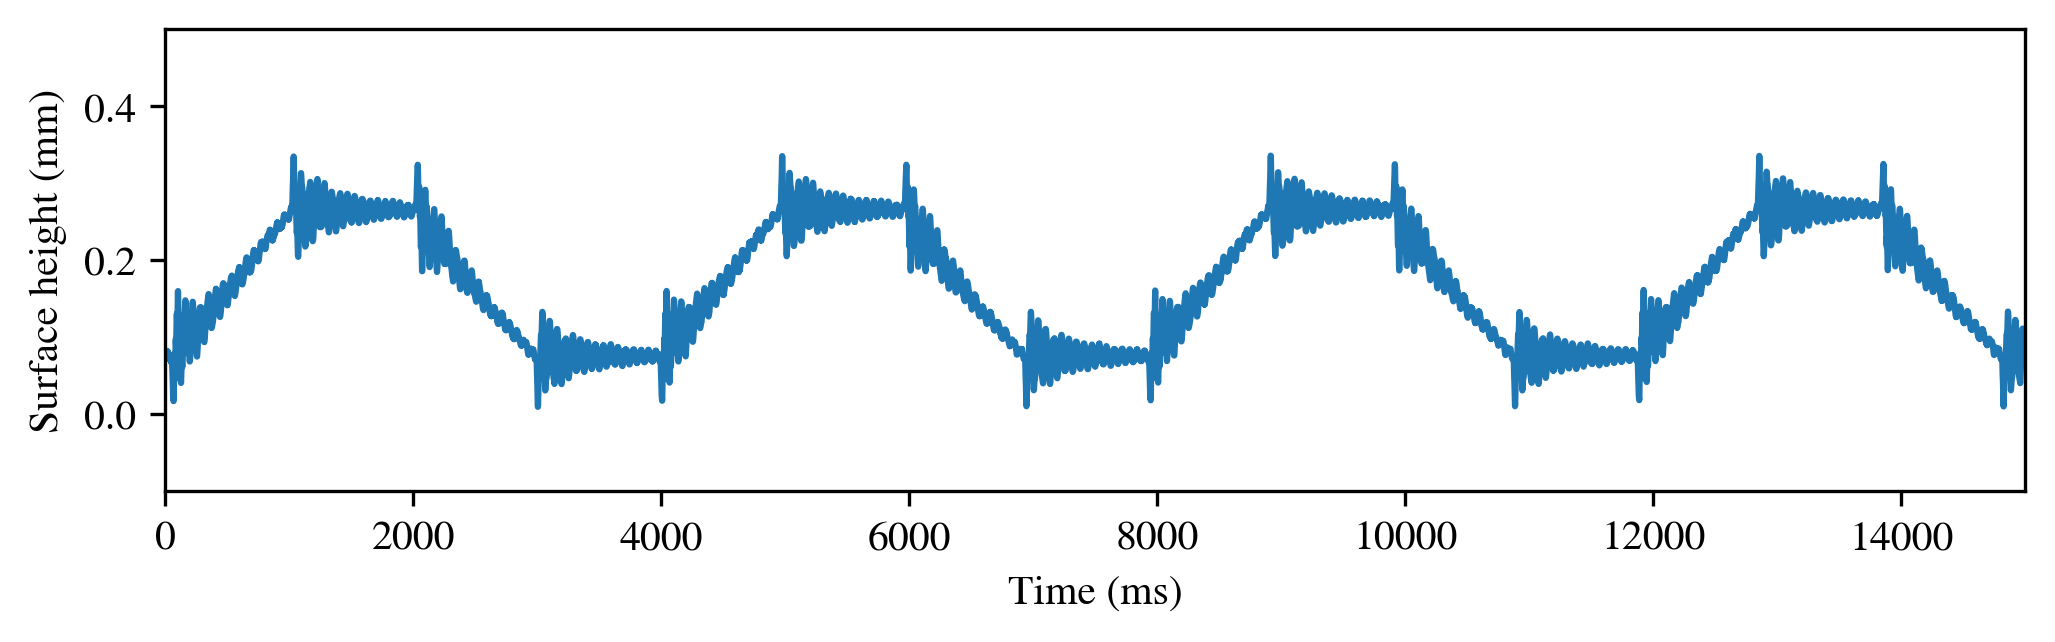

In [108]:
folder = r"E:\WPM\06112024"
filename = "scan_flat_surface_thread_stage_schneider"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=53000)
plt.figure(figsize=(8, 2), dpi=300)
plt.plot(raw+0.2)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")
plt.ylim([-0.1, 0.5])
plt.xlim([0, 15000])

(0.0, 15000.0)

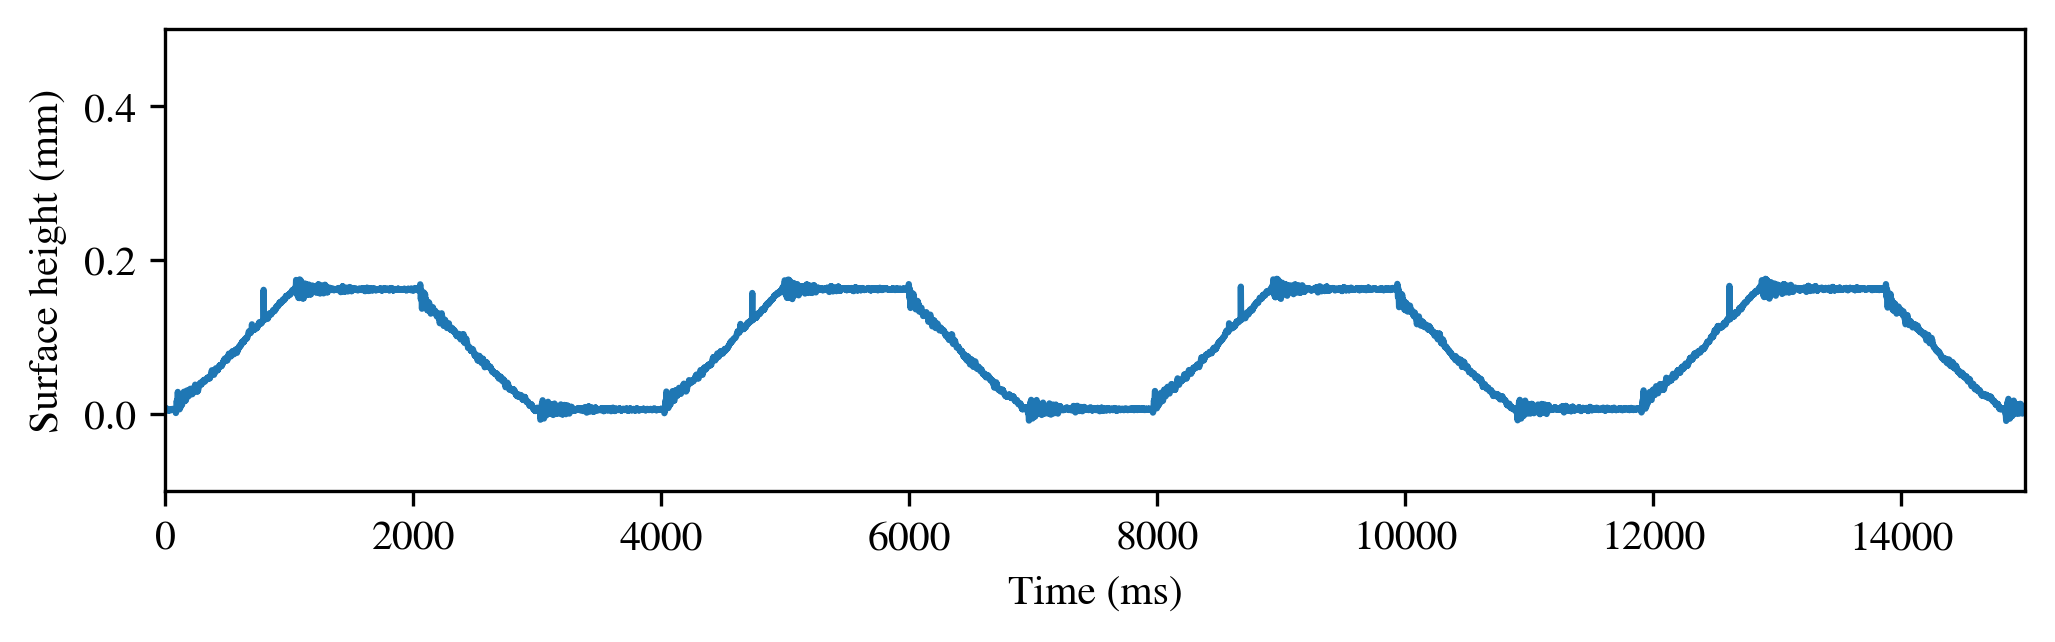

In [109]:
folder = r"E:\WPM\06122024"
filename = "scan_flat_surface_improved_stage_mount"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.figure(figsize=(8, 2), dpi=300)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")
plt.ylim([-0.1, 0.5])
plt.xlim([0, 15000])

### C2. Compare scan quality

We have multiple setup designs already. An easy way to compare them is to compare the scan results on a flat surface. Below is a list of setup versions:

1. Zaber tube cylinder (slow)
2. Schneider linear stage (fast, small support beam, joint v1)
3. Schneider linear stage (fast, small support beam, joint v2)
4. Schneider linear stage (fast, large support beam, joint v3)
5. Schneider linear stage + sliding stage

With these setups, we scan a horizontal flat surface and compare the noise levels.

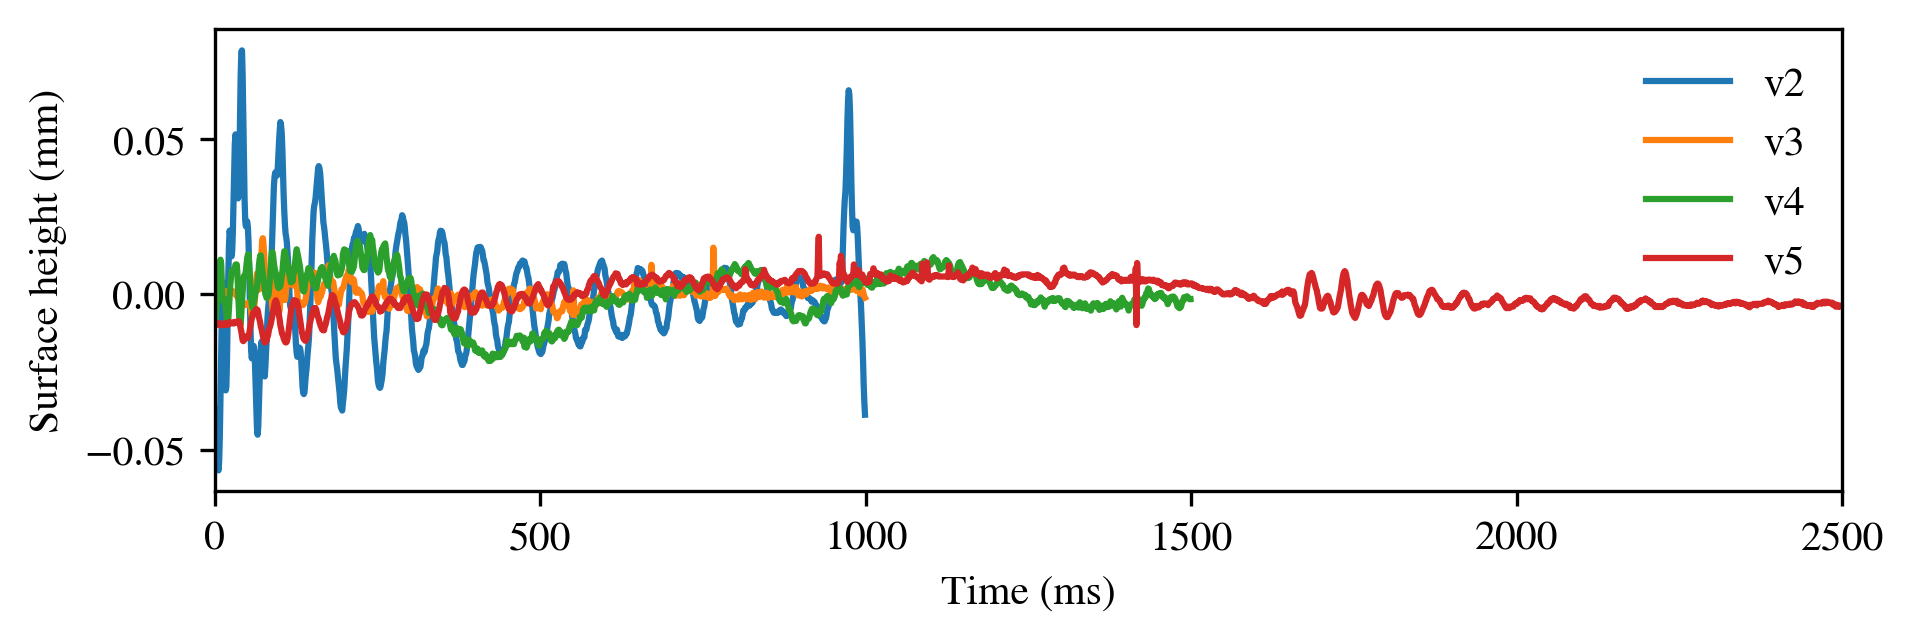

In [5]:
folder = r"E:\WPM\compare_setups"
l = readdata(folder, "csv")
fig, ax = plt.subplots(figsize=(7,2), dpi=300)
for num, i in l.iterrows():
    df = pd.read_csv(i.Dir)
    ax.plot(df.t, df.h, label=i.Name)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Surface height (mm)")
# plt.ylim([-0.1, 0.5])
plt.xlim([0, 2500])
ax.legend(frameon=False)

Text(0, 0.5, 'Surface height (mm)')

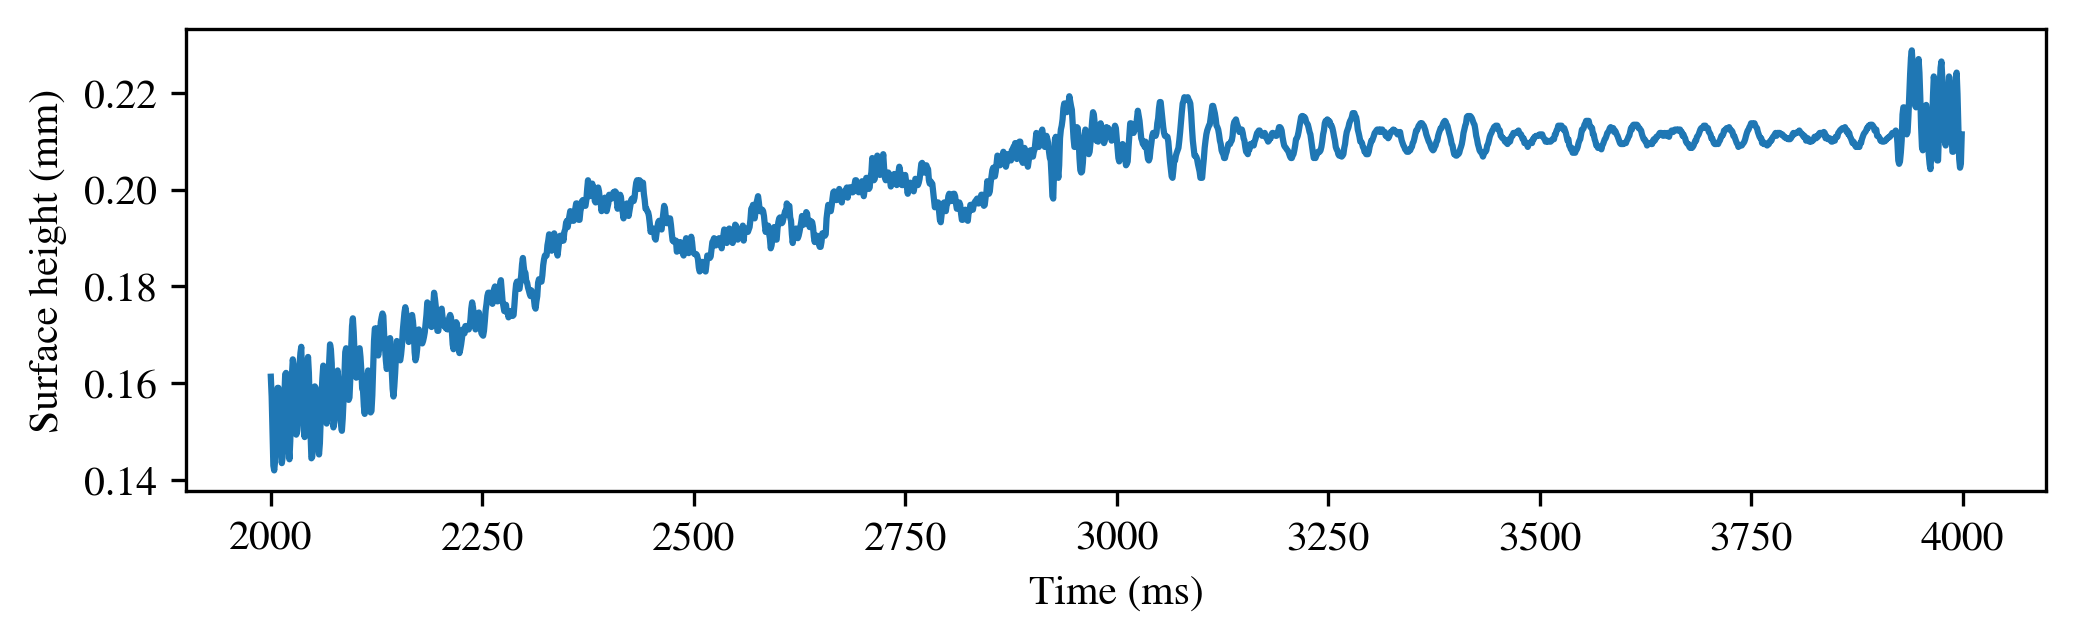

In [61]:
folder = r"E:\WPM\06122024"
filename = "beet_juice_2"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)[2000:4000]
plt.figure(figsize=(8, 2), dpi=300)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")
# plt.ylim([-0.1, 0.5])
# plt.xlim([0, 15000])

### C3. Compare scan liquid film

In [52]:
df = {}
df["v1"] = pd.read_csv(r"E:\WPM\04292024\surface_profile\beet_scan4_4.csv")[["x", "scan-1"]].values
df["v3"] = pd.read_csv(r"E:\WPM\06212024\surface_profile\PB_S10_trial1_4.csv")[["x", "scan-50"]].values
df["v4"] = pd.read_csv(r"E:\WPM\08072024\surface_profile\beet_juice_1.csv")[["x", "scan-1"]].values

Text(0, 0.5, 'Surface height, $h$ (mm)')

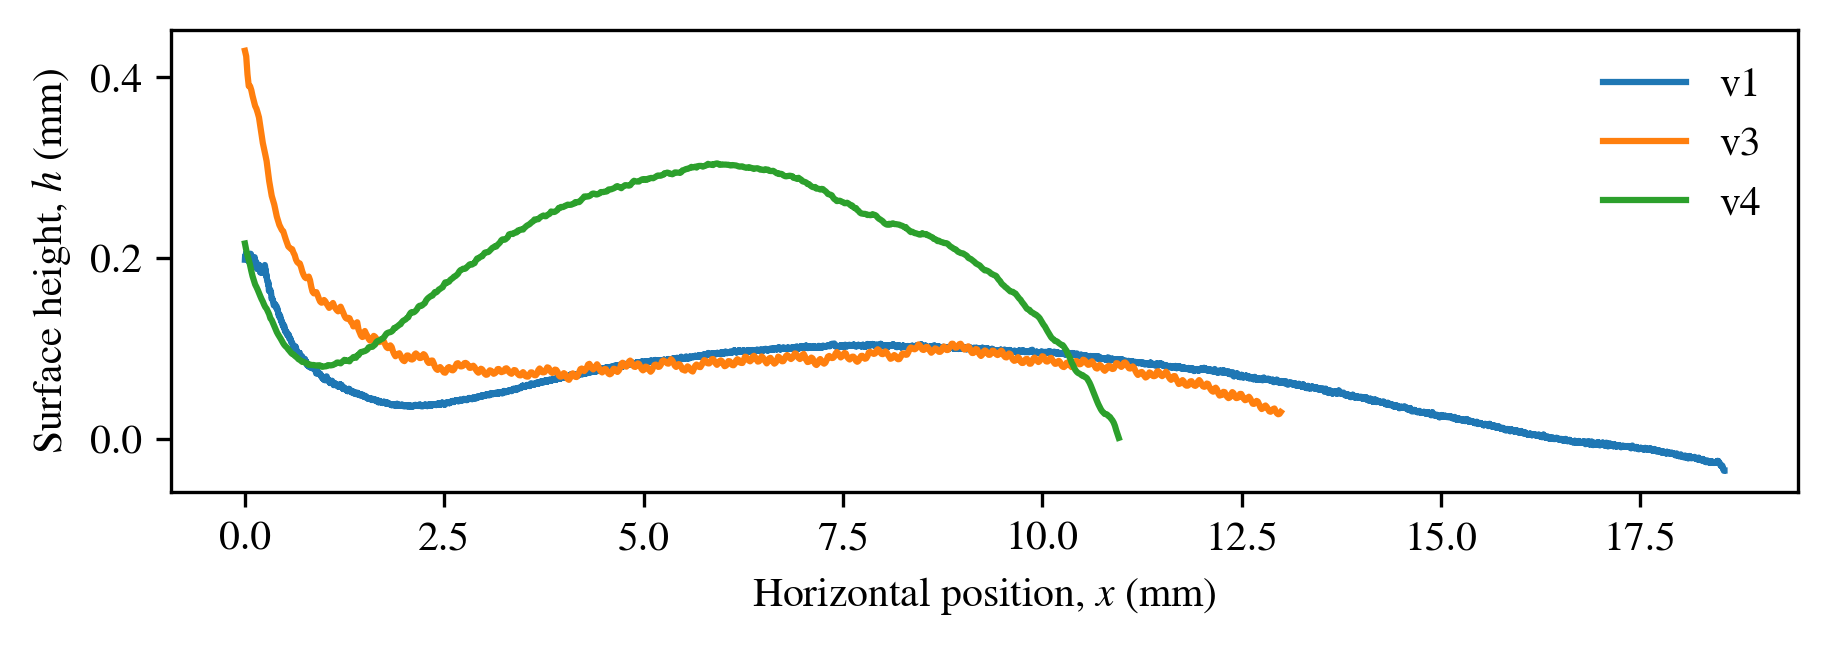

In [53]:
fig, ax = plt.subplots(figsize=(7,2), dpi=300)
for kw in df:
    ax.plot(df[kw][:, 0], df[kw][:, 1], label=kw)
ax.legend(frameon=False)
ax.set_xlabel("Horizontal position, $x$ (mm)")
ax.set_ylabel("Surface height, $h$ (mm)")

## Appendix D. Reynolds ridge?

Scott 1982 cited Satterly 1956 as an independent observation of Reynolds ridge. Is this true? Using the characteristic dependence of ridge-barrier distance on flow rate, we show that this fringe is different from Reynolds ridge. In this section, we plot fringe distance from barrier as a function of flow rate. The result is plotted together with the figure 2 of Mockros 1968, where distance increases when flow rate decreases.

In [5]:
stack = io.imread(r"E:\WPM\04252024\flow_09_cropped.tif")

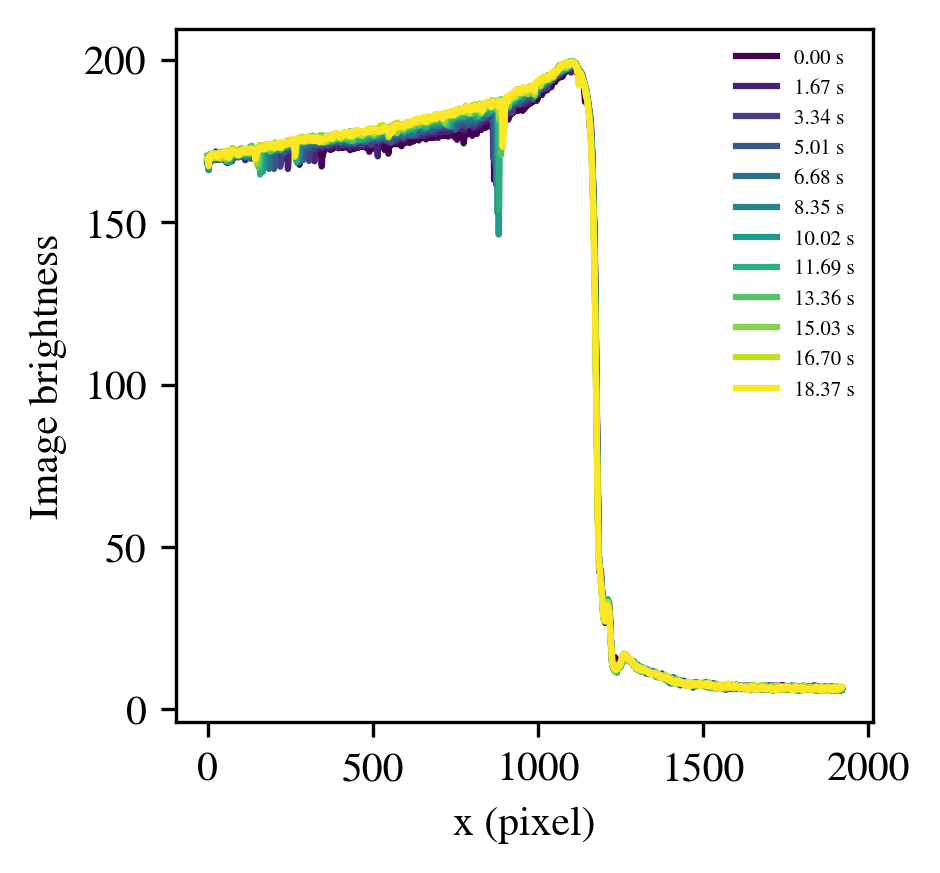

In [6]:
plt.figure(figsize=(3, 3), dpi=300)
cmap = plt.get_cmap("viridis", stack.shape[0])
i = 0
for img in stack:
    plt.plot(img[120:130, :].mean(axis=0), color=cmap(i), label="{:.2f} s".format(i*1.67))
    i += 1
plt.xlabel("x (pixel)")
plt.ylabel("Image brightness")
plt.legend(frameon=False, fontsize=5)

## Appendix E. Double check the surface profile cropping

With the fast scanner, we obtain more time-resolved surface profiles and understand the dimple formation better. However, cropping the actual surface profile from those out-of-range noise gets harder due to the increase of the amount of work. By assuming that the scanner always move in a strictly periodic way, we can label only a few keyframes and infer the rest. This approach makes the cropping faster, but also shows some inaccuracy that needs to be addressed. In this section, I double check all the cropped data and make corrections if needed.

(0.0, 0.8)

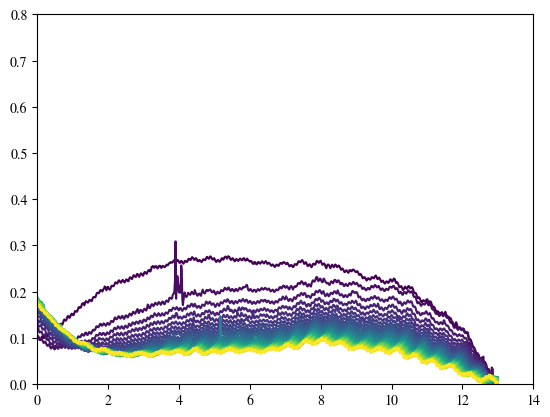

In [169]:
folder = r"G:\My Drive\Research projects\WPM\Data\06212024\surface_profile"
df = pd.read_csv(os.path.join(folder, "PB_S10_trial1_4.csv")).set_index("x")
i = 0
cmap = plt.get_cmap("viridis", df.shape[1])
for kw in df:
    if i % 2 == 0:
        plt.plot(df.index, df[kw], color=cmap(i))
    i += 1
    if i > 100:
        break
plt.xlim([0, 14])
plt.ylim([0, 0.8])

Besides the cropping issue, I also notice that the forward and backward scans show discrepancy. It looks like a slight tilt of the substrate. A good thing to do now is to only use one of the scans, either forward or backward.

In [12]:
folder = r"G:\My Drive\Research projects\WPM\Data\04292024\surface_profile"
df = pd.read_csv(os.path.join(folder, "beet_scan4_4.csv")).set_index("x")

folder = r"G:\My Drive\Research projects\WPM\Data\06212024\surface_profile"
df_w = pd.read_csv(os.path.join(folder, "PB_S10_trial1_4.csv")).set_index("x")

(0.0, 18.0, 0.0, 0.3)

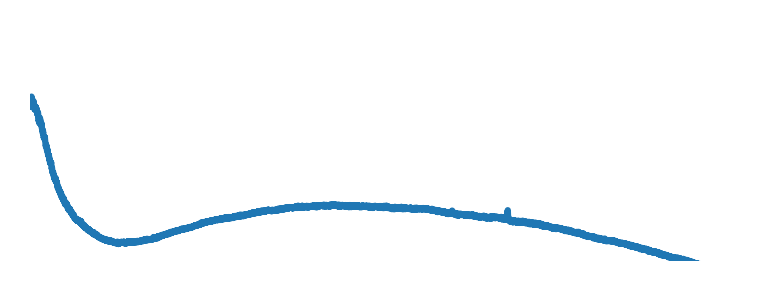

In [16]:
plt.figure(figsize=(3,1), dpi=300)
plt.plot(df.index, df["scan-3"])
# plt.plot(df_w.index, df_w["scan-3"])
plt.xlim([0, 18])
plt.ylim([0, 0.3])
# plt.xlabel("Horizontal position, $x$ (mm)")
# plt.ylabel("Surface height, $h$ (mm)")
plt.axis("off")

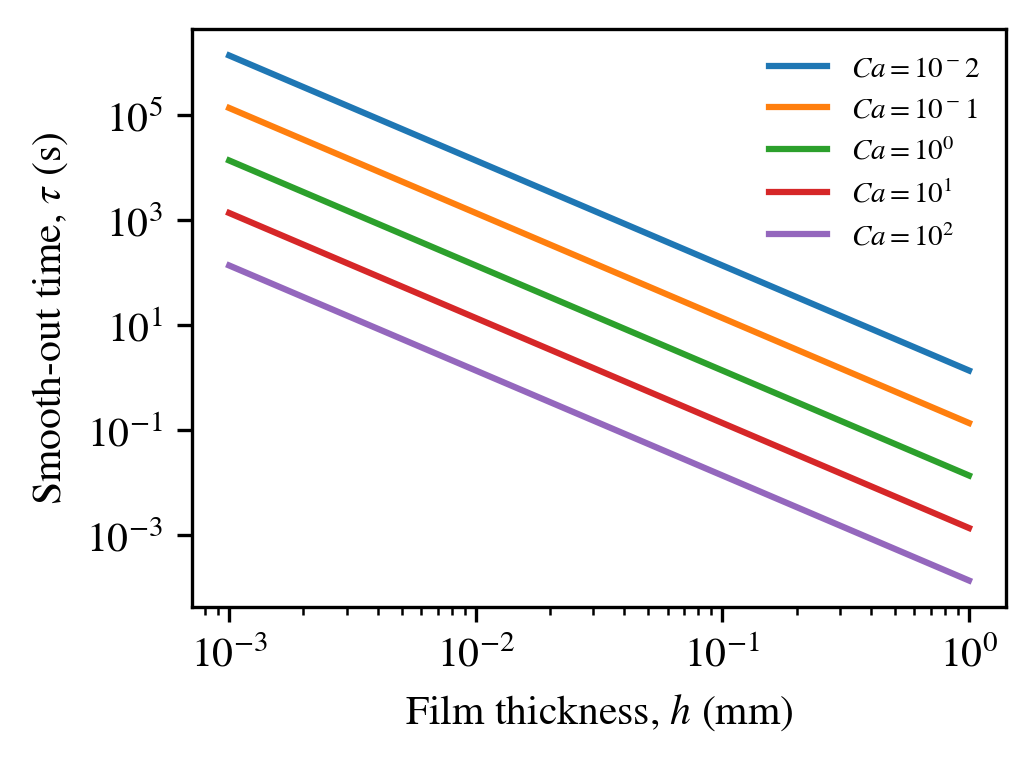

In [10]:
eta = 1e-3
L = 1e-2
gamma = 72e-3
h = np.logspace(-6, -3)

plt.figure(figsize=(3.5, 2.5), dpi=300)
for ca in [.01, .1, 1, 10, 100]:
    tau = eta * L**3 / ca / gamma / h**2
    plt.plot(h*1000, tau, label="$Ca=10^{0:d}$".format(int(np.log10(ca))))
plt.xlabel("Film thickness, $h$ (mm)")
plt.ylabel("Smooth-out time, $\\tau$ (s)")
plt.loglog()
plt.legend(fontsize=7, frameon=False)

## Appendix F. Linear stage is not straight?

In the stepper linear stage setup, we observe unexpected bumps in the scan results. Unlike the noise caused by motor vibration, the bumps are much lower frequency and the magnitude is less dependent on the motor frequency. We hypothesize that the bumps are not caused by the vibration of the setup, but the imperfection of the linear stage rod. To test this hypothesis, we measure a perfectly flat surface at two different motor frequency (delay time = 800 us or 3000 us). If the hypothesis is valid, we should see perfect match between the long wavelength bumps in the two scans.

In [49]:
s800 = pd.read_csv(r"E:\WPM\08072024\800delay.csv", usecols=[1], skiprows=12, names=["h"])
s3000 = pd.read_csv(r"E:\WPM\08072024\3000delay.csv", usecols=[1], skiprows=12, names=["h"])

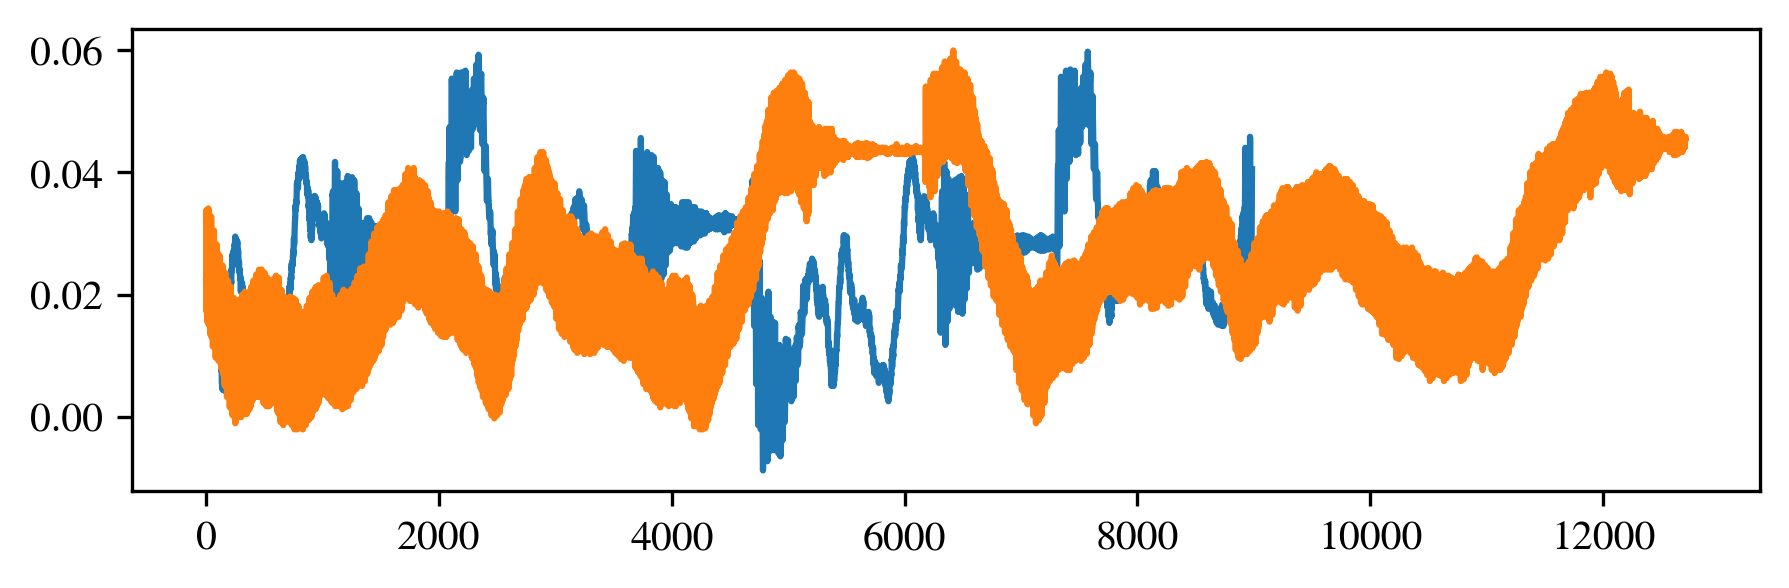

In [60]:
fig, ax = plt.subplots(figsize=(7,2), dpi=300)
ax.plot(s800.index, s800["h"])
ax.plot(s3000.index, s3000["h"])

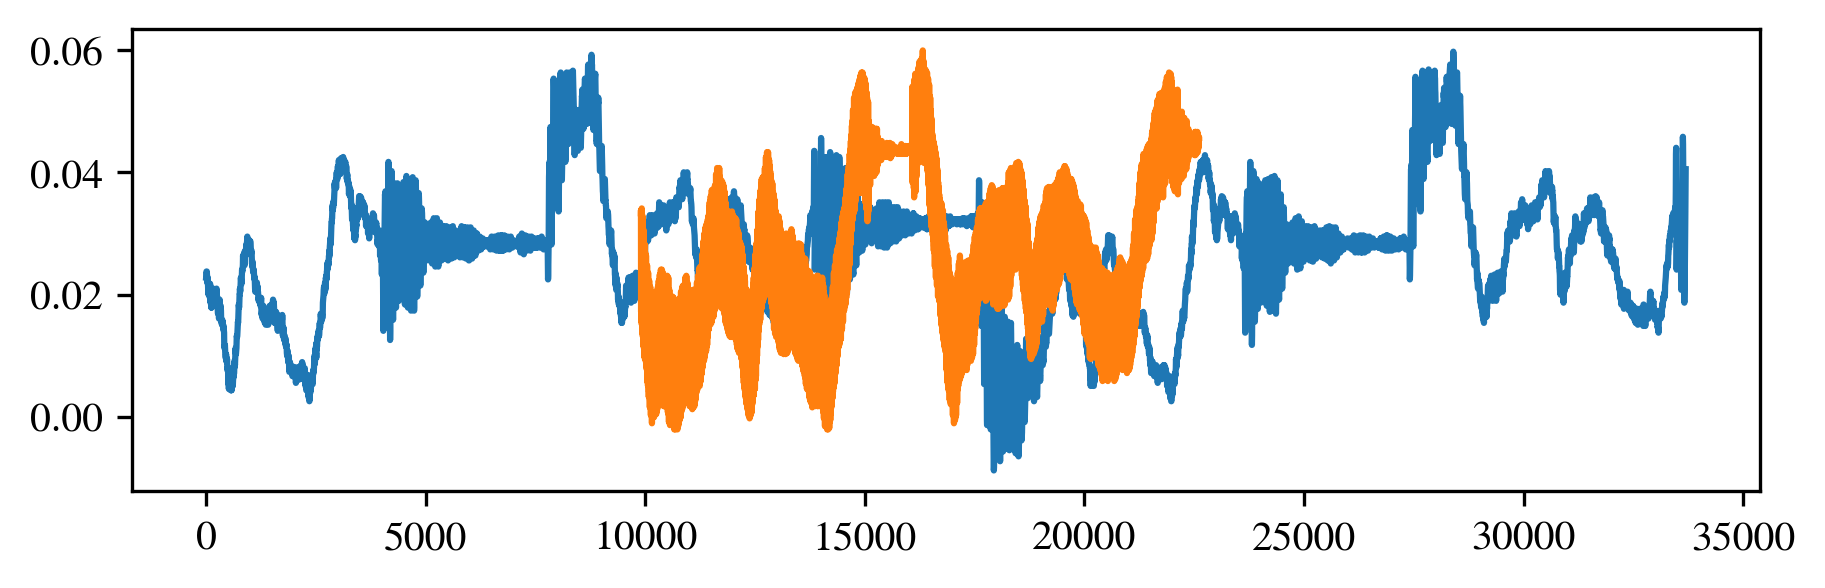

In [59]:
for i in range(100):
    fig, ax = plt.subplots(figsize=(7,2), dpi=300)
    ax.plot(s800.index*3000/800, s800["h"])
    ax.plot(i*100+s3000.index, s3000["h"])
    plt.pause(.1)
    clear_output(wait=True)
# ax.set_ylim([-0.1, 0.5])

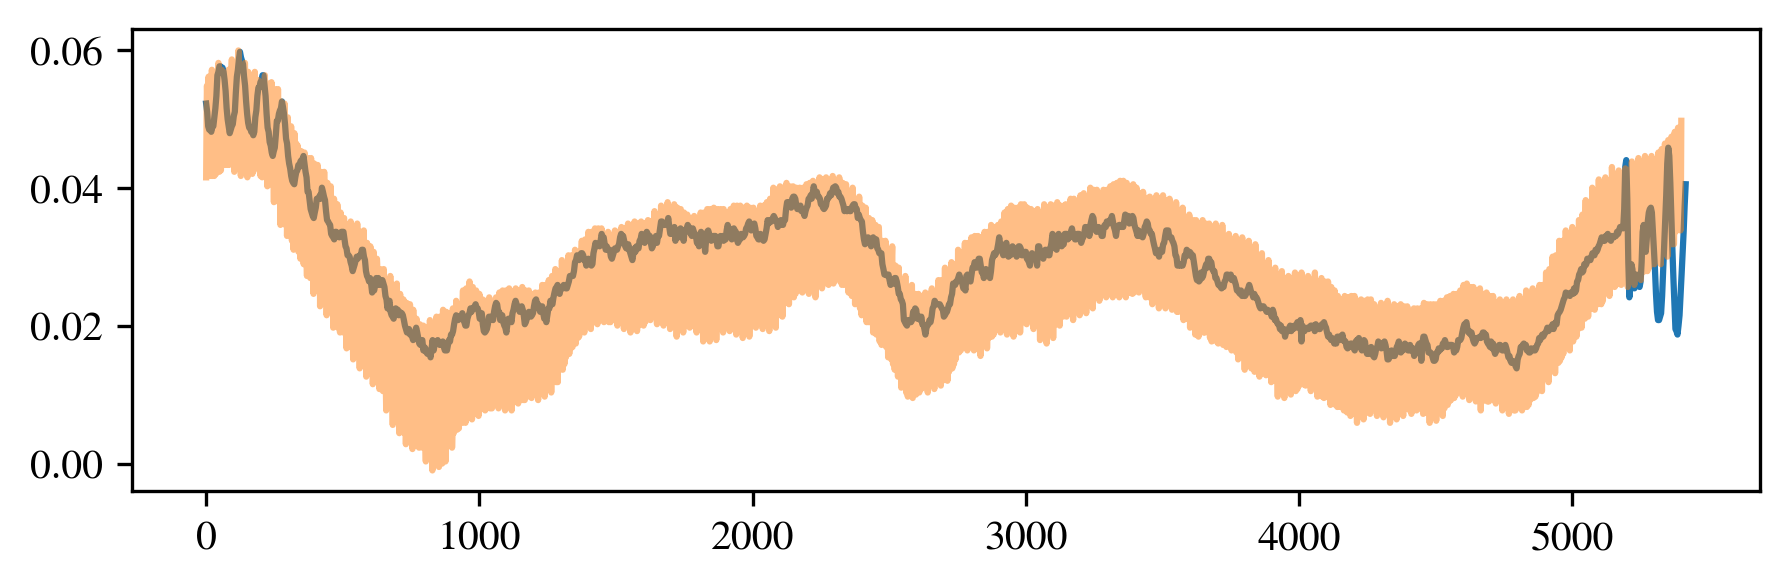

In [81]:
# try to match the features of the two scans
fig, ax = plt.subplots(figsize=(7,2), dpi=300)
s800c = s800[7540:].reset_index()
s3000c = s3000[6300:11700].reset_index()
ax.plot(s800c.index*3000/800, s800c["h"])
ax.plot(s3000c.index, s3000c["h"], alpha=.5)
# ax.set_ylim([-.1, .5])

With some scaling and translation, we observe a perfect match between slow and fast scan over the same surface, indicating that the unexpected bumps are not from the vibrational noise of the motor, but from the imperfect rod shape! This has led to the setup modification v4->v5.

## Appendix G. Initial thickness measurement

In [332]:
df = pd.read_csv(r"G:\My Drive\Research projects\WPM\Data\10252024\gw80-10.csv")
df["h"][78314:81756].mean()

0.25138425001826675

## Appendix H. Smoothing

### H1. Smoothing with FFT

The stepping motor setup greatly enhanced the temporal resolution of the scan. However, the constant vibration is making the surface profile noisy. In this section, I implement a frequency filter to smooth the scan data. 

(-0.1, 0.8)

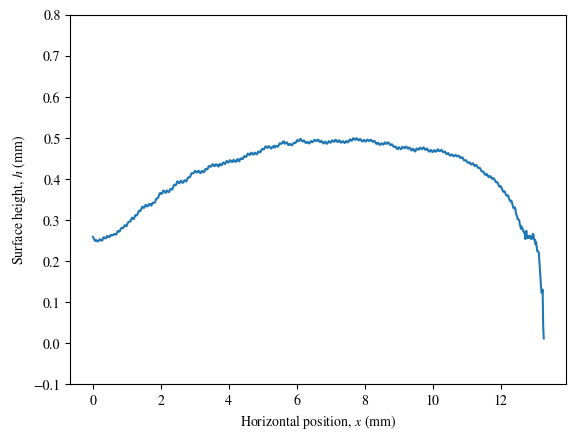

In [ ]:
folder = r"G:\My Drive\Research projects\WPM\Data\06212024"
df = pd.read_csv(os.path.join(folder, "surface_profile", "PB_S10_trial1_1.csv")).set_index("x")
plt.plot(df.index, df["scan-1"])
plt.xlabel("Horizontal position, $x$ (mm)")
plt.ylabel("Surface height, $h$ (mm)")
plt.ylim([-0.1, 0.8])

In [ ]:
def freq_filter(signal, cutoff):
    """
    signal is a two-row array with t and y. Cutoff is set in unit of 1/[t].
    """
    t, y = signal[0], signal[1]
    # sampling frequency
    fs = len(t) / t.max()

    # compute fft
    fft_signal = np.fft.fft(y)
    fft_freq = np.fft.fftfreq(len(t), 1/fs)

    # apply frequency filter
    fft_signal_filtered = fft_signal.copy()
    fft_signal_filtered[np.abs(fft_freq) > cutoff] = 0

    # compute inverse fft
    filtered_signal = np.fft.ifft(fft_signal_filtered).real

    return np.array([t, filtered_signal])


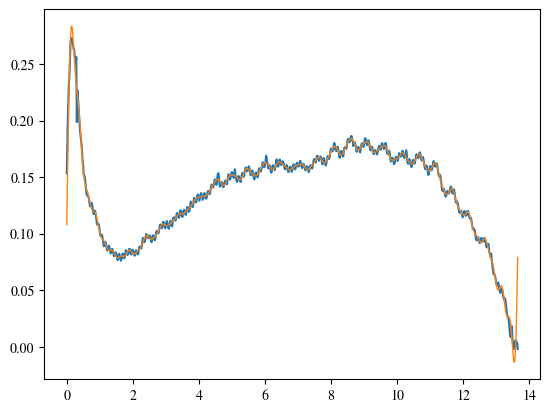

In [ ]:
signal = np.array([df.index, df["scan-7"]])
cutoff = 4
filtered = freq_filter(signal, cutoff)
plt.plot(signal[0], signal[1])
plt.plot(filtered[0], filtered[1], lw=1)

(0.0, 0.8)

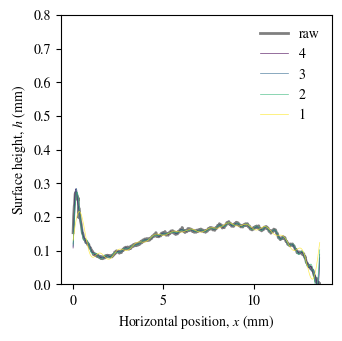

In [ ]:
# try various cutoff frequencies
plt.figure(figsize=(3.5,3.5))
plt.plot(signal[0], signal[1], color="black", lw=2, alpha=.5, label="raw")
co_list = np.flip(np.arange(1, 5))
cmap = plt.get_cmap("viridis", len(co_list))
i = 0
for cutoff in co_list:
    filtered = freq_filter(signal, cutoff)
    plt.plot(filtered[0], filtered[1], color=cmap(i), lw=.5, alpha=.8, label=cutoff)
    i += 1
plt.legend(frameon=False)
plt.xlabel("Horizontal position, $x$ (mm)")
plt.ylabel("Surface height, $h$ (mm)")
plt.ylim([0, 0.8])

### H2. Smoothing with butterworth

In [460]:
def butterworth_filter(y, cutoff):

    fs =  len(y) # Sampling frequency

    order = 3  # Order of the filter
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalized cutoff frequency

    # Butterworth filter design
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Step 3: Apply the Butterworth filter to the signal
    yf = filtfilt(b, a, y)

    return yf

In [455]:
np.random.normal(len(x))

100.70193963026233

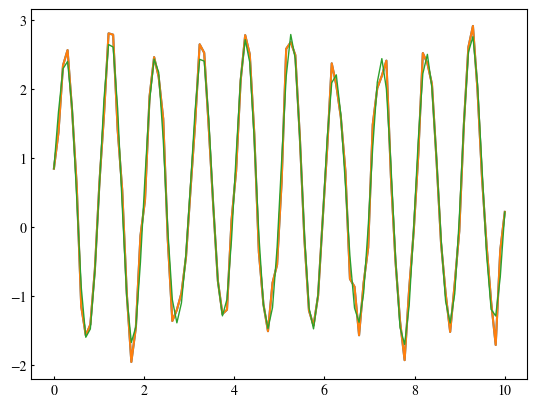

In [459]:
x = np.linspace(0, 10, 100)
y = 2*np.sin(2*np.pi*x) + np.random.rand(len(x))
plt.plot(x, y)
yf = butterworth_filter(y, 20)
plt.plot(x, y)
plt.plot(x, yf, lw=1)

(0.0, 0.7)

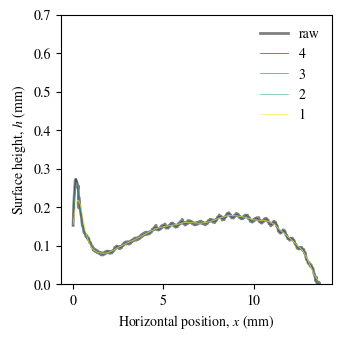

In [ ]:
# try various cutoff frequencies
plt.figure(figsize=(3.5,3.5))
signal = np.array([df.index, df["scan-7"]])
plt.plot(signal[0], signal[1], color="black", lw=2, alpha=.5, label="raw")
co_list = np.flip(np.arange(1, 5))
cmap = plt.get_cmap("viridis", len(co_list))
i = 0
for cutoff in co_list:
    filtered = butterworth_filter(signal, cutoff)
    plt.plot(filtered[0], filtered[1], color=cmap(i), lw=.5, alpha=.8, label=cutoff)
    i += 1
plt.legend(frameon=False)
plt.xlabel("Horizontal position, $x$ (mm)")
plt.ylabel("Surface height, $h$ (mm)")
plt.ylim([0, 0.7])

(0.0, 0.8)

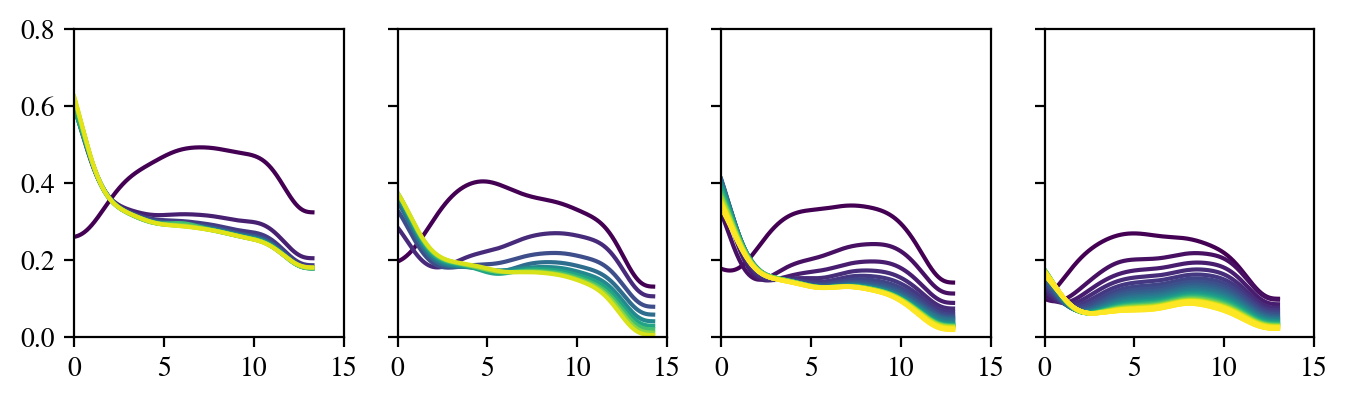

In [ ]:
# plot all curves with butterworth smoothing

folder = r"G:\My Drive\Research projects\WPM\Data\06212024\surface_profile"
cutoff = .3
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(8,2), dpi=200)
for j in range(4):
    df = pd.read_csv(os.path.join(folder, "PB_S10_trial1_{:d}.csv".format(j+1))).set_index("x")
    cmap = plt.get_cmap("viridis", min(df.shape[1], max_curve))
    i = 0
    for kw in df:
        if i % 2 == 0:
            y = df[kw]
            signal = np.array([y.index, y])
            x, s = butterworth_filter(signal, cutoff)
            s = pd.DataFrame(data={"s": s}, index=x)
            ax[j].plot(s.index, s, color=cmap(i), label="{:d} s".format(i*2))
        i += 1
ax[0].set_xlim([0, 15])
ax[0].set_ylim([0, 0.8])

## Appendix I. Dimple dynamics figure

We choose 3 experiments with different fates of the dimples to show in the paper. The chosen ones are:

1. 0821/beetjuice_2_0.8
2. 0821/beetjuice_3_0.305
3. 0821/beetjuice_1_0.116

This figure is 3 rows x 2 columns. Left column shows the surface scans and right columns shows the height and curvature.

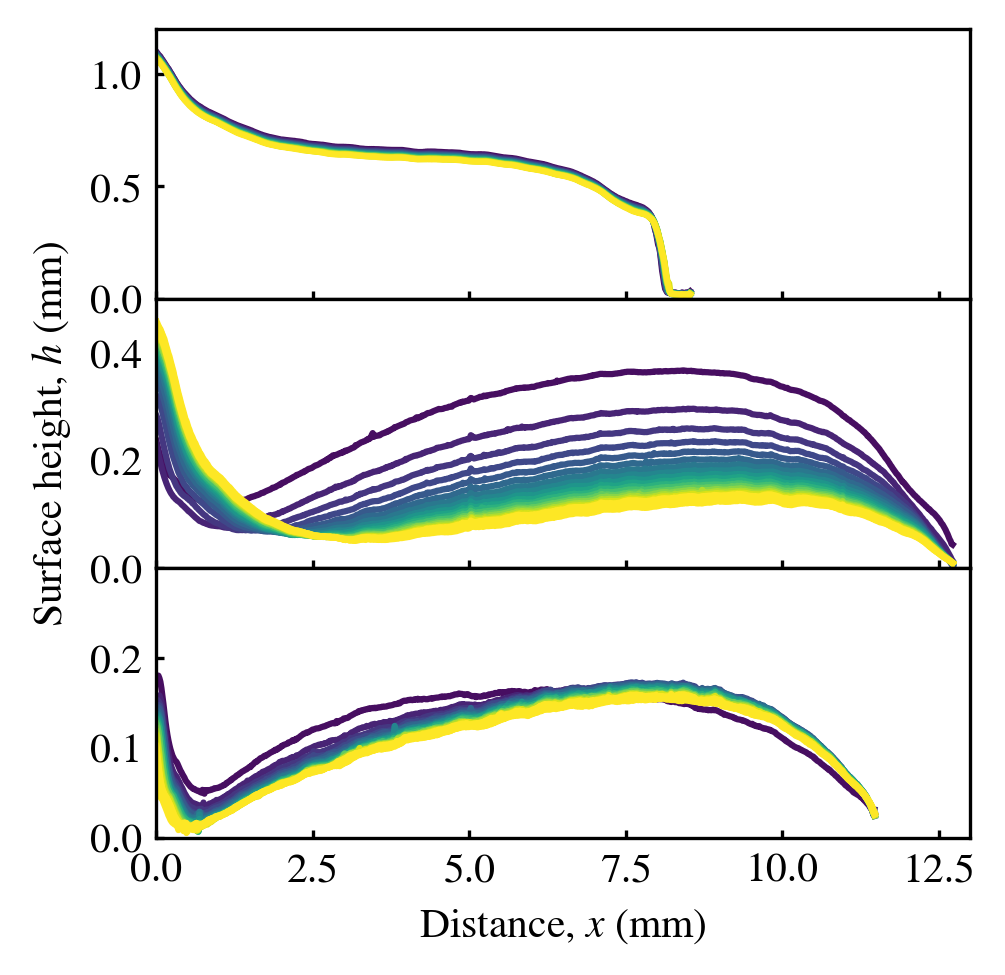

In [134]:
# surface dynamics
folder = r"G:\My Drive\Research projects\WPM\Data\08212024\surface_profile"
thick_file = os.path.join(folder, "beetjuice_2_0.8.csv")
middle_file = os.path.join(folder, "beetjuice_3_0.305.csv")
thin_file = os.path.join(folder, "beetjuice_1_0.116.csv")
thick = pd.read_csv(thick_file).set_index("x")
middle = pd.read_csv(middle_file).set_index("x")
thin = pd.read_csv(thin_file).set_index("x")
cmap = plt.get_cmap("viridis")

fig, ax = plt.subplots(nrows=3, figsize=(3.5, 3.5), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
tmax = float(thick.columns[-1])
for kw in thick[thick.columns[1::2]]:
    t = float(kw)
    ax[0].plot(thick.index, thick[kw], color=cmap(t/tmax))
    ax[0].set_ylim([0, 1.2])
for kw in middle[middle.columns[1::2]]:
    t = float(kw)
    ax[1].plot(middle.index, middle[kw], color=cmap(t/tmax))
    ax[1].set_ylim([0, 0.5])
for kw in thin[thin.columns[1::2]]:
    t = float(kw)
    ax[2].plot(thin.index, thin[kw]+0.02, color=cmap(t/tmax))
    ax[2].set_ylim([0, 0.3])
    ax[2].set_yticks([0, 0.1, 0.2])
ax[2].set_xlabel("Distance, $x$ (mm)")
ax[1].set_ylabel("Surface height, $h$ (mm)")
ax[0].set_xlim([0, 13])
fig.savefig("3scans.svg")

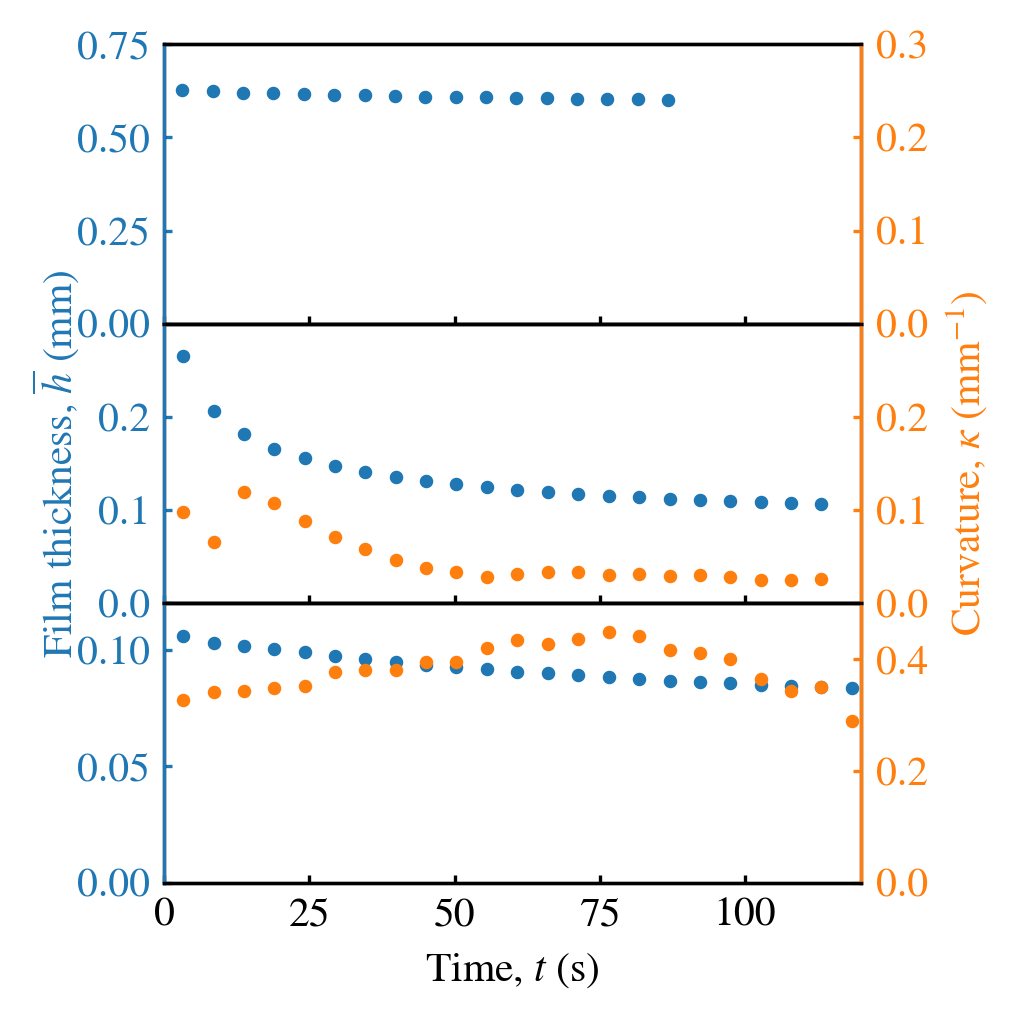

In [150]:
# height and curvature
folder = r"G:\My Drive\Research projects\WPM\Data\08212024\surface_profile\dimple_detection"
thick_file = os.path.join(folder, "beetjuice_2_0.8.csv")
middle_file = os.path.join(folder, "beetjuice_3_0.305.csv")
thin_file = os.path.join(folder, "beetjuice_1_0.116.csv")
fig, ax = plt.subplots(nrows=3, figsize=(3.5, 3.5), dpi=300, sharex=True, gridspec_kw={"hspace": 0})

thick = pd.read_csv(thick_file).set_index("t")
middle = pd.read_csv(middle_file).set_index("t")
thin = pd.read_csv(thin_file).set_index("t")
ax1 = {}
for i, data in enumerate([thick, middle, thin]):
    ax[i].scatter(data.index, data["mean_surface_height"], s=5, color=bestcolor(0))
    ax[i].yaxis.set_tick_params(color=bestcolor(0), labelcolor=bestcolor(0))
    # 
    # ax[i].set_ylabel("Film thickness, $\overline{h}$ (mm)", color=bestcolor(0))
    ax[i].set_ylim([0, data["mean_surface_height"].max()*1.05])

    ax1[i] = ax[i].twinx()
    ax1[i].spines['left'].set_color(bestcolor(0))
    ax1[i].spines['right'].set_color(bestcolor(1))
    ax1[i].yaxis.set_tick_params(color=bestcolor(1), labelcolor=bestcolor(1))
    ax1[i].scatter(data.index, data["curvature_minima"], color=bestcolor(1), s=5, marker="o")
ax[0].set_ylim([0, 0.75])
ax[1].set_ylim([0, 0.3])
ax[1].set_yticks([0, 0.1, 0.2])
ax[2].set_ylim([0, 0.12])
ax1[0].set_xlim([0, 120])
ax1[0].set_ylim([0, 0.3])
ax1[1].set_ylim([0, 0.3])
ax1[1].set_yticks([0, 0.1, 0.2])
ax1[2].set_ylim([0, 0.5])
ax[1].set_ylabel("Film thickness, $\overline{h}$ (mm)", color=bestcolor(0))
ax1[1].set_ylabel("Curvature, $\kappa$ (mm$^{-1}$)", color=bestcolor(1))
ax[2].set_xlabel("Time, $t$ (s)")
plt.tight_layout()
fig.savefig("3scans_height_curvature.svg")
